# Analysis of Airbnb listings and rent prices of metropolises in US
## -   NYC, Boston, San Francisco, and Seattle
##### A project submitted in partial fulfillment of the requirements for ECON-UB 232, Data Bootcamp
##### May 2020

### Contents

Introduction


1. Data
    
        1.1 Data Cleaning    

2. Exploratory Data Analysis

        2.1 Data Visualization        
            2.1.1 Location 
            2.1.2 Room Type
            2.1.3 Host
            2.1.4 Neighbourhood
                a) Popular neighbourhoods
                b) Room type within popular neighbourhoods
            2.1.5 Availability
   
       2.2 Data Analysis

           2.2.1 Price with room types
           2.2.2 Price with neighbourhoods
           2.2.3 Neighbourhood Exploration

3. Descriptive Data Analysis

        3.1 Pairplot of each variable    

4. Predictive Data Analysis
    
        4.1 Probability distribution 
        4.2 Correlation
        4.3 Regression
            4.3.1 Linear Regression
            4.3.2 Machine Learning
        
5. Cross-city Analysis    
        
        5.1 Data Cleaning & Filtering
        5.2 Listings comparison
        5.3 Density and distribution of prices comparison
        5.4 Availability comparison
        5.5 Reviews comparison
        5.6 Overall Conclusion for Machine Learning
6. Conclusion

# Introduction

AirBed and Breakfast, also known as Airbnb, is an American online marketplace company based in San Francisco, California, United States. The service Airbnb offer is mainly arrangement for lodging, primarily homestays, or tourism experiences. Founded in August 2008, Airbnb has brought unprecedented strong competition to traditional hotel industry. In fact, the company does not own any of the real estate listings, nor does it host events; it acts as a broker, receiving commission fee from each booking. On the one hand, this novel business model provides tourists with economic-friendly choice of living; on the other hand, renting idle rooms or houses to people in need is better for resource allocation, as well as creating additional revenues for household.

In the past few years, Airbnb has attracted 45.6 million users in total. Diversified background of hosts make the characteristics of Airbnb rooms very complicated. Besides, the pricing of Airbnb is always a hot topic. For hosts, they want to learn about the charactistics and prices of Airbnb rooms in the city so that they can improve their houses accordingly, set suitable prices for their houses, and get more profits. For guests, they want to spend time in cost-effective houses with their favorite characteristics.

In this project, we analyze and visualize characteristics of Airbnb rooms in for major American cities, New York City, Boston, San Francisco and Seattle (two on the east coast and two on the west coast). We compare the prices and run regressions to figure out the relationship between different factors and prices, then pick out the significant variables. Last but not least, we apply machine learning tools to train the model and make prediction for prices. We also do cross-city comparison so that people can get the sense of different and similar patterns in different cities. From our project, hosts can learn the patterns of rooms in different cities, and set proper prices according to different contributions of factors. Guests can have an overview of Airbnb houses in their destination, and choose a house which maximize their utility.

Hopefully this project will contribute to this rapidly growing industry, establish a fair and healthy market, do good to the resource allocation, and help both guests and hosts to make the optimized desicions.

In [288]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.image as img
from PIL import Image
import requests
from io import BytesIO
import seaborn as sns
from scipy.stats import norm
from scipy import stats
%matplotlib inline

### Preset Functions
##### For convenience in repetitive implementation for different cities.

In [289]:
# import dataset
def import_df(web):
    df = pd.read_csv(web)
    df['price'] = df['price'].str.replace('$','')
    df['price'] = df['price'].str.replace(',','').astype(float)
    return df

In [290]:
# import the image
def import_img(web):
    response = requests.get(web)
    img = Image.open(BytesIO(response.content))
    return img

In [291]:
# get the max/min value of longitude and latitude
def area(df):
    xl=df['longitude'].min()
    xh=df['longitude'].max()
    yl=df['latitude'].min()
    yh=df['latitude'].max()
    return xl,xh,yl,yh

In [292]:
# get the overall geographic location for all houses
def location(city,df,sqrt,colorsize,figsize1,figsize2):
    mpl.rcParams.update(mpl.rcParamsDefault)
    %matplotlib inline
    
    cmap = plt.cm.coolwarm
    n = mpl.colors.Normalize()
    fig,ax = plt.subplots(figsize=(figsize1,figsize2))
    df.plot.scatter(ax=ax,x='longitude',y='latitude',s=df['price']**sqrt,
                    color=cmap(n(df['price'].values)*colorsize))
    ax.set_xlim(df['longitude'].min()-0.01,df['longitude'].max()+0.01)
    ax.set_ylim(df['latitude'].min()-0.01,df['latitude'].max()+0.01)
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.set_title(city+' Airbnb Locations',size=14,fontweight='bold')
    return fig,ax

In [293]:
# get the geographic location under each room type category
def room_type_location(df,sqrt,colorsize,figsize1,figsize2):
    mpl.rcParams.update(mpl.rcParamsDefault)
    %matplotlib inline
    
    rtype = df.groupby(['id','room_type','latitude','longitude'],as_index=False)[['price']].mean()
    types = df['room_type'].unique()
    num = len(types)
    cmap = plt.cm.coolwarm
    n = mpl.colors.Normalize()
    fig,ax = plt.subplots(1,num,figsize=(figsize1*num,figsize2))
    for i in range(0,num):
        tprice = rtype.loc[rtype['room_type']==types[i],:]
        tprice.plot.scatter(ax=ax[i],x='longitude',y='latitude',s=tprice['price']**sqrt,
                            color=cmap(n(tprice['price'].values)*colorsize))
        ax[i].set_xlim(df['longitude'].min()-0.01,df['longitude'].max()+0.01)
        ax[i].set_ylim(df['latitude'].min()-0.01,df['latitude'].max()+0.01)
        ax[i].set_title(types[i],size=13,fontweight='bold')
        ax[i].set_xlabel('Longitude')
        ax[i].set_ylabel('Latitude')
    return fig,ax

In [294]:
# get the top 10 hosts with the most house listings
def top_hosts(city,df):
    top_host = df['host_id'].value_counts()[:10]
    ax = sns.barplot(top_host.index, top_host.values,order=top_host.index)
    ax.set_xticklabels(ax.get_xticklabels(),rotation=45)
    ax.set_title('Hosts with the most listings in '+city,size=14,fontweight='bold')
    ax.set_ylabel('Count of listings')
    ax.set_xlabel('Host IDs')

In [295]:
# count number of listings in each neighbourhood
def count_nei(city,df):
    mpl.rcParams.update(mpl.rcParamsDefault)
    %matplotlib inline
    fig,ax = plt.subplots(figsize=(18,5))
    ax = sns.countplot(x='neighbourhood',data=df)
    ax.set_xlabel('Neighbourhood group')
    ax.set_ylabel('Count')
    ax.set_title('Counts of listings in neighbourhoods',fontsize=14,fontweight='bold')
    ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
    return fig,ax

In [296]:
# plot pie charts for number of listings in each neighbourhood
def nei_pie(city,df): 
    if city == 'NYC':
        labels = df.neighbourhood_group.value_counts().index
        sizes = df.neighbourhood_group.value_counts().values
        explode = (0.1, 0.2, 0.3, 0.4, 0.6)
    else:
        labels = df.neighbourhood.value_counts().index
        sizes = df.neighbourhood.value_counts().values
        explode = np.full(len(sizes),0.1)
    fig, ax = plt.subplots()
    wedges, texts, autotexts = ax.pie(sizes, explode=explode,labels=labels, autopct='%1.1f%%',
                                       shadow=True, startangle=90)
    ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    ax.set_title('Most rented neighbourhood group pie chart',size=12,fontweight='bold')
    ax.legend(wedges, labels,
              title='Neighbourhood groups',
              loc='center left',
              bbox_to_anchor=(1, 0, 0.5, 1))
    return ax

In [297]:
# get price distribution of each neighbourhood
def nei_stats(city,df):
    if city == 'NYC':
        col = 'neighbourhood_group'
    else:
        col = 'neighbourhood'
    nei = df[col].unique()
    price_list = []
    for n in nei:
        sub = df.loc[df[col] == n]
        sub_price = sub[['price']]
        price_list.append(sub_price)
    stats_list = []
    for p in price_list:
        i = p.describe(percentiles=[.25, .50, .75])
        i = i.iloc[3:]
        i.reset_index(inplace=True)
        i.rename(columns={'index':'Stats'},inplace=True)
        stats_list.append(i)
    # change names of the price column to the area name
    for i in range(0,len(nei)):
        stats_list[i].rename(columns={'price':nei[i]},inplace=True)

    # finilize dataframe for final view    
    stats_df = stats_list
    stats_df = [df.set_index('Stats') for df in stats_df]
    stats_df = stats_df[0].join(stats_df[1:])
    stats_df
    return stats_df

# use violinplot to show density and distribtuion of prices 
def plot_distribution(city,df,dropv):
    if city == 'NYC':
        col = 'neighbourhood_group'
        angel = 0
    else:
        col = 'neighbourhood'
        angel = 45
    # create a sub-dataframe with no extreme values / less than 500
    no_extreme = df[df.price < dropv]    
    ax = sns.violinplot(data=no_extreme,x=col,y='price')
    ax.set_xlabel('Neighbourhood group')
    ax.set_ylabel('Price')
    ax.set_title('Density and distribution of prices for each neighbourhood group',fontweight='bold')
    ax.set_xticklabels(ax.get_xticklabels(),rotation=angel)
    return fig,ax

In [298]:
# get top 10 neighborhoods with the most listings
def top_nei(city,df): 
    nbhd = df.neighbourhood.value_counts()[:10]
    figure,ax = plt.subplots(figsize=(6,4))
    x = list(nbhd.index)
    y = list(nbhd.values)
    ax = sns.barplot(y,x)
    ax.set_title('Most Popular Neighbourhood in '+city,size=14,fontweight='bold')
    ax.set_ylabel("Neighbourhood area")
    ax.set_xlabel("Number of guest hosted in this Area")
    return fig,ax

In [299]:
# get the number of rooms under each room type in the top 10 neighborhoods
def top_nei_room_type(city,df):
    top10nei = df.neighbourhood.value_counts()[:10].index
    top10nei_df = df.loc[df['neighbourhood'].isin(top10nei)]
    if city == 'NYC':
        ax = sns.catplot(x='neighbourhood',col='room_type',hue='neighbourhood_group',data=top10nei_df,kind='count')
    else:
        ax = sns.catplot(x='neighbourhood',col='room_type',data=top10nei_df,kind='count')
    ax.set_xticklabels(rotation=45)
    return ax

In [300]:
# use colormap to display avaialbility_365
def ava365(city,df,figsize1,figsize2):
    fig,ax = plt.subplots(figsize=(figsize1,figsize2))
    df.plot(kind='scatter', x='longitude', y='latitude', label='availability_365', c='availability_365', cmap='YlGnBu', alpha=0.6,colorbar=True,ax=ax)
    ax.set_title('Availability of rooms in '+city,size=14,fontweight='bold')
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.legend().remove()
    return fig,ax

# ➢ NYC

# 1. Data

## 1.1 Data Cleaning

In [301]:
url1 = 'https://raw.githubusercontent.com/kristallqiu99/'
url2 = 'data_bootcamp_final_project/master/nyc_data/AB_NYC_2019.csv'
nyc = pd.read_csv(url1+url2,index_col=0)

In [302]:
nyc.head(5)

id                                              name  host_id  \
0  2539                Clean & quiet apt home by the park     2787   
1  2595                             Skylit Midtown Castle     2845   
2  3647               THE VILLAGE OF HARLEM....NEW YORK !     4632   
3  3831                   Cozy Entire Floor of Brownstone     4869   
4  5022  Entire Apt: Spacious Studio/Loft by central park     7192   

     host_name neighbourhood_group neighbourhood  latitude  longitude  \
0         John            Brooklyn    Kensington  40.64749  -73.97237   
1     Jennifer           Manhattan       Midtown  40.75362  -73.98377   
2    Elisabeth           Manhattan        Harlem  40.80902  -73.94190   
3  LisaRoxanne            Brooklyn  Clinton Hill  40.68514  -73.95976   
4        Laura           Manhattan   East Harlem  40.79851  -73.94399   

         room_type  price  minimum_nights  number_of_reviews last_review  \
0     Private room    149               1                  9  2018-10-19   
1  Entire home/apt    225               1                 45  2019-05-21   
2     Private room    150               3                  0         NaN   
3  Entire home/apt     89               1                270  2019-07-05   
4  Entire home/apt     80              10                  9  2018-11-19   

   reviews_per_month  calculated_host_listings_count  availability_365  
0               0.21                               6               365  
1               0.38                               2               355  
2                NaN                               1               365  
3               4.64                               1               194  
4               0.10                               1                 0

In [303]:
nyc.dtypes

id                                  int64
name                               object
host_id                             int64
host_name                          object
neighbourhood_group                object
neighbourhood                      object
latitude                          float64
longitude                         float64
room_type                          object
price                               int64
minimum_nights                      int64
number_of_reviews                   int64
last_review                        object
reviews_per_month                 float64
calculated_host_listings_count      int64
availability_365                    int64
dtype: object

In [304]:
nyc.isnull().sum()

id                                    0
name                                 16
host_id                               0
host_name                            21
neighbourhood_group                   0
neighbourhood                         0
latitude                              0
longitude                             0
room_type                             0
price                                 0
minimum_nights                        0
number_of_reviews                     0
last_review                       10052
reviews_per_month                 10052
calculated_host_listings_count        0
availability_365                      0
dtype: int64

In [305]:
nyc.drop(['name','host_name','last_review'],axis = 1,inplace=True)
nyc = nyc.dropna(subset=['reviews_per_month'])
nyc = nyc.loc[nyc['price']>0,:]
nyc.describe()

id       host_id      latitude     longitude         price  \
count  3.883300e+04  3.883300e+04  38833.000000  38833.000000  38833.000000   
mean   1.809583e+07  6.423943e+07     40.728139    -73.951156    142.354595   
std    1.069500e+07  7.589466e+07      0.054992      0.046697    196.957737   
min    2.539000e+03  2.438000e+03     40.506410    -74.244420     10.000000   
25%    8.719522e+06  7.033514e+06     40.688640    -73.982470     69.000000   
50%    1.886923e+07  2.837092e+07     40.721720    -73.954810    101.000000   
75%    2.755799e+07  1.018090e+08     40.763000    -73.935020    170.000000   
max    3.645581e+07  2.738417e+08     40.913060    -73.712990  10000.000000   

       minimum_nights  number_of_reviews  reviews_per_month  \
count    38833.000000       38833.000000       38833.000000   
mean         5.867561          29.295393           1.373128   
std         17.386070          48.188127           1.680391   
min          1.000000           1.000000           0.010000   
25%          1.000000           3.000000           0.190000   
50%          2.000000           9.000000           0.720000   
75%          4.000000          33.000000           2.020000   
max       1250.000000         629.000000          58.500000   

       calculated_host_listings_count  availability_365  
count                    38833.000000      38833.000000  
mean                         5.164602        114.878222  
std                         26.299034        129.549091  
min                          1.000000          0.000000  
25%                          1.000000          0.000000  
50%                          1.000000         55.000000  
75%                          2.000000        229.000000  
max                        327.000000        365.000000

# 2. Exploratory Data Analysis

## 2.1 Data Visualization 

### 2.1.1 Location

Text(0.5, 1.0, 'NYC Airbnb Locations')

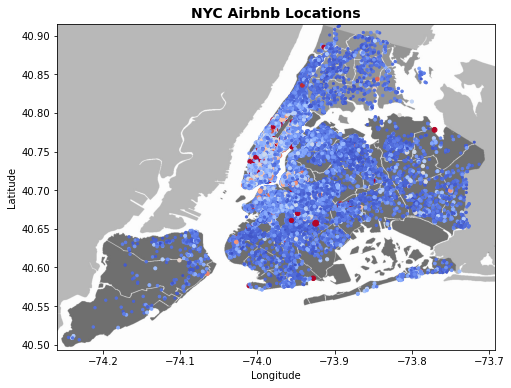

In [306]:
mpl.rcParams.update(mpl.rcParamsDefault)
%matplotlib inline

response = requests.get('https://raw.githubusercontent.com/kristallqiu99/data_bootcamp_final_project/master/nyc_data/NYC_map.png')
img_nyc = Image.open(BytesIO(response.content))

cmap = plt.cm.coolwarm
n = mpl.colors.Normalize()

fig,ax = plt.subplots(figsize=(8,6))

xl=nyc['longitude'].min()-0.015
xh=nyc['longitude'].max()+0.02
yl=nyc['latitude'].min()-0.013
yh=nyc['latitude'].max()+0.0025

ax.imshow(img_nyc,extent=[xl,xh,yl,yh])

nyc.plot.scatter(ax = ax,x = 'longitude',y = 'latitude',s = nyc['price']**0.4,
                color = cmap(n(nyc['price'].values)*13))

ax.set_xlim(xl,xh)
ax.set_ylim(yl,yh)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('NYC Airbnb Locations',size=14,fontweight='bold')

##### In the plot above, the most expensive houses are plotted in red dots and the cheaper ones are plotted in light blue. We learn surprisingly that in NYC, the most expensive Airbnb houses are located dispersedly, instead of clustering in one specific area.

### 2.1.2 Room Type 

#### a) Number of listings of each room type

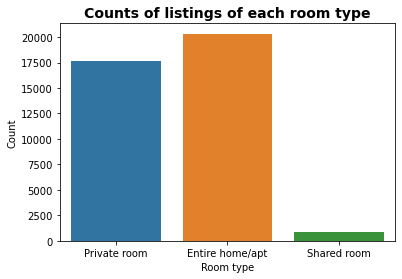

In [307]:
ax = sns.countplot(data=nyc,x='room_type')
ax.set_xlabel('Room type')
ax.set_ylabel('Count')
ax.set_title('Counts of listings of each room type',size=14,fontweight='bold')
current_palette = sns.color_palette()

##### From the bar chart above, we know that there are very few shared room as Airbnb offerings in NYC. There are two major room types in NYC, private room and entire home types, relatively of the same number.

#### b) Spread

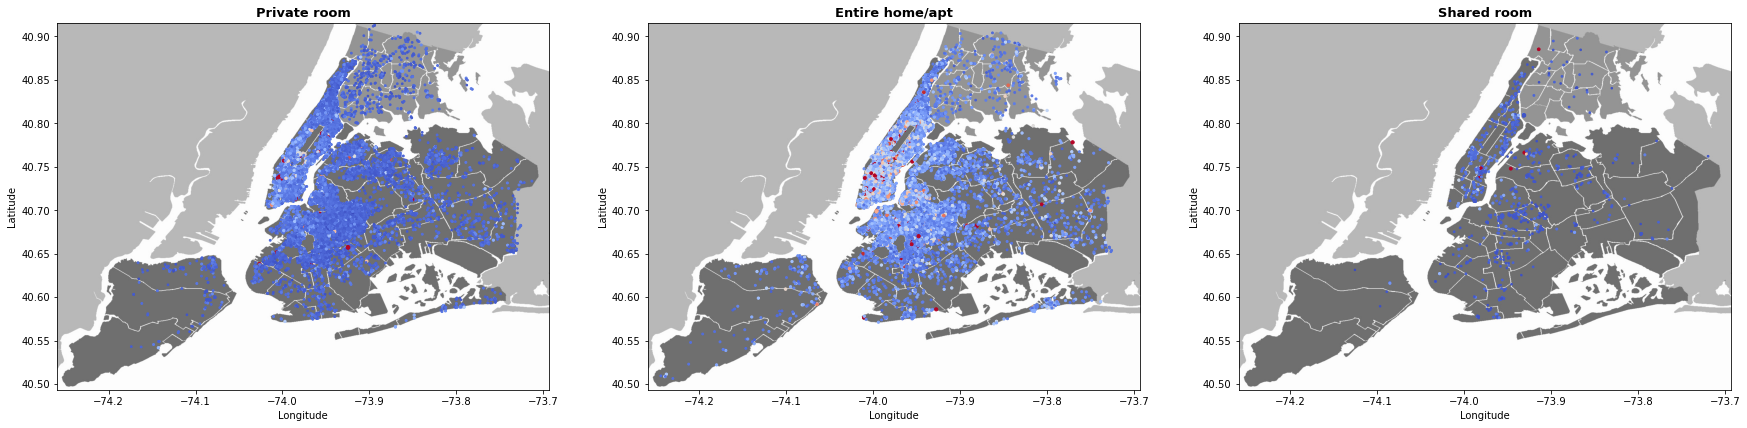

In [308]:
mpl.rcParams.update(mpl.rcParamsDefault)
%matplotlib inline

rtype = nyc.groupby(['id','room_type','latitude','longitude'],as_index=False)[['price']].mean()
rtype
type = nyc['room_type'].unique()
num = len(type)
cmap = plt.cm.coolwarm
n = mpl.colors.Normalize()
fig,ax = plt.subplots(1,num,figsize=(10*num,14))
for i in range(0,num):
    tprice = rtype.loc[rtype['room_type']==type[i],:]
    tprice.plot.scatter(ax=ax[i],x='longitude',y='latitude',s=tprice['price']**0.3,
                        color=cmap(n(tprice['price'].values)*13))
    ax[i].set_title(type[i],size=13,fontweight='bold')
    ax[i].set_xlabel('Longitude')
    ax[i].set_ylabel('Latitude')
    ax[i].imshow(img_nyc,extent=[xl,xh,yl,yh])


##### Those two major room types distribute evenly in NYC, and their locations don't follow some certain patterns.

### 2.1.3 Host

/Users/kristallqiu/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 0, 'Host IDs')

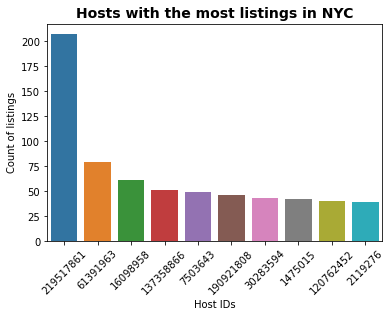

In [309]:
top_host = nyc['host_id'].value_counts()[:10]
ax = sns.barplot(top_host.index, top_host.values,order=top_host.index)
ax.set_xticklabels(ax.get_xticklabels(),rotation=45)
ax.set_title('Hosts with the most listings in NYC',size=14,fontweight='bold')
ax.set_ylabel('Count of listings')
ax.set_xlabel('Host IDs')

##### We notice that there is one host with a significantly high number of listings than other hosts in NYC, who has more than 200 listings. After that, other hosts all have listings fewer than 100 and the number doesn't different much from each other.

### 2.1.4 Neighbourhood

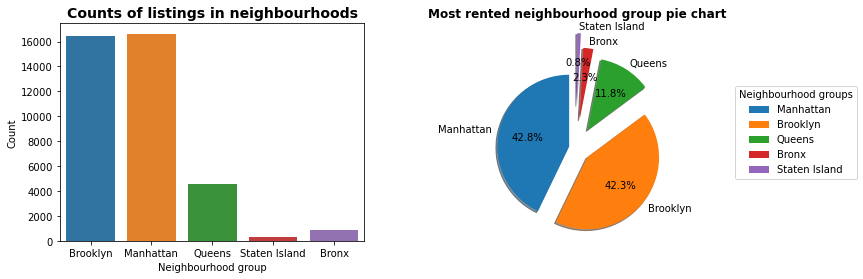

In [310]:
fig, ax = plt.subplots(1,2,figsize=(12,4))
# bar chart
sns.countplot(x='neighbourhood_group',data=nyc,ax=ax[0])
ax[0].set_xlabel('Neighbourhood group')
ax[0].set_ylabel('Count')
ax[0].set_title('Counts of listings in neighbourhoods',fontsize=14,fontweight='bold')
current_palette = sns.color_palette()

# pie chart
labels = nyc.neighbourhood_group.value_counts().index
sizes = nyc.neighbourhood_group.value_counts().values
explode = (0.1, 0.2, 0.3, 0.4, 0.6)

wedges, texts, autotexts = ax[1].pie(sizes, explode=explode,labels=labels, autopct='%1.1f%%',
                                   shadow=True, startangle=90)
ax[1].axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
ax[1].set_title('Most rented neighbourhood group pie chart',size=12,fontweight='bold')
ax[1].legend(wedges, labels,
          title='Neighbourhood groups',
          loc='center left',
          bbox_to_anchor=(1, 0, 0.5, 1))

##### From the pie chart and bar chart above, we learn that most Airbnb houses are located in Manhattan and Brooklyn, where there are more scenery spots and places for fun.

### 2.1.5 Availability

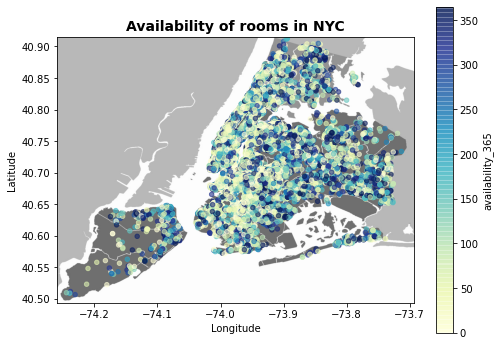

In [311]:
fig,ax = plt.subplots(figsize=(8,6))
nyc.plot(kind='scatter', x='longitude', y='latitude', label='availability_365',
         c='availability_365', cmap='YlGnBu', alpha=0.6,colorbar=True,ax=ax)
xl=nyc['longitude'].min()-0.015
xh=nyc['longitude'].max()+0.02
yl=nyc['latitude'].min()-0.013
yh=nyc['latitude'].max()+0.0025
ax.imshow(img_nyc,extent=[xl,xh,yl,yh])
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('Availability of rooms in NYC',size=14,fontweight='bold')
ax.legend().remove()

##### In this graph, we plot the availability of rooms in NYC. We notice that most rooms are available for fewer than 200 days per year, while there are a few houses that are available for the whole year. We guess that most rooms are made available during peak tourist seasons, but during the tourist-off season, some rooms will not be available since there isn't a very large demand in the market.

## 2.2 Data Analysis

### 2.2.1 Price with room types

In [312]:
rtype = nyc['room_type'].unique()
price_list = []
for n in rtype:
    sub = nyc.loc[nyc['room_type'] == n]
    sub_price = sub[['price']]
    price_list.append(sub_price)
stats_list = []
for p in price_list:
    i = p.describe(percentiles=[.25, .50, .75])
    i = i.iloc[3:]
    i.reset_index(inplace=True)
    i.rename(columns={'index':'Stats'},inplace=True)
    stats_list.append(i)
# change names of the price column to the area name
for i in range(0,len(rtype)):
    stats_list[i].rename(columns={'price':rtype[i]},inplace=True)
# finilize dataframe for final view    
stats_df = stats_list
stats_df = [df.set_index('Stats') for df in stats_df]
stats_df = stats_df[0].join(stats_df[1:])
stats_df

Private room  Entire home/apt  Shared room
Stats                                            
min            10.0             10.0         10.0
25%            50.0            116.0         32.0
50%            70.0            151.0         45.0
75%            94.0            220.0         70.0
max         10000.0          10000.0       1800.0

#### a) Density distribution

Text(0.5, 1.0, 'Density and distribution of prices for each room type')

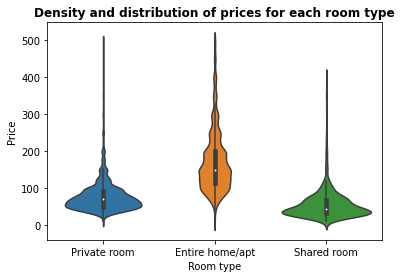

In [313]:
no_extreme = nyc[nyc.price < 500]    
ax = sns.violinplot(data=no_extreme,x='room_type',y='price')
ax.set_xlabel('Room type')
ax.set_ylabel('Price')
ax.set_title('Density and distribution of prices for each room type',fontweight='bold')

##### From the density distribution, we know that hosts charge a higher price for entire home/apt room type, ranging from less than 100 dollars to more than 300 dollars, even to 400 dollars. On the contrary, most private rooms and shared rooms are charged a price of fewer than 100 dollars per day.

#### b) Compare & Contrast - Neighbourhood

Text(0.5, 1.0, 'Mean price of each room type')

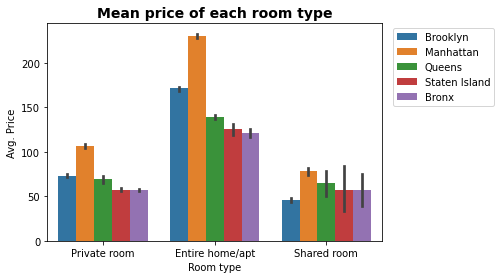

In [314]:
ax = sns.barplot(data=nyc,x='room_type',y='price',hue='neighbourhood_group',ci=68)
ax.legend(bbox_to_anchor=(1, 0, 0.35, 1))
ax.set_xlabel('Room type')
ax.set_ylabel('Avg. Price')
ax.set_title('Mean price of each room type',fontsize=14,fontweight ='bold')

##### We learn from this graph that regardless the room type, the mean price of rooms in Manhattan is much higher than that of rooms in other boroughs.

### 2.2.2 Price with neighbourhoods

In [315]:
nei_stats('NYC',nyc)

Brooklyn  Manhattan   Queens  Staten Island  Bronx
Stats                                                    
min        10.0       10.0     10.0           13.0   20.0
25%        60.0       90.0     50.0           50.0   45.0
50%        94.0      140.0     72.0           75.0   65.0
75%       150.0      200.0    109.0          105.0   95.0
max     10000.0     9999.0  10000.0          625.0  800.0

#### a) Density distribution

(<Figure size 576x432 with 2 Axes>,
 <AxesSubplot:title={'center':'Density and distribution of prices for each neighbourhood group'}, xlabel='Neighbourhood group', ylabel='Price'>)

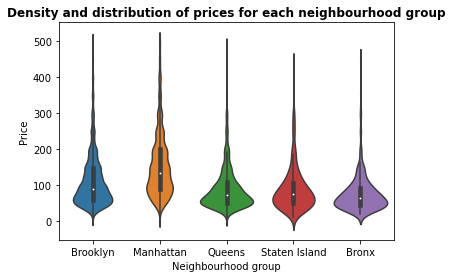

In [316]:
plot_distribution('NYC',nyc,500)

##### In this graph, we plot the density and distribution of prices for each neighbourhood group. As before, the prices in Manhattan vary the most, while the prices in other districts are more concentrated.

#### b) Compare & Contrast - Room Type

Text(0, 0.5, 'Avg. Price')

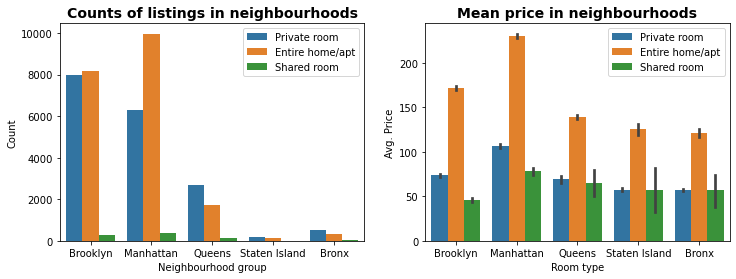

In [317]:
figure,ax = plt.subplots(1,2,figsize=(12,4))
sns.countplot(data=nyc,x='neighbourhood_group',hue='room_type',palette=current_palette,ax=ax[0])
ax[0].set_title('Counts of listings in neighbourhoods',fontsize=14,fontweight ='bold')
ax[0].set_xlabel('Neighbourhood group')
ax[0].set_ylabel('Count')
ax[0].legend()

sns.barplot(data=nyc,x='neighbourhood_group',y='price',hue='room_type',ci=68,ax=ax[1],palette=current_palette)
ax[1].legend(bbox_to_anchor=(1, 0, 0, 1))
ax[1].set_title('Mean price in neighbourhoods',fontsize=14,fontweight ='bold')
ax[1].set_xlabel('Room type')
ax[1].set_ylabel('Avg. Price')

##### Here with the comparison of count of listings and mean price, we notice that the mean price in Manhattan, especially mean price for entire home/apt, is much higher than mean price in other districts. Manhattan has most counts of listings of entire home/apt, too.

### 2.2.3 Neighbourhood Exploration

#### a) Popular neighbourhoods

/Users/kristallqiu/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 0, 'Number of guest hosted in this Area')

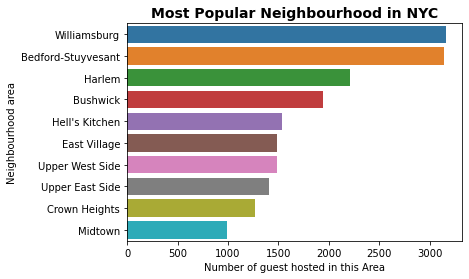

In [318]:
nbhd = nyc.neighbourhood.value_counts()[:10]
figure,ax = plt.subplots(figsize=(6,4))
x = list(nbhd.index)
y = list(nbhd.values)
ax = sns.barplot(y,x)
ax.set_title('Most Popular Neighbourhood in NYC',size=14,fontweight='bold')
ax.set_ylabel("Neighbourhood area")
ax.set_xlabel("Number of guest hosted in this Area")

##### We list top ten most popular neighbourhood in NYC in this horizontal bar chart. There are many names that we are familier with; and we learn that the most popular neighbourhood are mostly located in Manhattan.

####  b) Room type within popular neighbourhoods

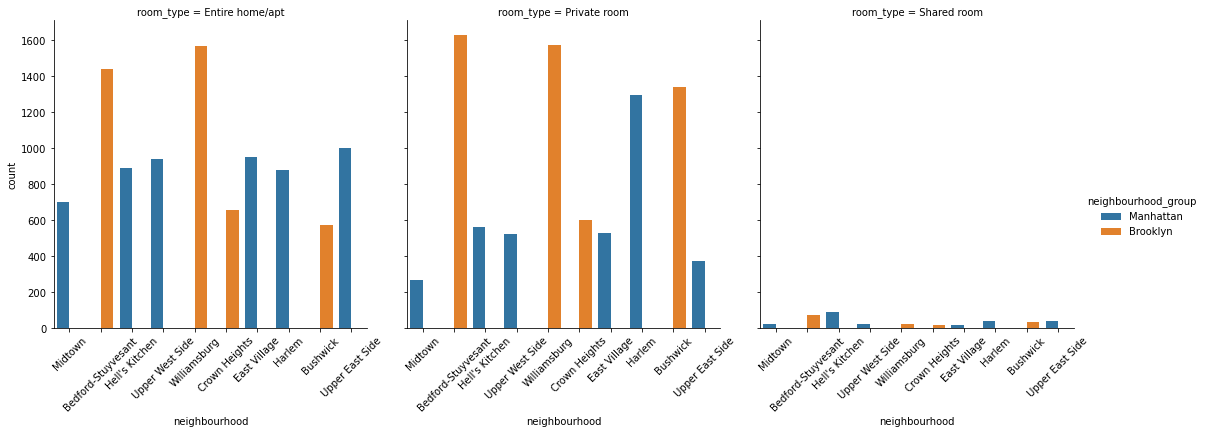

In [319]:
top10nei = nyc.neighbourhood.value_counts()[:10].index
top10nei_df = nyc.loc[nyc['neighbourhood'].isin(top10nei)]
ax = sns.catplot(x='neighbourhood',col='room_type',hue='neighbourhood_group',data=top10nei_df,kind='count')
ax.set_xticklabels(rotation=45)

##### Based on the top ten popular neighborhood we selected before, we picture the room types information in these neighborhoods for readers' reference. Guests can know the distribution of their favourite room type in popular neighborhoods, so that they can make the decisions more easily.

# 3. Descriptive Data Analysis

##  3.1 Pairplot of each variable

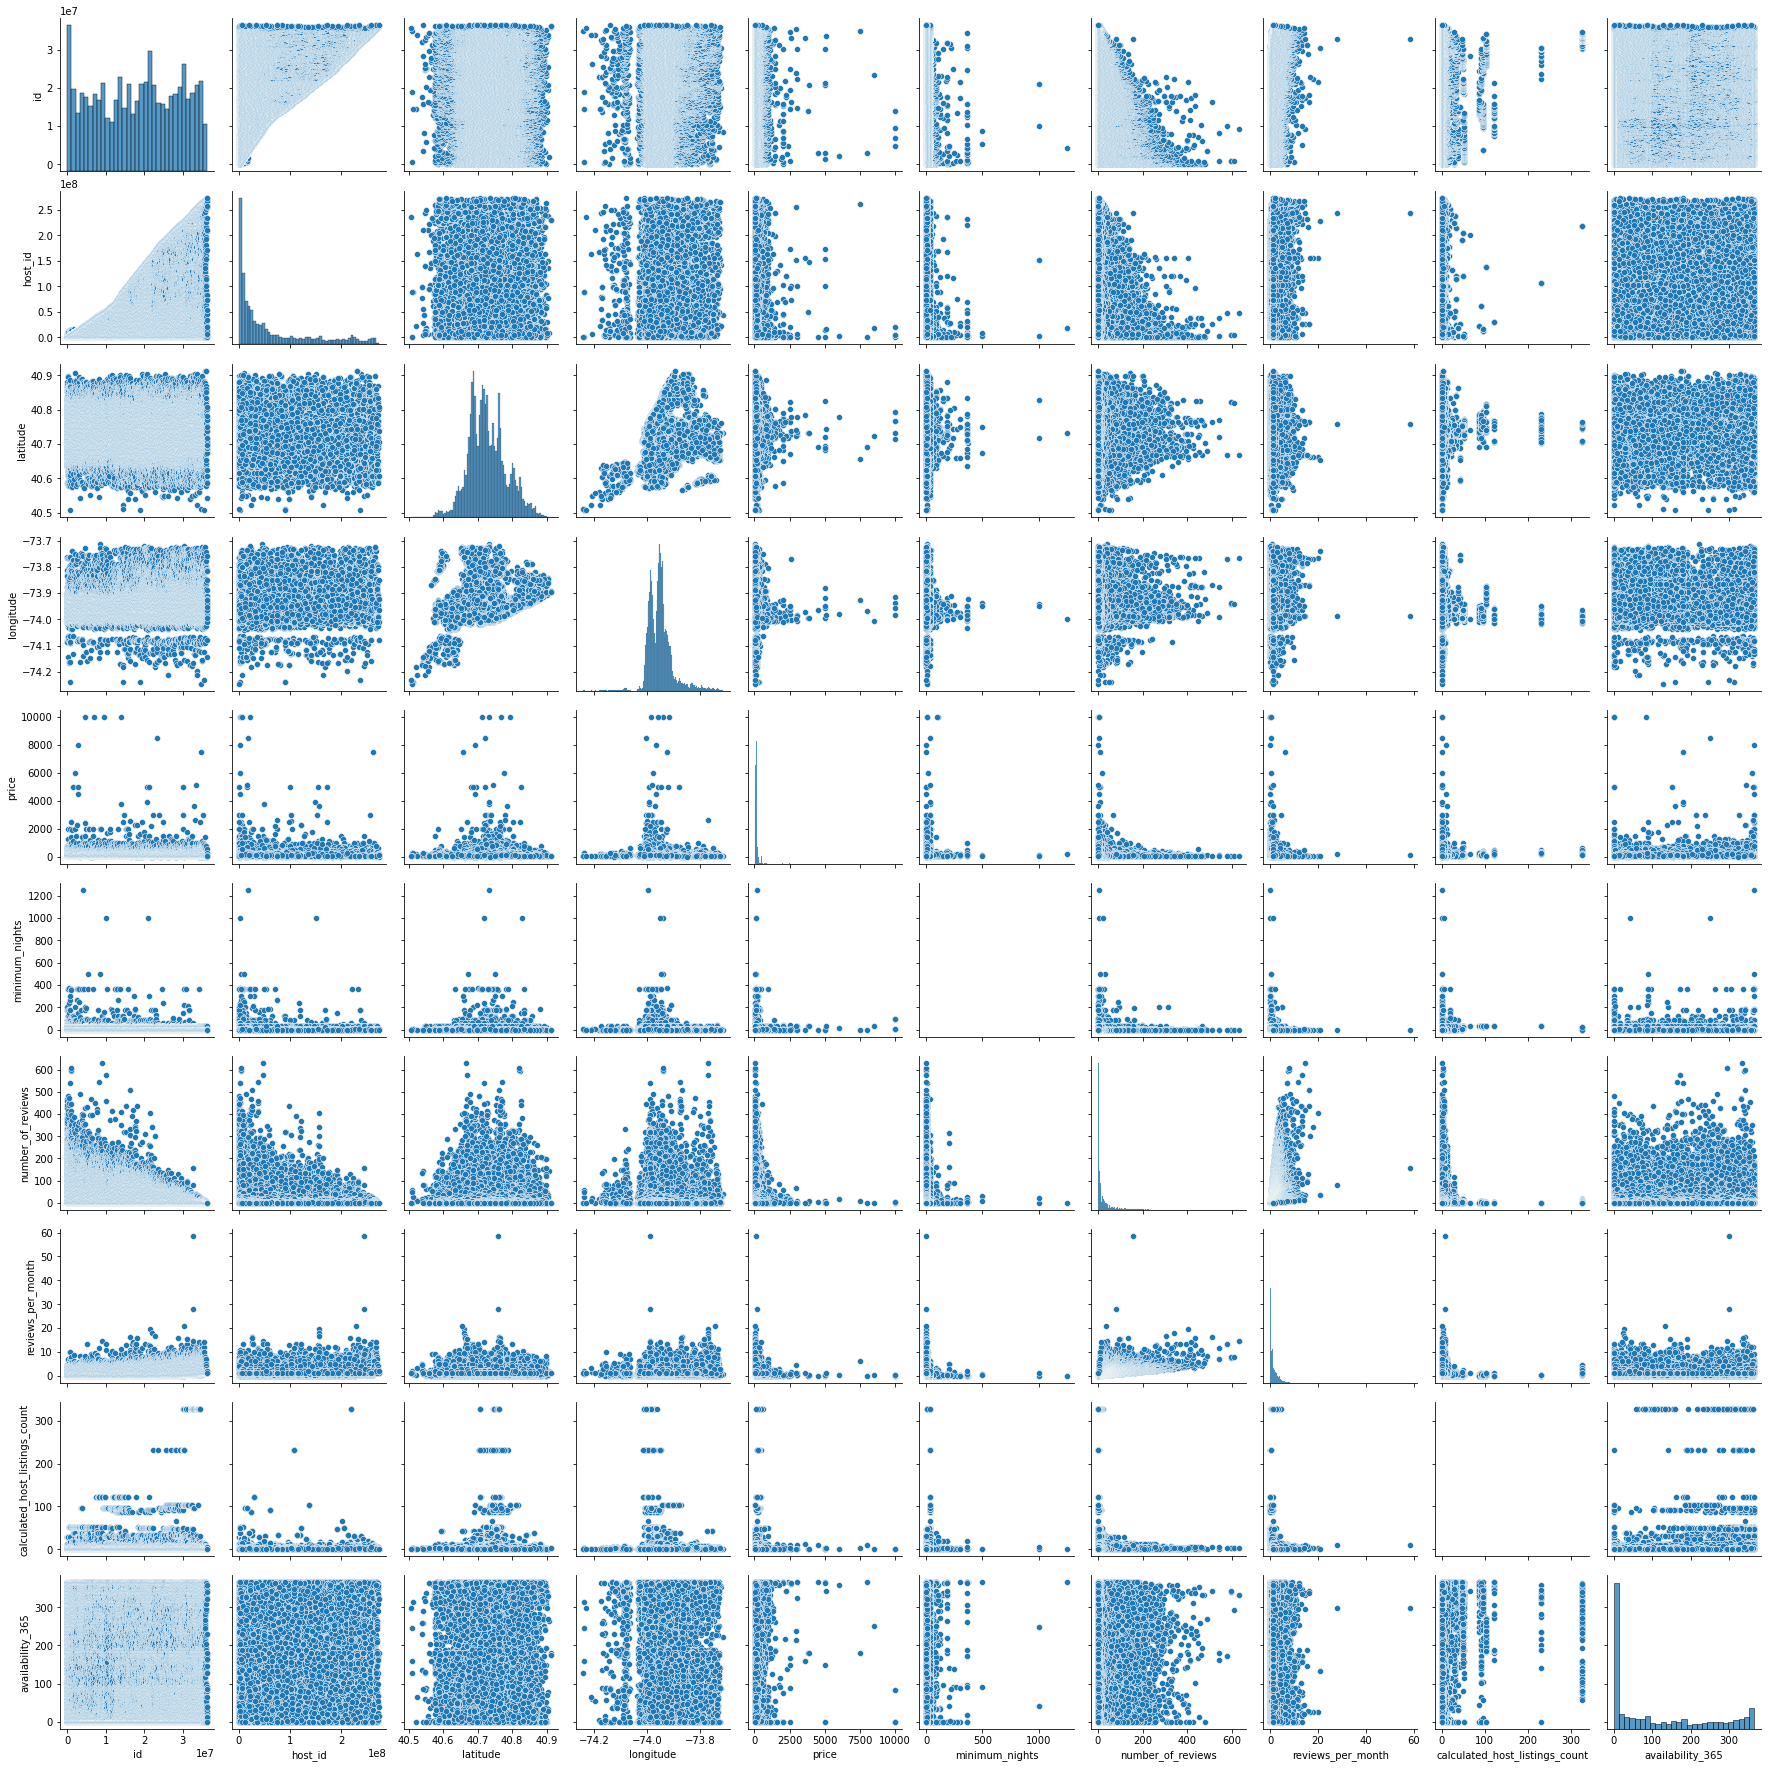

In [320]:
sns.pairplot(nyc) 

##### We can see the correltation between each variable. It does not make sense as many of them are categorical data and interrelated. We can also observe that there are extreme values of price so we may need to drop those extreme values.


# 4. Predictive Data Analysis

In [321]:
# encode string values
model = nyc.copy()
model['neighbourhood_group']= model['neighbourhood_group'].astype("category").cat.codes
model['neighbourhood'] = model['neighbourhood'].astype("category").cat.codes
model['room_type'] = model['room_type'].astype("category").cat.codes

mean = model['reviews_per_month'].mean()
model['reviews_per_month'].fillna(mean, inplace=True)

model['log_price'] = np.log(model.price+1)

model = model.drop(columns=['id' ,'host_id','price']) # delete price column

model.isnull().sum()

neighbourhood_group               0
neighbourhood                     0
latitude                          0
longitude                         0
room_type                         0
minimum_nights                    0
number_of_reviews                 0
reviews_per_month                 0
calculated_host_listings_count    0
availability_365                  0
log_price                         0
dtype: int64

#####  Value Reference

In [322]:
nycVF = {}
nycd = ['neighbourhood_group','room_type']
for c in nycd:
    nycVF = {}
    for i in model[c].unique():
        indx = model[model[c]==i].index.values[0]
        nycVF[i] = nyc[c][indx]
    print(c.capitalize(),'\n',dict(sorted(nycVF.items())))

Neighbourhood_group 
 {0: 'Bronx', 1: 'Brooklyn', 2: 'Manhattan', 3: 'Queens', 4: 'Staten Island'}
Room_type 
 {0: 'Entire home/apt', 1: 'Private room', 2: 'Shared room'}


## 4.1 Probability distribution

/Users/kristallqiu/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/kristallqiu/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Log-Price Distribution Plot')

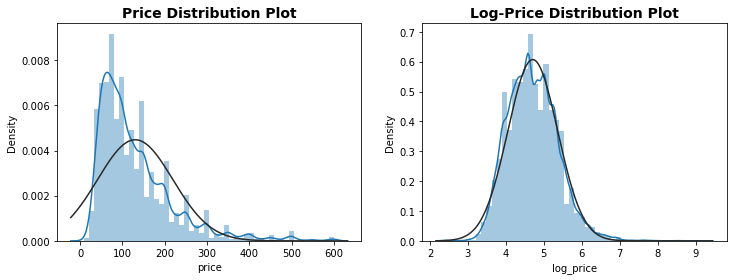

In [323]:
fig,ax = plt.subplots(1,2,figsize=(12,4))
sns.distplot(nyc.loc[nyc['price']<=600]['price'],fit=norm, ax=ax[0]) # drop extreme values of price which are greater than 600
ax[0].set_title("Price Distribution Plot",size=14, weight='bold')
sns.distplot(model['log_price'],fit=norm,ax=ax[1])
ax[1].set_title("Log-Price Distribution Plot",size=14, weight='bold')

##### We learn that the log-price distribution is approximately normal, with a mean close to 5.

##  4.2 Correlation


Text(0.5, 1.0, 'Correlation Matrix')

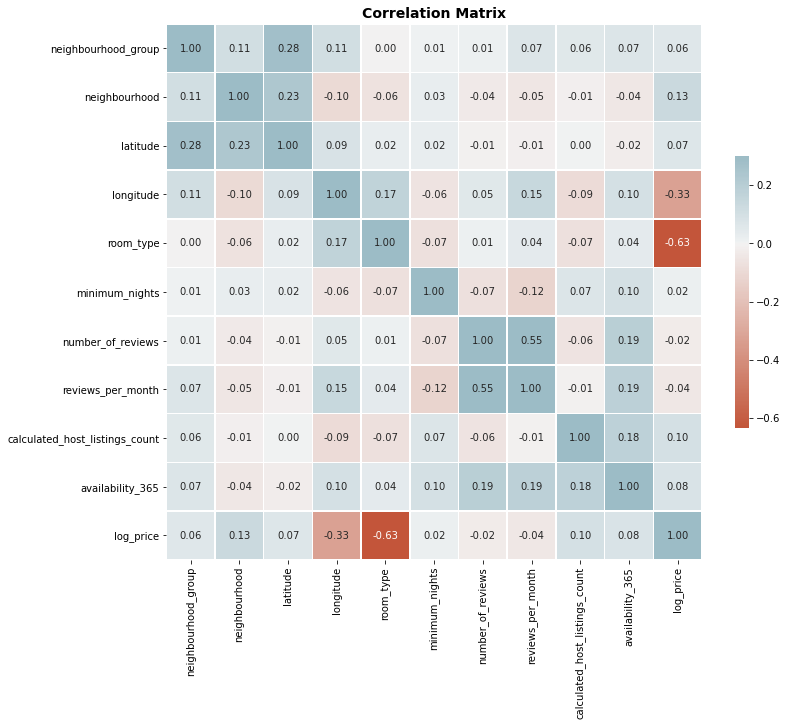

In [324]:
plt.figure(figsize=(12,10))
palette = sns.diverging_palette(20, 220, n=256)
corr=model.corr(method='pearson')
sns.heatmap(corr, annot=True, fmt=".2f", cmap=palette, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}).set(ylim=(11, 0))
plt.title("Correlation Matrix",size=14, weight='bold')

##### In this correlation matrix we calculate and display the correlation between different variables. The hosts can easily find the relationship between variables and make the optimized investment decisions.

##  4.3 Regression

In [325]:
model['price'] = nyc['price']
model.head(5)

neighbourhood_group  neighbourhood  latitude  longitude  room_type  \
0                    1            107  40.64749  -73.97237          1   
1                    2            126  40.75362  -73.98377          0   
3                    1             41  40.68514  -73.95976          0   
4                    2             61  40.79851  -73.94399          0   
5                    2            136  40.74767  -73.97500          0   

   minimum_nights  number_of_reviews  reviews_per_month  \
0               1                  9               0.21   
1               1                 45               0.38   
3               1                270               4.64   
4              10                  9               0.10   
5               3                 74               0.59   

   calculated_host_listings_count  availability_365  log_price  price  
0                               6               365   5.010635    149  
1                               2               355   5.420535    225  
3                               1               194   4.499810     89  
4                               1                 0   4.394449     80  
5                               1               129   5.303305    200

### 4.3.1 Linear Regression 

In [326]:
import statsmodels.formula.api as smf

#### a) Price - all variables

In [327]:
reg_price = smf.ols('price ~  neighbourhood_group +room_type +  availability_365 + number_of_reviews +  calculated_host_listings_count + reviews_per_month'
                    ,data=model).fit()

print(reg_price.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.091
Model:                            OLS   Adj. R-squared:                  0.091
Method:                 Least Squares   F-statistic:                     646.4
Date:                Wed, 04 Nov 2020   Prob (F-statistic):               0.00
Time:                        11:43:13   Log-Likelihood:            -2.5841e+05
No. Observations:               38833   AIC:                         5.168e+05
Df Residuals:                   38826   BIC:                         5.169e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept   

##### Here we run an ordinary least square regression for price on several factors that we think may influence the price of Airbnb. We have H0: beta = 0 against H1: beta != 0  for every beta in this regression model. According to the output table, the P-value of reviews_per_month is bigger than 5%, which means that we don't reject H0 against H1. There is no evidence that the effect of reviews_per_month is significant to the price of Airbnb house and we should drop it. 

#### a) Price - drop reviews_per_month

In [328]:
reg_price = smf.ols('price ~  neighbourhood_group +room_type +  availability_365 + number_of_reviews +  calculated_host_listings_count'
                    ,data=model).fit()

print(reg_price.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.091
Model:                            OLS   Adj. R-squared:                  0.091
Method:                 Least Squares   F-statistic:                     774.2
Date:                Wed, 04 Nov 2020   Prob (F-statistic):               0.00
Time:                        11:43:13   Log-Likelihood:            -2.5841e+05
No. Observations:               38833   AIC:                         5.168e+05
Df Residuals:                   38827   BIC:                         5.169e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept   

##### Here we run an ordinary least square regression for log_price on several x variables. We have H0: beta = 0 against H1: beta != 0  for every beta in this regression model. This time each veriable is significant at 5% level.
##### And, we can get price = 169.6320 + neighbourhood_group* 7.8472 - room_type* 103.1122 + availability_365* 0.1459 - number_of_reviews* 0.2104 + calculated_host_listings_count* 0.0815
##### And from this, we can find that availability make the largest contribution to a relative higher price.

#### b) Log price

In [329]:
reg_logprice = smf.ols('log_price ~  neighbourhood_group +room_type +  availability_365 + number_of_reviews +  calculated_host_listings_count + reviews_per_month'
                    ,data=model).fit()
print(reg_logprice.summary())

                            OLS Regression Results                            
Dep. Variable:              log_price   R-squared:                       0.418
Model:                            OLS   Adj. R-squared:                  0.418
Method:                 Least Squares   F-statistic:                     4641.
Date:                Wed, 04 Nov 2020   Prob (F-statistic):               0.00
Time:                        11:43:13   Log-Likelihood:                -28305.
No. Observations:               38833   AIC:                         5.662e+04
Df Residuals:                   38826   BIC:                         5.668e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept   

##### We run the OLS regression for log_price again and the remained variables are all significant.
##### Therefore, we can get log_price = 4.9375 - 0.762* room_type - 0.0056* reviews_per_month + 0.001* neighbourhood + 0.0006* availability_365 - 0.0004*number_of_reviews + calculated_how_listings_count* 0.0009 - reviews_per_month*0.0056
##### We find that neighbour has the greatest relevance of the log_price.

### 4.3.2 ML

##### From the linear regression we found that log_price is a better dependent variable to predict.

In [330]:
from sklearn.model_selection import train_test_split

In [331]:
X_train1, X_test1, y_train1, y_test1 = train_test_split(model[['room_type']].values, model[['log_price']].values,
                                        test_size=0.25, random_state=0)

#### a) K-Nearest Neighbors

In [332]:
from sklearn.neighbors import KNeighborsRegressor as knn
from sklearn.model_selection import cross_val_score

In [333]:
scores = pd.Series()
for i in range(20,1000,40):
    scores[str(i)] = cross_val_score(knn(n_neighbors=i),
                    X_train1, y_train1,cv=5).mean()
indx = scores.idxmax()

<ipython-input-333-a95900ce99d7>:1: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  scores = pd.Series()


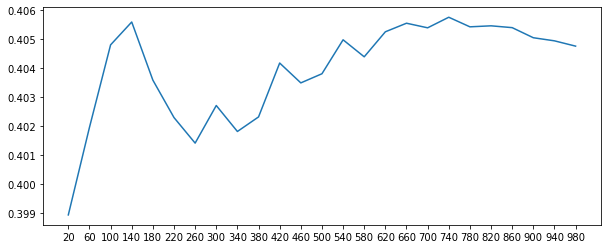

In [334]:
fig,ax = plt.subplots(figsize=(10,4))
plt.plot(scores.index,scores.values)

In [335]:
skl_knn = knn(n_neighbors=int(indx)).fit(X_train1, y_train1)
knn_score1 = skl_knn.score(X_test1, y_test1)
print(knn_score1)

0.41313093103436194


#### b) Random Forest

In [336]:
from sklearn.ensemble import RandomForestRegressor as rf

In [337]:
cross_val_score(rf(n_estimators=100,max_depth=3),X_train1, y_train1.ravel(),cv=5).mean()

0.4072375187490146

In [338]:
cv_scores = pd.DataFrame()
for i in range(1,25):
    cv_scores.loc[i,'rf'] = cross_val_score(rf(n_estimators=100,max_depth=i),X_train1, y_train1.ravel(),cv=5).mean()

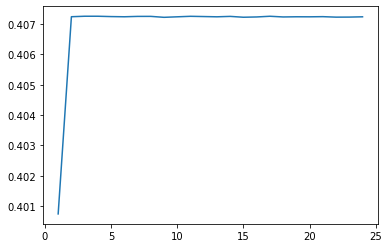

In [339]:
ax = cv_scores.plot()
ax.get_legend().remove()

In [340]:
indx = scores.idxmax()
skl_rf = rf(n_estimators=100,max_depth=int(indx)).fit(X_train1, y_train1.ravel())
skl_rf.predict(X_test1)
rf_score1 = skl_rf.score(X_test1,y_test1)
print(rf_score1)

0.4136244486236249


In [341]:
score_table = pd.DataFrame({'K Nearest Neighbors':[knn_score1],'Random Forest':[rf_score1]})
score_table = score_table.T
score_table.columns = ['Score']
score_table

Score
K Nearest Neighbors  0.413131
Random Forest        0.413624

#####  As we can see from above table, for log_price, we should choose Random Forest  as the score of this model is the highest, compared to KNN.

##### Rank score for log_price :  Random Forest  >  KNN
##### Possiable reason for a relative low score for both is that log_price also  should  be dependent on some features not containing in the dataFrame as well, such as environment, surroundings or quality of the room and so on. 

# ➢ Boston

# 1. Data

## 1.1 Data Cleaning

In [342]:
bos=import_df('https://raw.githubusercontent.com/kristallqiu99/' +
              'data_bootcamp_final_project/master/boston_data/AB_BOS_2016.csv')
bos.head(5)

Unnamed: 0        id                            listing_url  \
0           0  12147973  https://www.airbnb.com/rooms/12147973   
1           1   3075044   https://www.airbnb.com/rooms/3075044   
2           2      6976      https://www.airbnb.com/rooms/6976   
3           3   1436513   https://www.airbnb.com/rooms/1436513   
4           4   7651065   https://www.airbnb.com/rooms/7651065   

        scrape_id last_scraped                                           name  \
0  20160906204935   2016-09-07                     Sunny Bungalow in the City   
1  20160906204935   2016-09-07              Charming room in pet friendly apt   
2  20160906204935   2016-09-07               Mexican Folk Art Haven in Boston   
3  20160906204935   2016-09-07  Spacious Sunny Bedroom Suite in Historic Home   
4  20160906204935   2016-09-07                            Come Home to Boston   

                                             summary  \
0  Cozy, sunny, family home.  Master bedroom high...   
1  Charming and quiet room in a second floor 1910...   
2  Come stay with a friendly, middle-aged guy in ...   
3  Come experience the comforts of home away from...   
4  My comfy, clean and relaxing home is one block...   

                                               space  \
0  The house has an open and cozy feel at the sam...   
1  Small but cozy and quite room with a full size...   
2  Come stay with a friendly, middle-aged guy in ...   
3  Most places you find in Boston are small howev...   
4  Clean, attractive, private room, one block fro...   

                                         description experiences_offered  ...  \
0  Cozy, sunny, family home.  Master bedroom high...                none  ...   
1  Charming and quiet room in a second floor 1910...                none  ...   
2  Come stay with a friendly, middle-aged guy in ...                none  ...   
3  Come experience the comforts of home away from...                none  ...   
4  My comfy, clean and relaxing home is one block...                none  ...   

  review_scores_value requires_license license jurisdiction_names  \
0                 NaN                f     NaN                NaN   
1                 9.0                f     NaN                NaN   
2                10.0                f     NaN                NaN   
3                10.0                f     NaN                NaN   
4                10.0                f     NaN                NaN   

  instant_bookable cancellation_policy require_guest_profile_picture  \
0                f            moderate                             f   
1                t            moderate                             f   
2                f            moderate                             t   
3                f            moderate                             f   
4                f            flexible                             f   

  require_guest_phone_verification calculated_host_listings_count  \
0                                f                              1   
1                                f                              1   
2                                f                              1   
3                                f                              1   
4                                f                              1   

  reviews_per_month  
0               NaN  
1              1.30  
2              0.47  
3              1.00  
4              2.25  

[5 rows x 96 columns]

In [343]:
bos.dtypes

Unnamed: 0                            int64
id                                    int64
listing_url                          object
scrape_id                             int64
last_scraped                         object
                                     ...   
cancellation_policy                  object
require_guest_profile_picture        object
require_guest_phone_verification     object
calculated_host_listings_count        int64
reviews_per_month                   float64
Length: 96, dtype: object

In [344]:
var_col = ['id','host_id','host_since','host_response_time',
       'host_response_rate', 'host_acceptance_rate', 'host_is_superhost',
       'host_listings_count', 'host_total_listings_count','host_has_profile_pic', 'host_identity_verified',
       'street', 'neighbourhood_cleansed','latitude', 'longitude','property_type', 'room_type', 'accommodates',
       'bathrooms', 'bedrooms', 'beds', 'bed_type','price','guests_included', 
        'extra_people', 'minimum_nights','maximum_nights','availability_365',
        'number_of_reviews','cancellation_policy',
       'require_guest_profile_picture', 'require_guest_phone_verification',
       'calculated_host_listings_count','reviews_per_month']
bos = bos.loc[:,var_col]
bos.rename(columns={'neighbourhood_cleansed':'neighbourhood'}, inplace=True)

In [345]:
bos.isnull().sum()

id                                    0
host_id                               0
host_since                            0
host_response_time                  471
host_response_rate                  471
host_acceptance_rate                471
host_is_superhost                     0
host_listings_count                   0
host_total_listings_count             0
host_has_profile_pic                  0
host_identity_verified                0
street                                0
neighbourhood                         0
latitude                              0
longitude                             0
property_type                         3
room_type                             0
accommodates                          0
bathrooms                            14
bedrooms                             10
beds                                  9
bed_type                              0
price                                 0
guests_included                       0
extra_people                          0


In [346]:
bos = bos.dropna(subset=['reviews_per_month','host_response_time','host_response_rate','host_acceptance_rate']) 

In [347]:
bos

id   host_id  host_since  host_response_time host_response_rate  \
1      3075044   2572247  2012-06-07      within an hour               100%   
2         6976     16701  2009-05-11  within a few hours               100%   
3      1436513   6031442  2013-04-21  within a few hours               100%   
4      7651065  15396970  2014-05-11      within an hour               100%   
5     12386020  64200298  2016-03-23  within a few hours               100%   
...        ...       ...         ...                 ...                ...   
3574  14743129  91855319  2016-08-25      within an hour               100%   
3575   5280827  19246369  2014-07-31      within an hour                96%   
3578  14536322  78459716  2016-06-18      within an hour               100%   
3580   8373729  19246369  2014-07-31      within an hour                96%   
3583  14603878  74318064  2016-05-27      within an hour               100%   

     host_acceptance_rate host_is_superhost  host_listings_count  \
1                    100%                 f                    1   
2                     88%                 t                    1   
3                     50%                 f                    1   
4                    100%                 t                    1   
5                     95%                 t                    2   
...                   ...               ...                  ...   
3574                 100%                 f                    2   
3575                 100%                 f                   28   
3578                 100%                 f                    4   
3580                 100%                 f                   28   
3583                  96%                 f                    4   

      host_total_listings_count host_has_profile_pic  ... extra_people  \
1                             1                    t  ...        $0.00   
2                             1                    t  ...       $20.00   
3                             1                    t  ...       $25.00   
4                             1                    t  ...        $0.00   
5                             2                    t  ...        $0.00   
...                         ...                  ...  ...          ...   
3574                          2                    t  ...       $35.00   
3575                         28                    t  ...       $24.00   
3578                          4                    t  ...        $0.00   
3580                         28                    t  ...       $24.00   
3583                          4                    t  ...       $30.00   

     minimum_nights maximum_nights  availability_365  number_of_reviews  \
1                 2             15               359                 36   
2                 3             45               319                 41   
3                 1           1125                98                  1   
4                 2             31               334                 29   
5                 2           1125                58                  8   
...             ...            ...               ...                ...   
3574              1           1125               363                  1   
3575              2           1125               356                  6   
3578              1           1125               315                  2   
3580              2           1125               356                  4   
3583              1             13               253                  2   

     cancellation_policy require_guest_profile_picture  \
1               moderate                             f   
2               moderate                             t   
3               moderate                             f   
4               flexible                             f   
5               flexible                             f   
...                  ...                           ...   
3574            moderate                          

In [348]:
bos.describe()

id       host_id  host_listings_count  \
count  2.593000e+03  2.593000e+03          2593.000000   
mean   7.720118e+06  2.307167e+07            46.735442   
std    4.490205e+06  2.234577e+07           145.530247   
min    3.353000e+03  4.240000e+03             1.000000   
25%    4.032126e+06  5.052732e+06             1.000000   
50%    7.840131e+06  1.644292e+07             2.000000   
75%    1.205282e+07  3.332387e+07             7.000000   
max    1.484378e+07  9.185532e+07           749.000000   

       host_total_listings_count     latitude    longitude  accommodates  \
count                2593.000000  2593.000000  2593.000000   2593.000000   
mean                   46.735442    42.338866   -71.083306      3.082144   
std                   145.530247     0.025334     0.031476      1.845237   
min                     1.000000    42.235942   -71.171469      1.000000   
25%                     1.000000    42.325530   -71.104034      2.000000   
50%                     2.000000    42.344829   -71.077042      2.000000   
75%                     7.000000    42.355024   -71.061682      4.000000   
max                   749.000000    42.389982   -71.000100     16.000000   

         bathrooms     bedrooms         beds        price  guests_included  \
count  2581.000000  2585.000000  2587.000000  2593.000000      2593.000000   
mean      1.216002     1.250290     1.633939   167.139992         1.497493   
std       0.502640     0.771759     1.072460   110.693155         1.128720   
min       0.000000     0.000000     0.000000    11.000000         0.000000   
25%       1.000000     1.000000     1.000000    85.000000         1.000000   
50%       1.000000     1.000000     1.000000   147.000000         1.000000   
75%       1.000000     1.000000     2.000000   219.000000         2.000000   
max       6.000000     5.000000    16.000000  1300.000000        14.000000   

       minimum_nights  maximum_nights  availability_365  number_of_reviews  \
count     2593.000000    2.593000e+03       2593.000000        2593.000000   
mean         2.938681    3.937274e+04        198.947551          25.901658   
std          7.242207    1.963791e+06        135.990574          39.668787   
min          1.000000    1.000000e+00          0.000000           1.000000   
25%          1.000000    1.800000e+02         59.000000           3.000000   
50%          2.000000    1.125000e+03        248.000000          11.000000   
75%          3.000000    1.125000e+03        328.000000          30.000000   
max        273.000000    1.000000e+08        365.000000         404.000000   

       calculated_host_listings_count  reviews_per_month  
count                     2593.000000        2593.000000  
mean                        10.882761           2.114192  
std                         24.492553           2.153386  
min                          1.000000           0.010000  
25%                          1.000000           0.610000  
50%                          2.000000           1.360000  
75%                          6.000000           2.970000  
max                        136.000000          19.150000

# 2. Exploratory Data Analysis

## 2.1 Data Visualization

### 2.1.1 Location

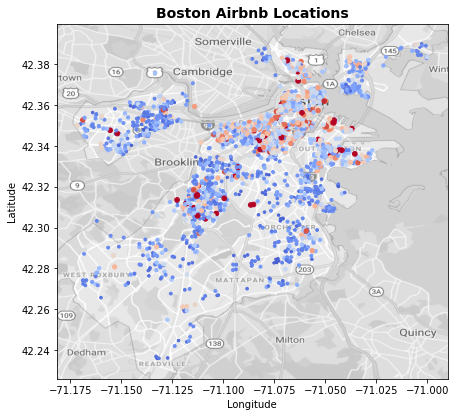

In [349]:
fig,ax = location('Boston', bos,0.5,3,7,7)
xl,xh,yl,yh = area(bos)
img_bos = import_img('https://raw.githubusercontent.com/kristallqiu99/' +
                     'data_bootcamp_final_project/master/boston_data/BOS_map.png')
ax.imshow(img_bos,extent=[xl-0.02,xh+0.01,yl-0.01,yh+0.01])

##### In the plot above, the most expensive houses are plotted in red dots and the cheaper ones are plotted in light blue. We find that the most expensive houses usually locate in Back Bay area.

### 2.1.2 Room Type 

#### a) Number of listings of each room type

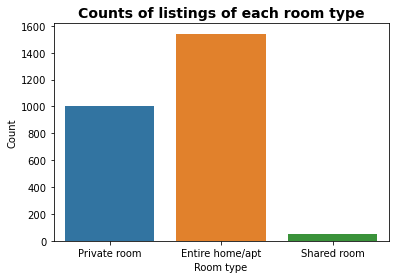

In [350]:
ax = sns.countplot(data=bos,x='room_type')
ax.set_xlabel('Room type')
ax.set_ylabel('Count')
ax.set_title('Counts of listings of each room type',size=14,fontweight='bold')
current_palette = sns.color_palette()

##### From the bar chart above, we know that there are very few shared room as Airbnb offerings in boston, just like NYC. The entire room/apt has the highest counts of listings, with a number of almost 1600.

#### b) Spread

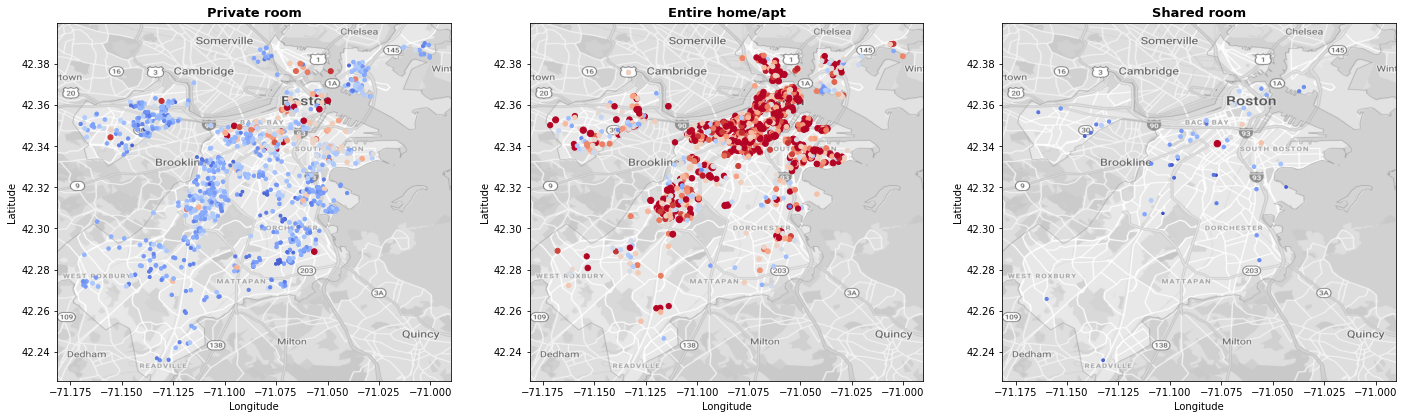

In [351]:
fig,ax = room_type_location(bos,0.6,1.5,8,8)
for i in range(0,len(bos['room_type'].unique())):
    ax[i].imshow(img_bos,extent=[xl-0.02,xh+0.01,yl-0.01,yh+0.01])

##### From the plot above, we notice that the private room are very widespread. But the entire home/apt mostly locate in Back Bay area.

### 2.1.3 Host 

/Users/kristallqiu/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


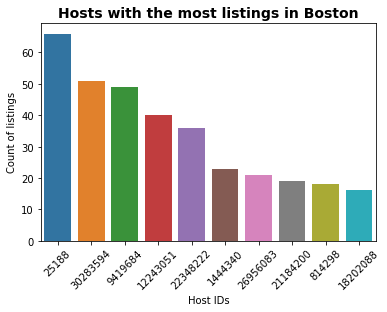

In [352]:
top_hosts('Boston',bos)

##### We notice that there is one host with more than 60 listings. Four hosts are in the second tier, having listings from 30 to 50. The difference between number of hosts are not so big as NYC.

### 2.1.4 Neighbourhood

(<Figure size 1296x360 with 1 Axes>,
 <AxesSubplot:title={'center':'Counts of listings in neighbourhoods'}, xlabel='Neighbourhood group', ylabel='Count'>)

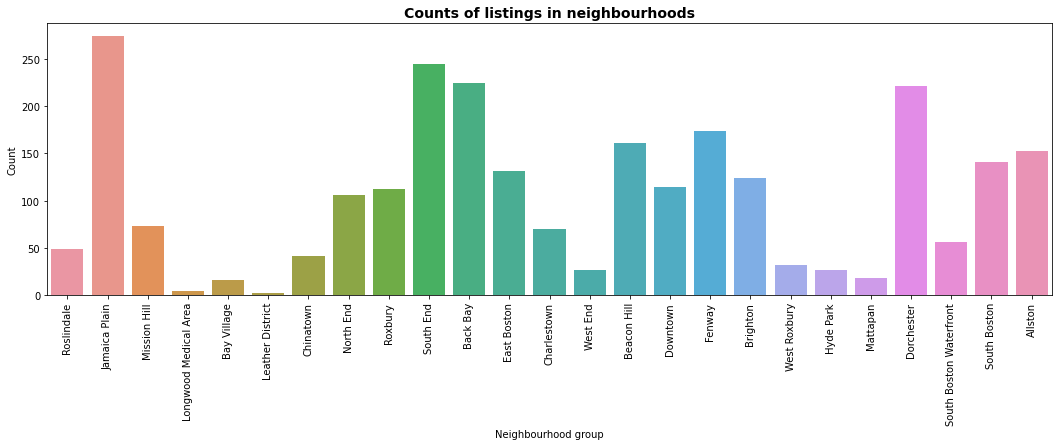

In [353]:
count_nei('Boston',bos)

##### From the bar chart above, we learn that there are more neighborhoods in Boston than in New York. The neighbourhoods with most listings are: Jamaica Plain, South End, Back Bay, and Dorchester. There are many neighborhoods with fewer than 50 listings, too.

### 2.1.5 Availability 

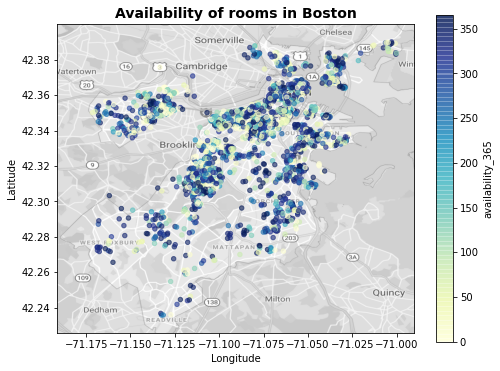

In [354]:
fig,ax = ava365('Boston',bos,8,6)
ax.imshow(img_bos,extent=[xl-0.02,xh+0.01,yl-0.01,yh+0.01])

##### In this graph, we plot the availability of rooms in Boston. We notice that most rooms are available for more than 200 days per year, which is very different from the situation in NYC. We guess that the total number of listings in Boston is smaller, so there is less competition in this market.

## 2.2 Data Analysis 

###  2.2.1 Price with room types

In [355]:
rtype = bos['room_type'].unique()
price_list = []
for n in rtype:
    sub = bos.loc[bos['room_type'] == n]
    sub_price = sub[['price']]
    price_list.append(sub_price)
stats_list = []
for p in price_list:
    i = p.describe(percentiles=[.25, .50, .75])
    i = i.iloc[3:]
    i.reset_index(inplace=True)
    i.rename(columns={'index':'Stats'},inplace=True)
    stats_list.append(i)
# change names of the price column to the area name
for i in range(0,len(rtype)):
    stats_list[i].rename(columns={'price':rtype[i]},inplace=True)
# finilize dataframe for final view    
stats_df = stats_list
stats_df = [df.set_index('Stats') for df in stats_df]
stats_df = stats_df[0].join(stats_df[1:])
stats_df

Private room  Entire home/apt  Shared room
Stats                                            
min            20.0             11.0        22.00
25%            65.0            150.0        45.00
50%            79.0            199.0        60.00
75%           100.0            269.0        84.75
max           350.0           1300.0       500.00

#### a) Density distribution 

Text(0.5, 1.0, 'Density and distribution of prices for each room type')

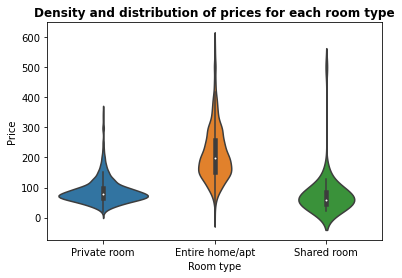

In [356]:
no_extreme = bos[bos.price < 600]    
ax = sns.violinplot(data=no_extreme,x='room_type',y='price')
ax.set_xlabel('Room type')
ax.set_ylabel('Price')
ax.set_title('Density and distribution of prices for each room type',fontweight='bold')

##### From the density distribution, we know that hosts charge a higher price for entire home/apt room type, ranging from less than 100 dollars to more than 300 dollars, even to 500 dollars. On the contrary, most private rooms and shared rooms are charged a price of fewer than 100 dollars per day. This is consistent with our observation of NYC.

### 2.2.2 Price with neighbourhoods

In [357]:
nei_stats('BOS',bos)

Roslindale  Jamaica Plain  Mission Hill  Longwood Medical Area  \
Stats                                                                   
min          40.0           22.0          27.0                  84.00   
25%          60.0           75.0          65.0                  84.00   
50%          75.0           99.5          85.0                 116.50   
75%         100.0          168.0         140.0                 179.75   
max         285.0          750.0         399.0                 272.00   

       Bay Village  Leather District  Chinatown  North End  Roxbury  \
Stats                                                                 
min           90.0            159.00       80.0       60.0     22.0   
25%          135.5            216.75      159.0      135.0     75.0   
50%          184.0            274.50      255.0      175.0     99.5   
75%          362.5            332.25      299.0      207.5    167.0   
max          500.0            390.00      399.0      425.0    650.0   

       South End  ...  Downtown  Fenway  Brighton  West Roxbury  Hyde Park  \
Stats             ...                                                        
min         67.0  ...     70.00   45.00     29.00          45.0      31.00   
25%        150.0  ...    160.00  100.00     69.75          60.0      50.25   
50%        189.0  ...    229.00  175.00     92.50          72.5      62.50   
75%        240.0  ...    292.25  271.25    140.00         100.0      87.25   
max       1300.0  ...    500.00  603.00    500.00         300.0     269.00   

       Mattapan  Dorchester  South Boston Waterfront  South Boston  Allston  
Stats                                                                        
min       44.00        29.0                    115.0          45.0     11.0  
25%       52.25        59.0                    179.0         110.0     66.0  
50%       67.00        70.0                    237.0         150.0     80.0  
75%       75.00       100.0                    306.5         225.0    127.0  
max      169.00       395.0                    603.0         700.0    550.0  

[5 rows x 25 columns]

(<Figure size 2160x360 with 1 Axes>,
 <AxesSubplot:title={'center':'Density and distribution of prices for each neighbourhood group'}, xlabel='Neighbourhood group', ylabel='Price'>)

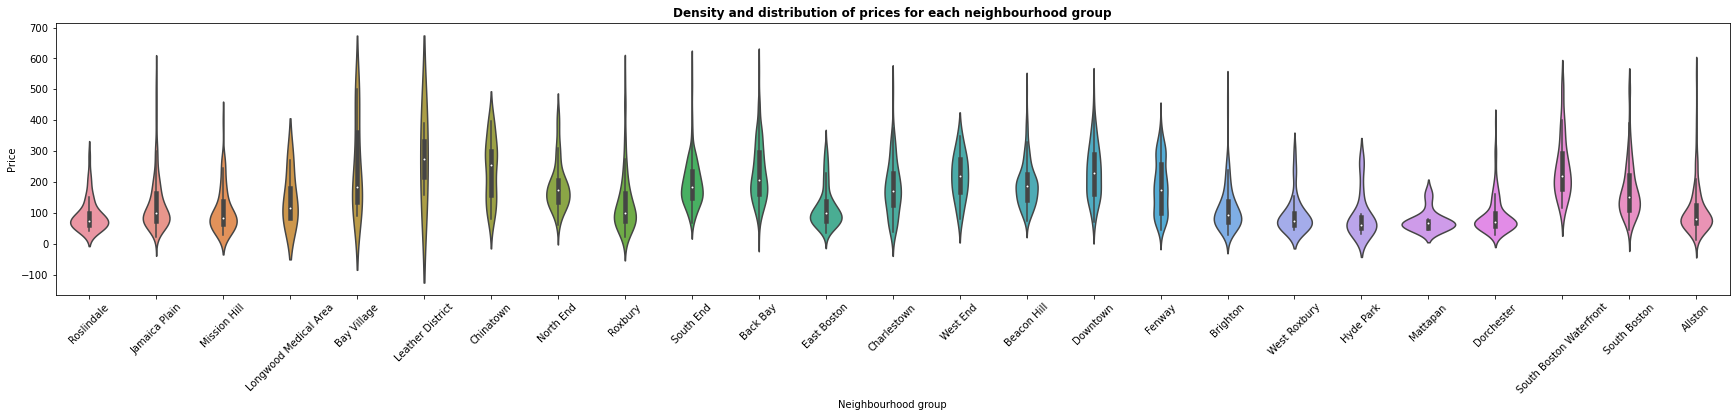

In [358]:
fig,ax = plt.subplots(figsize=(30,5))
plot_distribution('Boston',bos,600)

##### In this graph, we plot the density and distribution of prices for each neighbourhood group. We notice that in Boston, the prices vary much more than in NYC, since some violin plots are super slim and long, while others are concentrated and short.

### 2.2.3 Neighbourhood Exploration

#### a) Popular neighbourhoods 

/Users/kristallqiu/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


(<Figure size 2160x360 with 1 Axes>,
 <AxesSubplot:title={'center':'Most Popular Neighbourhood in Boston'}, xlabel='Number of guest hosted in this Area', ylabel='Neighbourhood area'>)

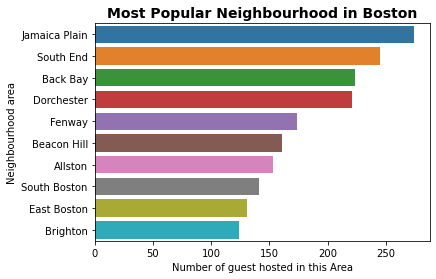

In [359]:
top_nei('Boston',bos)

##### We list top ten most popular neighbourhood in Boston in this horizontal bar chart. The most popular neighbourhood in Boston is Jamaica Plain, but the popularity doesn't vary that much as in NYC.

####  b) Room type within popular neighbourhoods

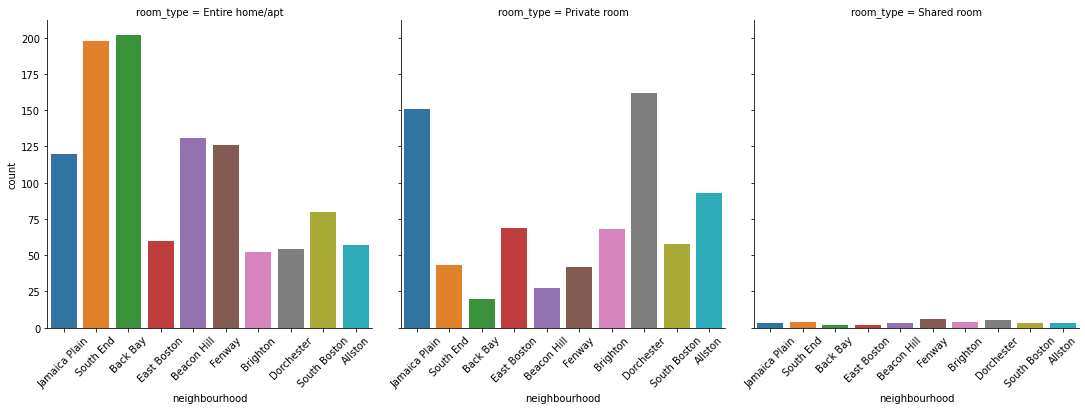

In [360]:
top_nei_room_type('BOS',bos)

##### Based on the top ten popular neighborhood we selected before, we picture the room types information in these neighborhoods for readers' reference. Guests can know the distribution of their favourite room type in popular neighborhoods, so that they can make the decisions more easily.

# 3. Descriptive Data Analysis 

##  3.1 Pairplot of each variable

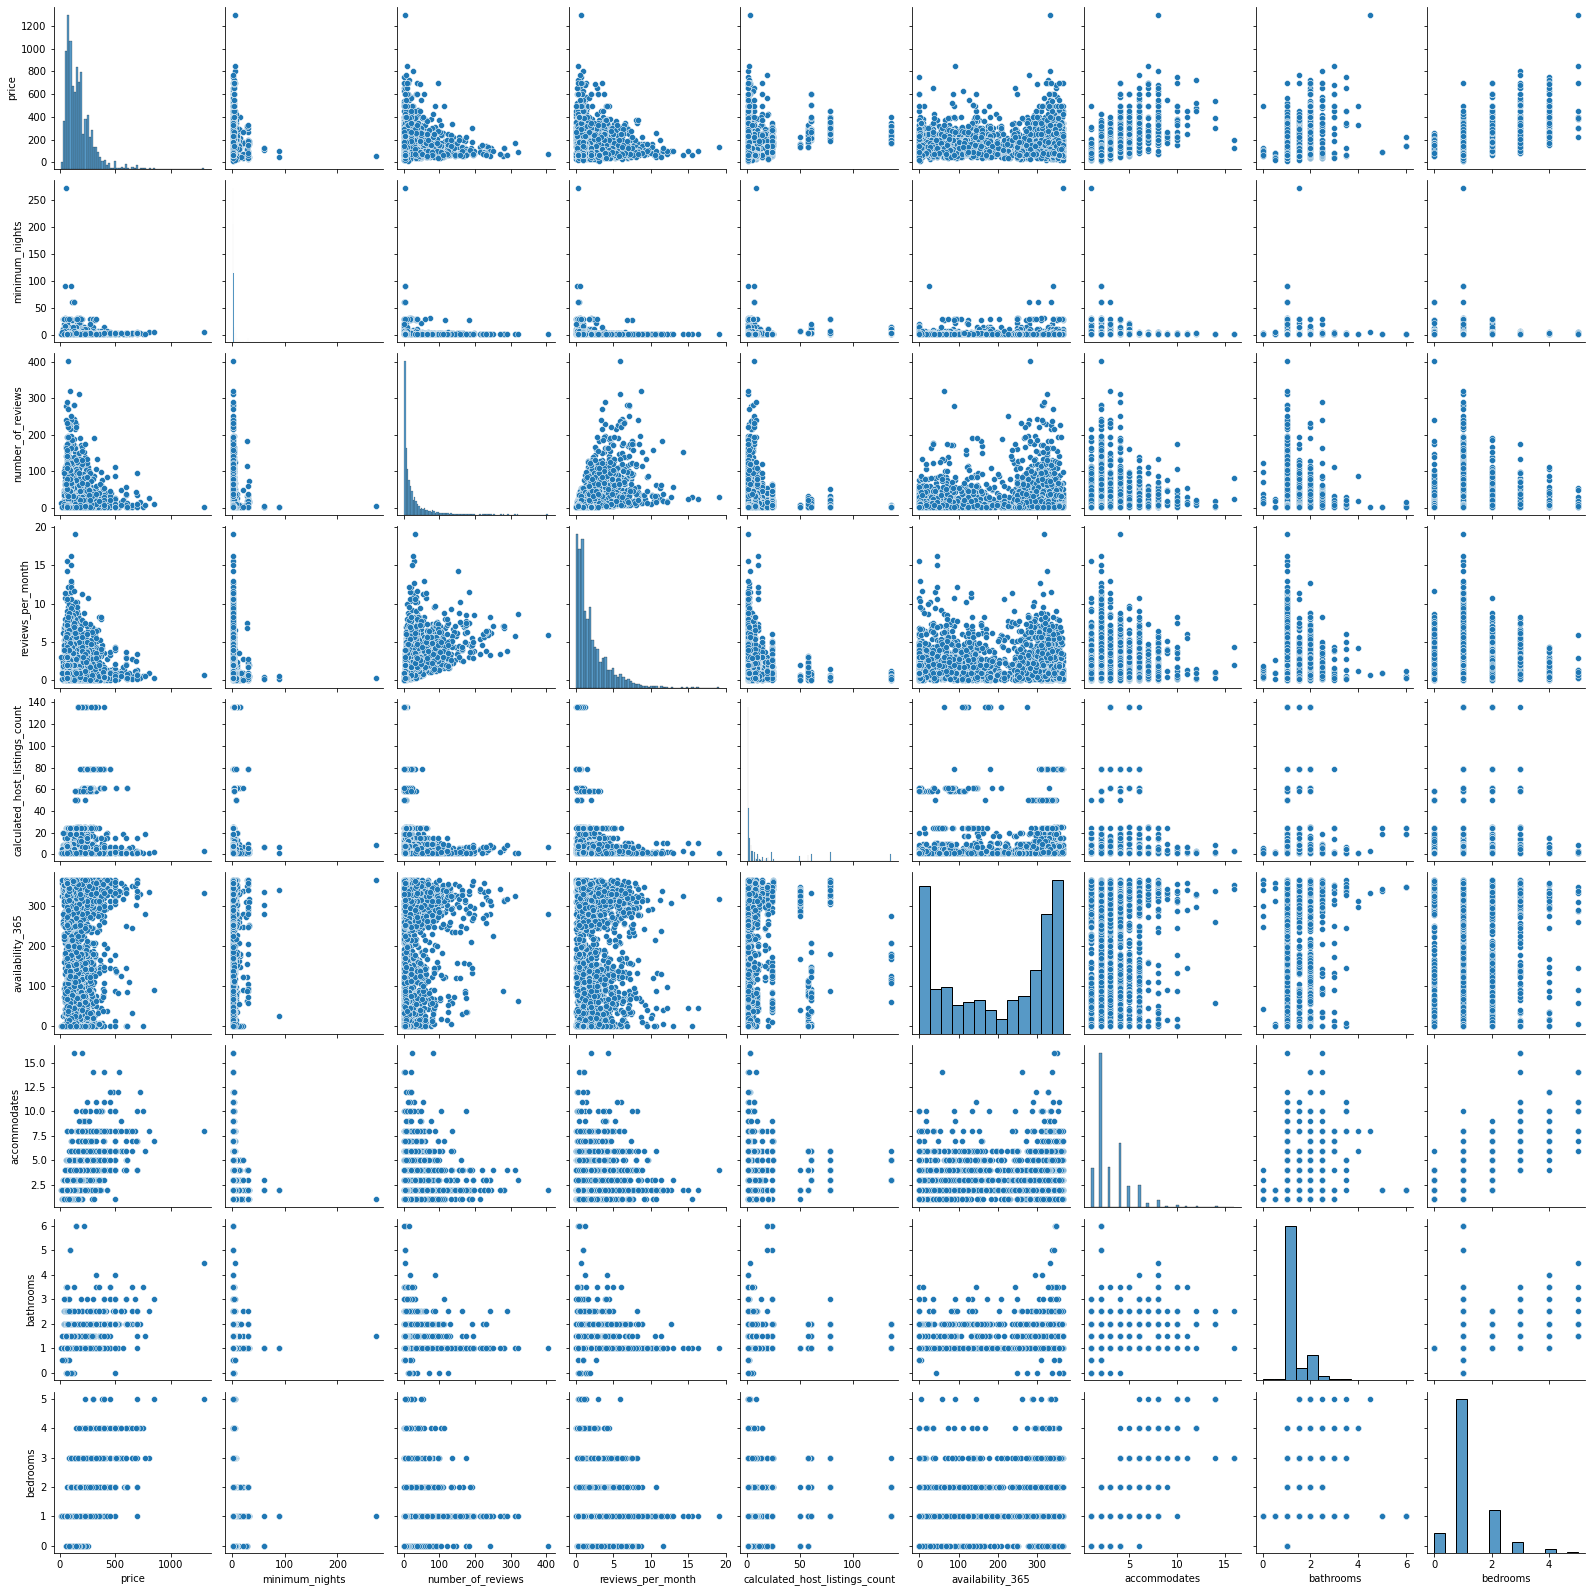

In [361]:
vc = list(nyc.columns)
for i in ['id','host_id','neighbourhood_group','latitude', 'longitude']:
    vc.remove(i)
for j in ['accommodates', 'bathrooms', 'bedrooms']:
    vc.append(j)

pp2 = bos.loc[:,vc]
sns.pairplot(pp2)

##### We can see the correltation between each variable. It does not make sense as many of them are categorical data

# 4. Predictive Data Analysis 

In [362]:
bos.columns

Index(['id', 'host_id', 'host_since', 'host_response_time',
       'host_response_rate', 'host_acceptance_rate', 'host_is_superhost',
       'host_listings_count', 'host_total_listings_count',
       'host_has_profile_pic', 'host_identity_verified', 'street',
       'neighbourhood', 'latitude', 'longitude', 'property_type', 'room_type',
       'accommodates', 'bathrooms', 'bedrooms', 'beds', 'bed_type', 'price',
       'guests_included', 'extra_people', 'minimum_nights', 'maximum_nights',
       'availability_365', 'number_of_reviews', 'cancellation_policy',
       'require_guest_profile_picture', 'require_guest_phone_verification',
       'calculated_host_listings_count', 'reviews_per_month'],
      dtype='object')

In [363]:
model2 = bos.loc[:,:].copy()
model2['neighbourhood'] = model2['neighbourhood'].astype("category").cat.codes
model2['room_type'] = model2['room_type'].astype("category").cat.codes
model2['host_response_time'] = model2['host_response_time'].astype("category").cat.codes
model2['host_response_rate'] = model2['host_response_rate'].str.replace('%','').astype(int)
model2['host_acceptance_rate'] = model2['host_acceptance_rate'].str.replace('%','').astype(int)

model2['host_response_rate'] = model2['host_response_rate']/100
model2['host_acceptance_rate'] = model2['host_acceptance_rate']/100

tf = ['host_is_superhost','host_has_profile_pic','host_identity_verified',
      'require_guest_profile_picture','require_guest_phone_verification']
for c in tf:
    model2[c] = model2[c].replace('t',1)
    model2[c] = model2[c].replace('f',0)

cancel = ['flexible','moderate','strict', 'super_strict_30']
for i in range(0,len(cancel)):    
    model2['cancellation_policy'] = model2['cancellation_policy'].replace(cancel[i],i)


model2['extra_people'] = model2['extra_people'].str.replace('$','').astype(float)
model2['property_type'] = model2['property_type'].astype("category").cat.codes
model2['bed_type'] = model2['bed_type'].astype("category").cat.codes

mean = model2['reviews_per_month'].mean()
model2['reviews_per_month'].fillna(mean, inplace=True)

model2['log_price'] = np.log(model2.price+1)

model2 = model2.drop(columns=['id' ,'host_id','price','host_since','street']) # delete price column

model2.isnull().sum()

host_response_time                   0
host_response_rate                   0
host_acceptance_rate                 0
host_is_superhost                    0
host_listings_count                  0
host_total_listings_count            0
host_has_profile_pic                 0
host_identity_verified               0
neighbourhood                        0
latitude                             0
longitude                            0
property_type                        0
room_type                            0
accommodates                         0
bathrooms                           12
bedrooms                             8
beds                                 6
bed_type                             0
guests_included                      0
extra_people                         0
minimum_nights                       0
maximum_nights                       0
availability_365                     0
number_of_reviews                    0
cancellation_policy                  0
require_guest_profile_pic

#####  Value Reference

In [364]:
bosVF = {}
bosd = ['neighbourhood','room_type','host_response_time',
       'host_is_superhost','cancellation_policy','property_type','bed_type']
for c in bosd:
    bosVF = {}
    for i in model2[c].unique():
        indx = model2[model2[c]==i].index.values[0]
        bosVF[i] = bos[c][indx]
    print(c.capitalize(),'\n',dict(sorted(bosVF.items())))

Neighbourhood 
 {0: 'Allston', 1: 'Back Bay', 2: 'Bay Village', 3: 'Beacon Hill', 4: 'Brighton', 5: 'Charlestown', 6: 'Chinatown', 7: 'Dorchester', 8: 'Downtown', 9: 'East Boston', 10: 'Fenway', 11: 'Hyde Park', 12: 'Jamaica Plain', 13: 'Leather District', 14: 'Longwood Medical Area', 15: 'Mattapan', 16: 'Mission Hill', 17: 'North End', 18: 'Roslindale', 19: 'Roxbury', 20: 'South Boston', 21: 'South Boston Waterfront', 22: 'South End', 23: 'West End', 24: 'West Roxbury'}
Room_type 
 {0: 'Entire home/apt', 1: 'Private room', 2: 'Shared room'}
Host_response_time 
 {0: 'a few days or more', 1: 'within a day', 2: 'within a few hours', 3: 'within an hour'}
Host_is_superhost 
 {0: 'f', 1: 't'}
Cancellation_policy 
 {0: 'flexible', 1: 'moderate', 2: 'strict', 3: 'super_strict_30'}
Property_type 
 {-1: nan, 0: 'Apartment', 1: 'Bed & Breakfast', 2: 'Boat', 3: 'Condominium', 4: 'Dorm', 5: 'Entire Floor', 6: 'Guesthouse', 7: 'House', 8: 'Loft', 9: 'Other', 10: 'Townhouse', 11: 'Villa'}
Bed_type 


In [365]:
model2

host_response_time  host_response_rate  host_acceptance_rate  \
1                      3                1.00                  1.00   
2                      2                1.00                  0.88   
3                      2                1.00                  0.50   
4                      3                1.00                  1.00   
5                      2                1.00                  0.95   
...                  ...                 ...                   ...   
3574                   3                1.00                  1.00   
3575                   3                0.96                  1.00   
3578                   3                1.00                  1.00   
3580                   3                0.96                  1.00   
3583                   3                1.00                  0.96   

      host_is_superhost  host_listings_count  host_total_listings_count  \
1                     0                    1                          1   
2                     1                    1                          1   
3                     0                    1                          1   
4                     1                    1                          1   
5                     1                    2                          2   
...                 ...                  ...                        ...   
3574                  0                    2                          2   
3575                  0                   28                         28   
3578                  0                    4                          4   
3580                  0                   28                         28   
3583                  0                    4                          4   

      host_has_profile_pic  host_identity_verified  neighbourhood   latitude  \
1                        1                       1             18  42.286241   
2                        1                       1             18  42.292438   
3                        1                       0             18  42.281106   
4                        1                       1             18  42.284512   
5                        1                       1             18  42.291690   
...                    ...                     ...            ...        ...   
3574                     1                       0             24  42.303305   
3575                     1                       1              5  42.382681   
3578                     1                       0              0  42.370741   
3580                     1                       1              5  42.380968   
3583                     1                       1              5  42.385226   

      ...  minimum_nights  maximum_nights  availability_365  \
1     ...               2              15               359   
2     ...               3              45               319   
3     ...               1            1125                98   
4     ...               2              31               334   
5     ...               2            1125                58   
...   ...             ...             ...               ...   
3574  ...               1            1125               363   
3575  ...               2            1125               356   
3578  ...               1            1125               315   
3580  ...               2            1125               356   
3583  ...               1              13               253   

      number_of_reviews  cancellation_policy  require_guest_profile_picture  \
1                    36                    1                              0   
2                    41                    1                              1   
3                     1                    1                              0   
4                    29                    0                              0   
5                     8                    0                              0   
...                 ...                  ...                            

## 4.1 Probability distribution

In [366]:
keep_col2 = ['host_response_rate', 'host_acceptance_rate','neighbourhood',
        'property_type', 'room_type', 'accommodates',
       'bathrooms', 'bedrooms', 'beds', 'bed_type', 'extra_people',
        'availability_365', 'number_of_reviews', 'cancellation_policy',
        'calculated_host_listings_count', 'reviews_per_month', 'log_price']

/Users/kristallqiu/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/kristallqiu/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Log-Price Distribution Plot')

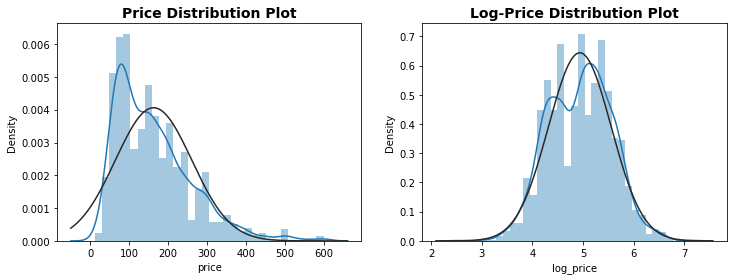

In [367]:
fig,ax = plt.subplots(1,2,figsize=(12,4))
sns.distplot(bos.loc[bos['price']<=600]['price'],fit=norm, ax=ax[0]) # drop extreme values of price which are greater than 600
ax[0].set_title("Price Distribution Plot",size=14, weight='bold')
sns.distplot(model2['log_price'],fit=norm,ax=ax[1])
ax[1].set_title("Log-Price Distribution Plot",size=14, weight='bold')

##### From the log_price distribution plot we learn that the distribution of log_price is approximately normal, also with a mean a little bit less than 5.

## 4.2 Correlation 

Text(0.5, 1.0, 'Correlation Matrix')

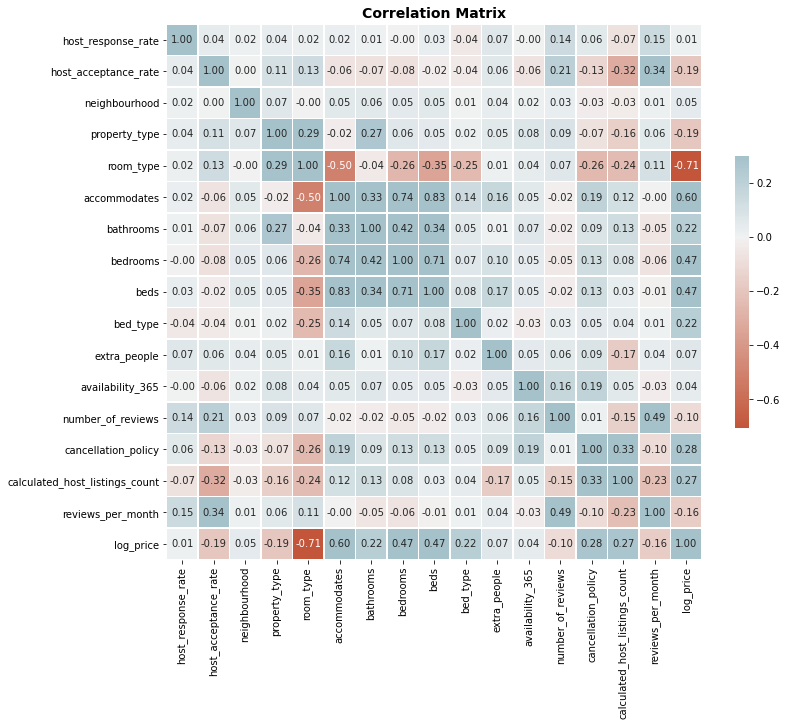

In [368]:
import statsmodels.formula.api as smf
col_df2 = model2.loc[:,keep_col2]
plt.figure(figsize=(12,10))
palette = sns.diverging_palette(20, 220, n=256)
corr=col_df2.corr(method='pearson')
sns.heatmap(corr, annot=True, fmt=".2f", cmap=palette, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}).set(ylim=(17, 0))
plt.title("Correlation Matrix",size=14, weight='bold')

##### In this correlation matrix we calculate and display the correlation between different variables. The hosts can easily find the relationship between variables and make the optimized investment decisions.

## 4.3 Regression

In [369]:
model2['price'] = bos['price']
model2

host_response_time  host_response_rate  host_acceptance_rate  \
1                      3                1.00                  1.00   
2                      2                1.00                  0.88   
3                      2                1.00                  0.50   
4                      3                1.00                  1.00   
5                      2                1.00                  0.95   
...                  ...                 ...                   ...   
3574                   3                1.00                  1.00   
3575                   3                0.96                  1.00   
3578                   3                1.00                  1.00   
3580                   3                0.96                  1.00   
3583                   3                1.00                  0.96   

      host_is_superhost  host_listings_count  host_total_listings_count  \
1                     0                    1                          1   
2                     1                    1                          1   
3                     0                    1                          1   
4                     1                    1                          1   
5                     1                    2                          2   
...                 ...                  ...                        ...   
3574                  0                    2                          2   
3575                  0                   28                         28   
3578                  0                    4                          4   
3580                  0                   28                         28   
3583                  0                    4                          4   

      host_has_profile_pic  host_identity_verified  neighbourhood   latitude  \
1                        1                       1             18  42.286241   
2                        1                       1             18  42.292438   
3                        1                       0             18  42.281106   
4                        1                       1             18  42.284512   
5                        1                       1             18  42.291690   
...                    ...                     ...            ...        ...   
3574                     1                       0             24  42.303305   
3575                     1                       1              5  42.382681   
3578                     1                       0              0  42.370741   
3580                     1                       1              5  42.380968   
3583                     1                       1              5  42.385226   

      ...  maximum_nights  availability_365  number_of_reviews  \
1     ...              15               359                 36   
2     ...              45               319                 41   
3     ...            1125                98                  1   
4     ...              31               334                 29   
5     ...            1125                58                  8   
...   ...             ...               ...                ...   
3574  ...            1125               363                  1   
3575  ...            1125               356                  6   
3578  ...            1125               315                  2   
3580  ...            1125               356                  4   
3583  ...              13               253                  2   

      cancellation_policy  require_guest_profile_picture  \
1                       1                              0   
2                       1                              1   
3                       1                              0   
4                       0                              0   
5                       0                              0   
...                   ...                            ...   
3574                    1                              0   
3575                    2     

### 4.3.1 Linear Regression

In [370]:
import statsmodels.formula.api as smf

#### a) Price - all variables

In [371]:
reg_price = smf.ols('price ~ host_response_rate + host_acceptance_rate + neighbourhood + property_type + room_type + accommodates + bathrooms + bedrooms + beds + bed_type + extra_people + availability_365 + number_of_reviews + cancellation_policy + calculated_host_listings_count + reviews_per_month'
                    ,data=model2).fit()

print(reg_price.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.559
Model:                            OLS   Adj. R-squared:                  0.557
Method:                 Least Squares   F-statistic:                     202.6
Date:                Wed, 04 Nov 2020   Prob (F-statistic):               0.00
Time:                        11:48:37   Log-Likelihood:                -14700.
No. Observations:                2571   AIC:                         2.943e+04
Df Residuals:                    2554   BIC:                         2.953e+04
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept   

##### Here we run an ordinary least square regression for price on several factors that we think may influence the price of Airbnb. We have H0: beta = 0 against H1: beta != 0  for every beta in this regression model. According to the output table, the P-values of  host_acceptance_rate, neighbourhood, bed_type, extra_people, cancellation_policy are bigger than 5%, which means that we don't reject H0 against H1. There is no evidence that the effect of host_acceptance_rate, neighbourhood, bed_type, extra_people, cancellation_policy is significant to the price of Airbnb house and we should drop them. 

#### a) Price - drop variables

In [372]:
reg_price = smf.ols('price ~ host_response_rate +property_type + room_type + accommodates + bathrooms + bedrooms + beds + availability_365 + number_of_reviews + calculated_host_listings_count + reviews_per_month'
                    ,data=model2).fit()

print(reg_price.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.558
Model:                            OLS   Adj. R-squared:                  0.556
Method:                 Least Squares   F-statistic:                     293.7
Date:                Wed, 04 Nov 2020   Prob (F-statistic):               0.00
Time:                        11:48:37   Log-Likelihood:                -14704.
No. Observations:                2571   AIC:                         2.943e+04
Df Residuals:                    2559   BIC:                         2.950e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept   

##### And, we can get price = 51.3141 + 37.1538* host_response_rate - property_type* 1.962-room_type* 81.4652 + accommodates*  5.4658 + bathrooms* 32.8821 + bedrooms* 40.0036 + beds* 5.9266+availability_365* 0.0467-number_of_reviews* 0.1042 + calculated_host_listings_count* 0.2824 - reviews_per_month* 3.7074 

##### And from this, we can find that bedrooms make the largest contribution to a relative higher price.

#### b) log_price - all vairables

In [373]:
reg_price = smf.ols('log_price ~ host_response_rate + host_acceptance_rate + neighbourhood + property_type + room_type + accommodates + bathrooms + bedrooms + beds + bed_type + extra_people + availability_365 + number_of_reviews + cancellation_policy + calculated_host_listings_count + reviews_per_month'
                    ,data=model2).fit()

print(reg_price.summary())

                            OLS Regression Results                            
Dep. Variable:              log_price   R-squared:                       0.623
Model:                            OLS   Adj. R-squared:                  0.621
Method:                 Least Squares   F-statistic:                     263.9
Date:                Wed, 04 Nov 2020   Prob (F-statistic):               0.00
Time:                        11:48:37   Log-Likelihood:                -1165.0
No. Observations:                2571   AIC:                             2364.
Df Residuals:                    2554   BIC:                             2464.
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept   

##### Here we run an ordinary least square regression for price on several factors again after drop those variables. We have H0: beta = 0 against H1: beta != 0  for every beta in this regression model. According to the output table, the P-value of beds and number_of_reviews are bigger than 5%, which means that we don't reject H0 against H1. There is no evidence that the effect of beds and number_of_reviews is significant to the price of Airbnb house and we should drop them. 

#### b) log_price - drop variables

In [374]:
reg_price = smf.ols('log_price ~ host_response_rate + host_acceptance_rate + neighbourhood + property_type + room_type + accommodates + bathrooms + bedrooms + bed_type + extra_people + availability_365 + cancellation_policy + calculated_host_listings_count + reviews_per_month'
                    ,data=model2).fit()

print(reg_price.summary())

                            OLS Regression Results                            
Dep. Variable:              log_price   R-squared:                       0.623
Model:                            OLS   Adj. R-squared:                  0.621
Method:                 Least Squares   F-statistic:                     301.7
Date:                Wed, 04 Nov 2020   Prob (F-statistic):               0.00
Time:                        11:48:37   Log-Likelihood:                -1167.0
No. Observations:                2573   AIC:                             2364.
Df Residuals:                    2558   BIC:                             2452.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept   

##### And, we can get log_price = 4.5540 + host_response_rate* 0.2136 - property_type* 0.0107-room_type* 0.6220 + accommodates* 0.0593 + bathrooms* 0.0890 + bedrooms* 0.1315 - beds* 0.0031 + availability_365* 0.0002 + calculated_host_listings_count* 0.0019 - reviews_per_month* 0.0201
##### We find that different from price, host_reponse_rate has the greatest relevance of the log_price.

##### We run linear regression on log_price against the factors remained.

### 4.3.2 ML

##### From the linear regression we found that log_price is a better dependent variable to predict.

In [375]:
from sklearn.model_selection import train_test_split

In [376]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(model2[['room_type']].values, model2[['log_price']].values,
                                        test_size=0.25, random_state=0)

#### a) K-Nearest Neighbors

In [377]:
from sklearn.neighbors import KNeighborsRegressor as knn
from sklearn.model_selection import cross_val_score

In [378]:
scores = pd.Series()
for i in range(20,1000,40):
    scores[str(i)] = cross_val_score(knn(n_neighbors=i),
                    X_train2, y_train2,cv=5).mean()
indx = scores.idxmax()

<ipython-input-378-8d5994fa6407>:1: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  scores = pd.Series()


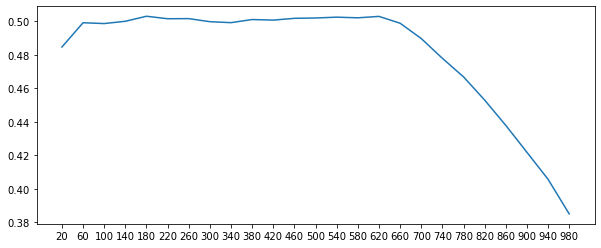

In [379]:
fig,ax = plt.subplots(figsize=(10,4))
plt.plot(scores.index,scores.values)

In [380]:
skl_knn = knn(n_neighbors=int(indx)).fit(X_train2, y_train2)
knn_score2 = skl_knn.score(X_test2, y_test2)
print(knn_score2)

0.5225235361166825


#### b) Random Forest

In [381]:
from sklearn.ensemble import RandomForestRegressor as rf

In [382]:
cross_val_score(rf(n_estimators=100,max_depth=3),X_train2, y_train2.ravel(),cv=5).mean()

0.5032555039276142

In [383]:
cv_scores = pd.DataFrame()
for i in range(1,25):
    cv_scores.loc[i,'rf'] = cross_val_score(rf(n_estimators=100,max_depth=i),X_train2, y_train2.ravel(),cv=5).mean()

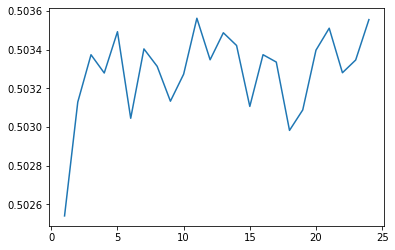

In [384]:
ax = cv_scores.plot()
ax.get_legend().remove()

In [385]:
indx = scores.idxmax()
skl_rf = rf(n_estimators=100,max_depth=int(indx)).fit(X_train2, y_train2.ravel())
skl_rf.predict(X_test2)
rf_score2 = skl_rf.score(X_test2,y_test2)
print(rf_score2)

0.5302768258666375


In [386]:
score_table = pd.DataFrame({'K Nearest Neighbors':[knn_score2],'Random Forest':[rf_score2]})
score_table = score_table.T
score_table.columns = ['Score']
score_table

Score
K Nearest Neighbors  0.522524
Random Forest        0.530277

#####  As we can see from above table, for log_price, we should chooseRandom Forest   as the score of this model is the highest, compared to K Nearest Neighbors.

##### Rank score for log_price : Random Forest  >  KNN



# ➢ San Francisco

# 1. Data

## 1.1 Data Description

In [387]:
sf = import_df('https://raw.githubusercontent.com/kristallqiu99/' +
               'data_bootcamp_final_project/master/sanfrancisco_data/AB_SF_2019.csv')

## 1.2 Data Cleaning

In [388]:
sf.head()

Unnamed: 0    id last_scraped  \
0           0   958     10/14/19   
1           1  3850     10/14/19   
2           2  5858     10/14/19   
3           3  7918     10/14/19   
4           4  8142     10/14/19   

                                                name  \
0                Bright, Modern Garden Unit - 1BR/1B   
1                              Charming room for two   
2                                 Creative Sanctuary   
3         A Friendly Room - UCSF/USF - San Francisco   
4  Friendly Room Apt. Style -UCSF/USF - San Franc...   

                                               space  \
0  Newly remodeled, modern, and bright garden uni...   
1  This room can fit two people. Nobody else will...   
2  We live in a large Victorian house on a quiet ...   
3  Settle down, S.F. resident, student, hospital,...   
4  Settle down, S.F. resident, student, hospital,...   

                                         description  \
0  New update: the house next door is under const...   
1  Your own private room plus access to a shared ...   
2  We live in a large Victorian house on a quiet ...   
3  Nice and good public transportation.  7 minute...   
4  Nice and good public transportation.  7 minute...   

                               neighborhood_overview  \
0  *Quiet cul de sac in friendly neighborhood *St...   
1  This is a quiet, safe neighborhood on a substa...   
2  I love how our neighborhood feels quiet but is...   
3  Shopping old town, restaurants, McDonald, Whol...   
4                                                NaN   

                                               notes  \
0  Due to the fact that we have children and a do...   
1  House Rule footnotes: 1.\tI don’t allow check ...   
2  All the furniture in the house was handmade so...   
3  Wi-Fi signal in common areas.   Large eat in k...   
4  Wi-Fi signal in common areas.   Large eat in k...   

                                             transit  \
0  *Public Transportation is 1/2 block away.  *Ce...   
1  Public transit service to my house is outstand...   
2  The train is two blocks away and you can stop ...   
3         N Juda Muni and bus stop.  Street parking.   
4  N Juda Muni, Bus and UCSF Shuttle. small shopp...   

                                              access  ...  \
0  *Full access to patio and backyard (shared wit...  ...   
1  During the hours of 7:00 to 22:00, your access...  ...   
2  Our deck, garden, gourmet kitchen and extensiv...  ...   
3                                                NaN  ...   
4                                                NaN  ...   

  review_scores_cleanliness review_scores_checkin  \
0                      10.0                  10.0   
1                      10.0                  10.0   
2                      10.0                  10.0   
3                       8.0                   9.0   
4                       9.0                  10.0   

   review_scores_communication review_scores_location  review_scores_value  \
0                         10.0                   10.0                  9.0   
1                         10.0                   10.0                 10.0   
2                         10.0                   10.0                  9.0   
3                          9.0                    9.0                  8.0   
4                         10.0                    9.0                  9.0   

  requires_license require_guest_profile_picture  \
0                t                             f   
1                t                             f   
2                t                             f   
3                t                             f   
4                t                             f   

  require_guest_phone_verification calculated_host_listings_count  \
0                                f                              1   
1                                f                              3   
2                                f                              1   
3                   

In [389]:
var_col2 = []
for var in var_col:
    if var in sf.columns:
        var_col2.append(var)
    else:
        print(var)

host_since
host_response_time
host_acceptance_rate
host_is_superhost
host_listings_count
street
number_of_reviews
cancellation_policy


In [390]:
sf = sf.loc[:,var_col2]
sf.rename(columns={'neighbourhood_cleansed':'neighbourhood'}, inplace=True)

In [391]:
sf.isnull().sum()

id                                     0
host_id                                0
host_response_rate                   927
host_total_listings_count              8
host_has_profile_pic                   8
host_identity_verified                 8
neighbourhood                          0
latitude                               0
longitude                              0
property_type                          0
room_type                              0
accommodates                           0
bathrooms                             12
bedrooms                               4
beds                                   9
bed_type                               0
price                                  0
guests_included                        0
extra_people                           0
minimum_nights                         0
maximum_nights                         0
availability_365                       0
require_guest_profile_picture          0
require_guest_phone_verification       0
calculated_host_

In [392]:
sf.dropna(subset=['reviews_per_month','host_response_rate'],inplace=True) 
sf

id    host_id host_response_rate  host_total_listings_count  \
0          958       1169               100%                        1.0   
1         3850       4921               100%                        2.0   
2         5858       8904                80%                        2.0   
3         7918      21994                86%                       10.0   
4         8142      21994                86%                       10.0   
...        ...        ...                ...                        ...   
7978  38984642   25150753               100%                        1.0   
7979  38985258  298699757               100%                        0.0   
7998  39059847  222647651               100%                        0.0   
8042  39225180     534450                90%                        0.0   
8053  39258642  158118568                83%                        0.0   

     host_has_profile_pic host_identity_verified     neighbourhood  latitude  \
0                       t                      t  Western Addition  37.76931   
1                       t                      t      Inner Sunset  37.75402   
2                       t                      t    Bernal Heights  37.74511   
3                       t                      t    Haight Ashbury  37.76669   
4                       t                      t    Haight Ashbury  37.76487   
...                   ...                    ...               ...       ...   
7978                    t                      t        Ocean View  37.72484   
7979                    t                      f           Bayview  37.73205   
7998                    t                      f         Excelsior  37.71753   
8042                    t                      t      Outer Sunset  37.75620   
8053                    t                      f      Potrero Hill  37.75818   

      longitude property_type  ...  price  guests_included  extra_people  \
0    -122.43386     Apartment  ...  170.0                2       $25.00    
1    -122.45805         House  ...   99.0                2       $20.00    
2    -122.42102     Apartment  ...  235.0                2        $0.00    
3    -122.45250     Apartment  ...   65.0                1       $12.00    
4    -122.45183     Apartment  ...   65.0                1       $12.00    
...         ...           ...  ...    ...              ...           ...   
7978 -122.46670         House  ...   80.0                1       $15.00    
7979 -122.39969   Guest suite  ...  130.0                1        $0.00    
7998 -122.43166         House  ...   50.0                1        $0.00    
8042 -122.49287         House  ...  100.0                1       $30.00    
8053 -122.39412     Apartment  ...   78.0                1        $0.00    

      minimum_nights  maximum_nights availability_365  \
0                  1              30               85   
1                  1               5               62   
2                 30              60                0   
3                 32              60              365   
4                 32              90              365   
...              ...             ...              ...   
7978               1            1125              169   
7979               2              28               83   
7998               1              26               23   
8042               2              60              354   
8053               2              15               51   

      require_guest_profile_picture  require_guest_phone_verification  \
0                                 f                                 f   
1                                 f                                 f   
2                                 f                                 f   
3                                 f                                 f   
4                                 f                                 f   
...                             ...                               ...   
7978                              f      

In [393]:
sf.describe()

id       host_id  host_total_listings_count     latitude  \
count  5.811000e+03  5.811000e+03                5811.000000  5811.000000   
mean   1.793677e+07  5.145251e+07                  50.918258    37.764079   
std    1.176556e+07  7.156662e+07                 250.678348     0.023110   
min    9.580000e+02  4.600000e+01                   0.000000    37.704740   
25%    6.914396e+06  3.832588e+06                   1.000000    37.748545   
50%    1.866994e+07  1.704204e+07                   2.000000    37.764760   
75%    2.803957e+07  6.734331e+07                   6.000000    37.782875   
max    3.925864e+07  2.986998e+08                1735.000000    37.810310   

         longitude  accommodates    bathrooms     bedrooms         beds  \
count  5811.000000   5811.000000  5800.000000  5810.000000  5806.000000   
mean   -122.431986      3.164516     1.381121     1.332874     1.744058   
std       0.027429      1.920302     0.954499     0.917328     1.172295   
min    -122.513060      1.000000     0.000000     0.000000     0.000000   
25%    -122.444835      2.000000     1.000000     1.000000     1.000000   
50%    -122.426500      2.000000     1.000000     1.000000     1.000000   
75%    -122.411225      4.000000     1.500000     2.000000     2.000000   
max    -122.370430     16.000000    14.000000    14.000000    14.000000   

             price  guests_included  minimum_nights  maximum_nights  \
count  5811.000000       5811.00000     5811.000000     5811.000000   
mean    206.403717          1.77164       12.276889      488.804853   
std     247.580653          1.36201       17.176533     1409.003160   
min       0.000000          1.00000        1.000000        1.000000   
25%      99.000000          1.00000        2.000000       28.000000   
50%     147.000000          1.00000        3.000000      120.000000   
75%     230.000000          2.00000       30.000000     1125.000000   
max    8000.000000         12.00000      365.000000   100000.000000   

       availability_365  calculated_host_listings_count  reviews_per_month  
count       5811.000000                     5811.000000        5811.000000  
mean         154.489072                       13.905352           2.008852  
std          129.227578                       40.789751           2.136484  
min            0.000000                        1.000000           0.010000  
25%           34.000000                        1.000000           0.360000  
50%          126.000000                        2.000000           1.170000  
75%          292.000000                        5.000000           3.050000  
max          365.000000                      248.000000          21.190000

# 2. Exploratory Data Analysis

## 2.1 Data Visualization 

### 2.1.1 Location

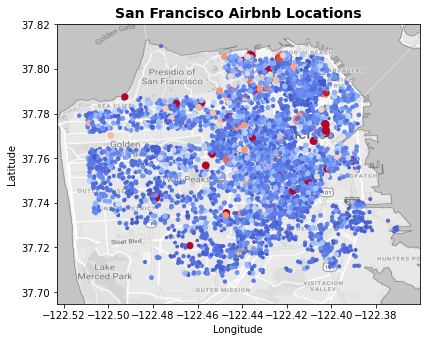

In [394]:
fig,ax = location('San Francisco',sf,0.5,6,6.5,6)
xl,xh,yl,yh = area(sf)
img_sf = import_img('https://raw.githubusercontent.com/kristallqiu99/' +
                    'data_bootcamp_final_project/master/sanfrancisco_data/SF_map.png')
ax.imshow(img_sf,extent=[xl-0.025,xh+0.03,yl-0.015,yh+0.03])

##### In the plot above, the most expensive houses are plotted in red dots and the cheaper ones are plotted in light blue. We learn that in San Francisco, just like in NYC, the most expensive Airbnb houses are located dispersedly, instead of clustering in one specific area.

### 2.1.2 Room Type

#### a) Number of listings of each room type

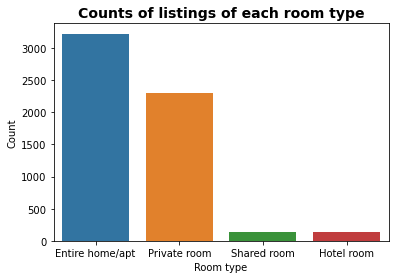

In [395]:
ax = sns.countplot(data=sf,x='room_type')
ax.set_xlabel('Room type')
ax.set_ylabel('Count')
ax.set_title('Counts of listings of each room type',size=14,fontweight='bold')
current_palette = sns.color_palette()

##### From the bar chart above, we know that there are very few shared room as Airbnb offerings in San Francisco. Although there are very few hotel rooms in San Francisco, it is the only city who has this room type among the four major US cities. The major types in San Francisco, entire home/apt is the more than private room, with more than 3500 offerings.

#### b) Spread

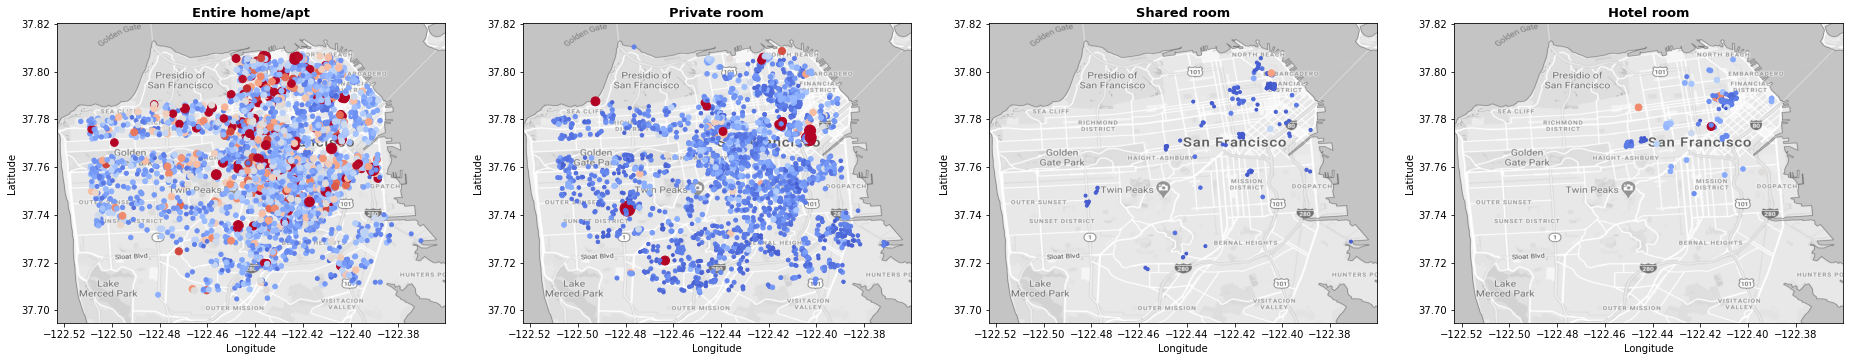

In [396]:
fig,ax = room_type_location(sf,0.6,6,8,8)
for i in range(0,len(sf['room_type'].unique())):
    ax[i].imshow(img_sf,extent=[xl-0.025,xh+0.03,yl-0.015,yh+0.03])

##### Those two major room types distribute evenly in San Francisco, and their locations don't follow some certain patterns.

### 2.1.3 Host

/Users/kristallqiu/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


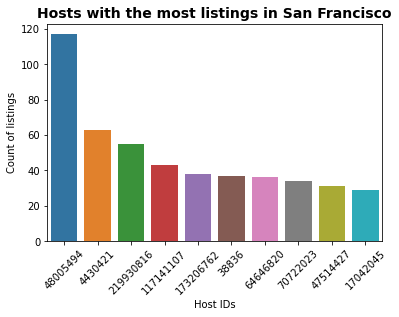

In [397]:
top_hosts('San Francisco',sf)

##### We notice that there is one host with a significantly high number of listings than other hosts in San Francisco, which has listings almost twice as the second host. After that, other hosts all have listings fewer than 70 and the number doesn't different much from each other.

### 2.1.4 Neighbourhood

(<Figure size 1296x360 with 1 Axes>,
 <AxesSubplot:title={'center':'Counts of listings in neighbourhoods'}, xlabel='Neighbourhood group', ylabel='Count'>)

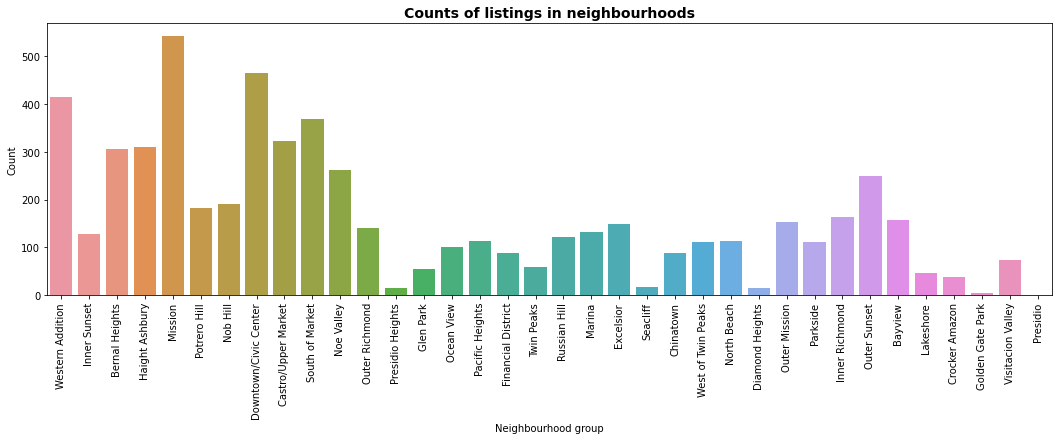

In [398]:
count_nei('San Francisco',sf)

##### From the bar chart above, we learn that most Airbnb houses are located in Mission, followed by Downtown and Western Addition. 

### 2.1.5 Availability

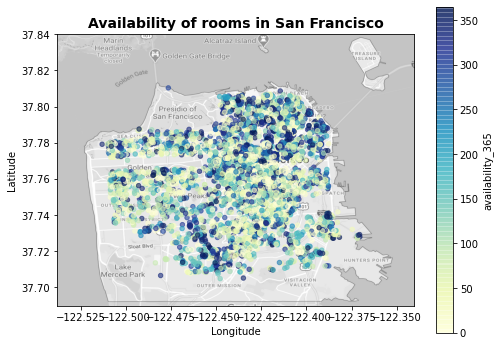

In [399]:
fig,ax = ava365('San Francisco',sf,8,6)
ax.imshow(img_sf,extent=[xl-0.025,xh+0.03,yl-0.015,yh+0.03])

##### In this graph, we plot the availability of rooms in San Francisco. We notice that most rooms are available for fewer than 200 days per year, while there are a few houses that are available for the whole year. We guess that most rooms are made available during peak tourist seasons, but during the tourist-off season, some rooms will not be available since there isn't a very large demand in the market, which is the same as NYC.

## 2.2 Data Analysis

### 2.2.1 Price with room types

In [400]:
rtype = sf['room_type'].unique()
price_list = []
for n in rtype:
    sub = sf.loc[sf['room_type'] == n]
    sub_price = sub[['price']]
    price_list.append(sub_price)
stats_list = []
for p in price_list:
    i = p.describe(percentiles=[.25, .50, .75])
    i = i.iloc[3:]
    i.reset_index(inplace=True)
    i.rename(columns={'index':'Stats'},inplace=True)
    stats_list.append(i)
# change names of the price column to the area name
for i in range(0,len(rtype)):
    stats_list[i].rename(columns={'price':rtype[i]},inplace=True)
# finilize dataframe for final view    
stats_df = stats_list
stats_df = [df.set_index('Stats') for df in stats_df]
stats_df = stats_df[0].join(stats_df[1:])
stats_df

Entire home/apt  Private room  Shared room  Hotel room
Stats                                                        
min               10.0           0.0         27.0       19.00
25%              139.0          76.0         34.0       75.00
50%              195.0         100.0         40.5      100.00
75%              300.0         149.0         50.0      152.25
max             4500.0        8000.0        555.0      999.00

#### a) Density distribution 

Text(0.5, 1.0, 'Density and distribution of prices for each room type')

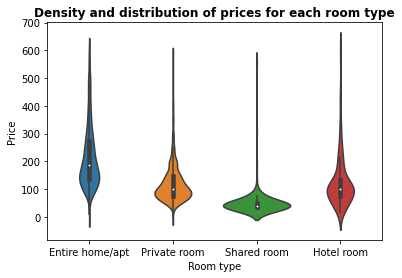

In [401]:
no_extreme = sf[sf.price < 600]    
ax = sns.violinplot(data=no_extreme,x='room_type',y='price')
ax.set_xlabel('Room type')
ax.set_ylabel('Price')
ax.set_title('Density and distribution of prices for each room type',fontweight='bold')

##### From the density distribution, we know that hosts charge a higher price for entire home/apt room type, ranging from less than 100 dollars to more than 400 dollars, even to 500 dollars. On the contrary, most private rooms and hotel rooms are charged a price of around 100 dollars per day. The shared rooms are the cheapest, which are less than 100 dollars.

### 2.2.2 Price with neighbourhoods

In [402]:
nei_stats('San Francisco',sf)

Western Addition  Inner Sunset  Bernal Heights  Haight Ashbury  \
Stats                                                                   
min                33.0          47.0             0.0           31.00   
25%               110.0         105.0           100.0           99.00   
50%               173.5         150.0           145.0          139.00   
75%               275.0         250.0           219.0          223.75   
max              3000.0        2000.0          1850.0         1800.00   

       Mission  Potrero Hill  Nob Hill  Downtown/Civic Center  \
Stats                                                           
min       33.0          39.0      37.0                   19.0   
25%      100.0         125.0      82.0                   80.0   
50%      150.0         175.0     134.0                  117.5   
75%      245.0         271.0     189.0                  199.0   
max     2500.0        4500.0    1250.0                 1200.0   

       Castro/Upper Market  South of Market  ...  Outer Mission  Parkside  \
Stats                                        ...                            
min                  10.00            32.00  ...           33.0      28.0   
25%                 119.00           125.00  ...           75.0      75.0   
50%                 175.00           171.00  ...          110.0     120.0   
75%                 283.75           242.75  ...          177.0     179.0   
max                1450.00          2999.00  ...          995.0    8000.0   

       Inner Richmond  Outer Sunset  Bayview  Lakeshore  Crocker Amazon  \
Stats                                                                     
min             40.00          32.0     36.0       40.0            49.0   
25%            114.50          80.0     69.0       67.0            70.0   
50%            150.00         105.0     99.0      120.0            95.0   
75%            276.25         159.0    135.0      167.5           140.0   
max           1500.00         699.0    475.0      500.0           450.0   

       Golden Gate Park  Visitacion Valley  Presidio  
Stats                                                 
min               125.0               50.0     105.0  
25%               170.0               85.0     105.0  
50%               190.0              116.5     105.0  
75%               368.5              160.0     105.0  
max               889.0              990.0     105.0  

[5 rows x 36 columns]

#### a) Density distribution

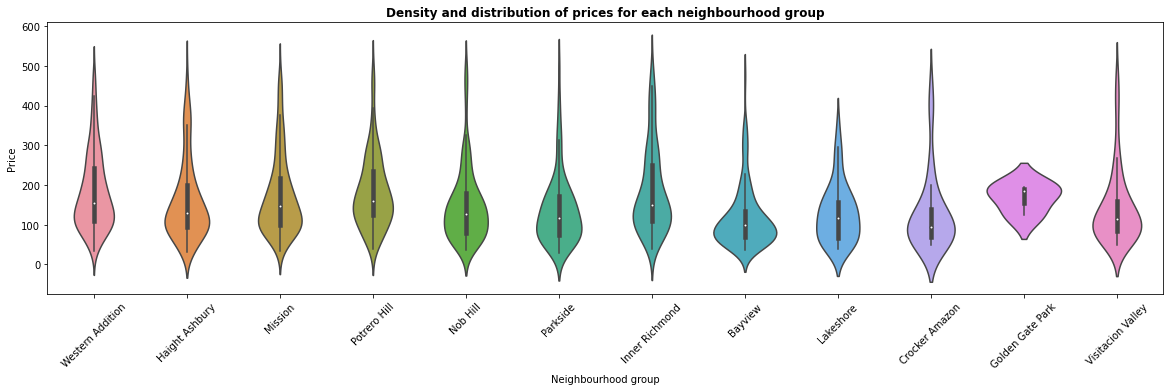

In [403]:
sfnei = ['Western Addition','Haight Ashbury','Mission','Potrero Hill','Nob Hill','Golden Gate Park',
        'Parkside','Inner Richmond','Visitacion Valley','Bayview','Lakeshore','Crocker Amazon']
sf_density = sf.loc[sf['neighbourhood'].isin(sfnei),:]
fig,ax = plt.subplots(figsize=(20,5))
ax = plot_distribution('San Francisco',sf_density,500)

##### We see the prices vary a lot in some neighborhood, and price of rooms in inner richmond vary the most.

### 2.2.3 Neighbourhood Exploration

#### a) Popular neighbourhoods

/Users/kristallqiu/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


(<Figure size 1440x360 with 1 Axes>,
 <AxesSubplot:title={'center':'Most Popular Neighbourhood in San Francisco'}, xlabel='Number of guest hosted in this Area', ylabel='Neighbourhood area'>)

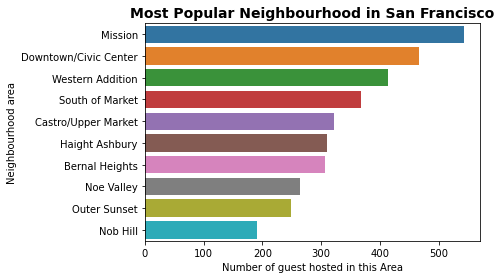

In [404]:
top_nei('San Francisco',sf)

##### We list top ten most popular neighbourhood in San Francisco in this horizontal bar chart. The most popular one is Mission, followed by Downtown and Western Addition.

####  b) Room type within popular neighbourhoods

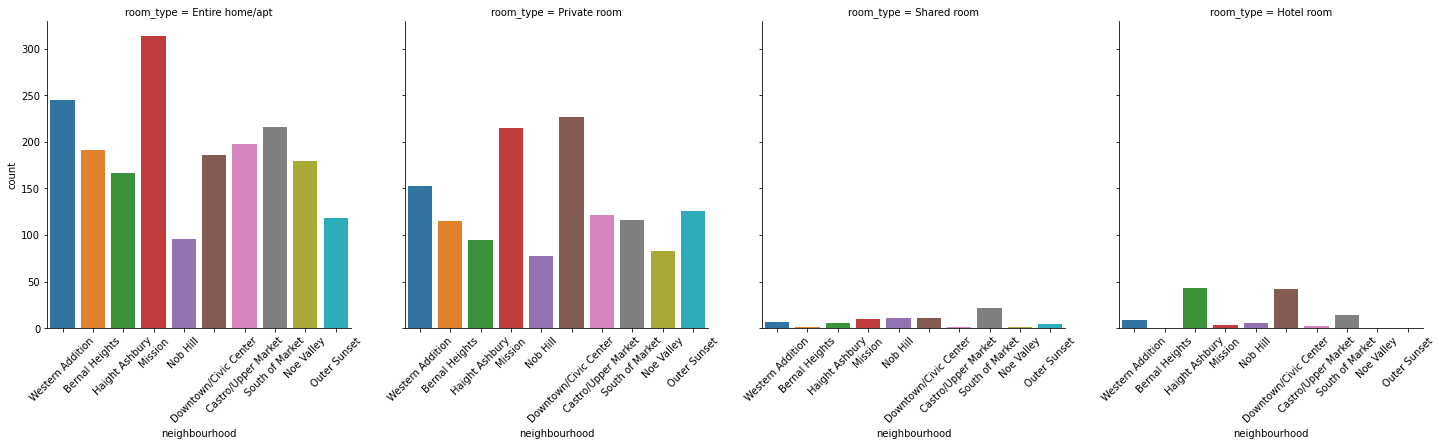

In [405]:
top_nei_room_type('San Francisco',sf)

##### Based on the top ten popular neighborhood we selected before, we picture the room types information in these neighborhoods for readers' reference. Guests can know the distribution of their favourite room type in popular neighborhoods, so that they can make the decisions more easily.

# 3. Descriptive Data Analysis

## 3.1 Pairplot of each variable

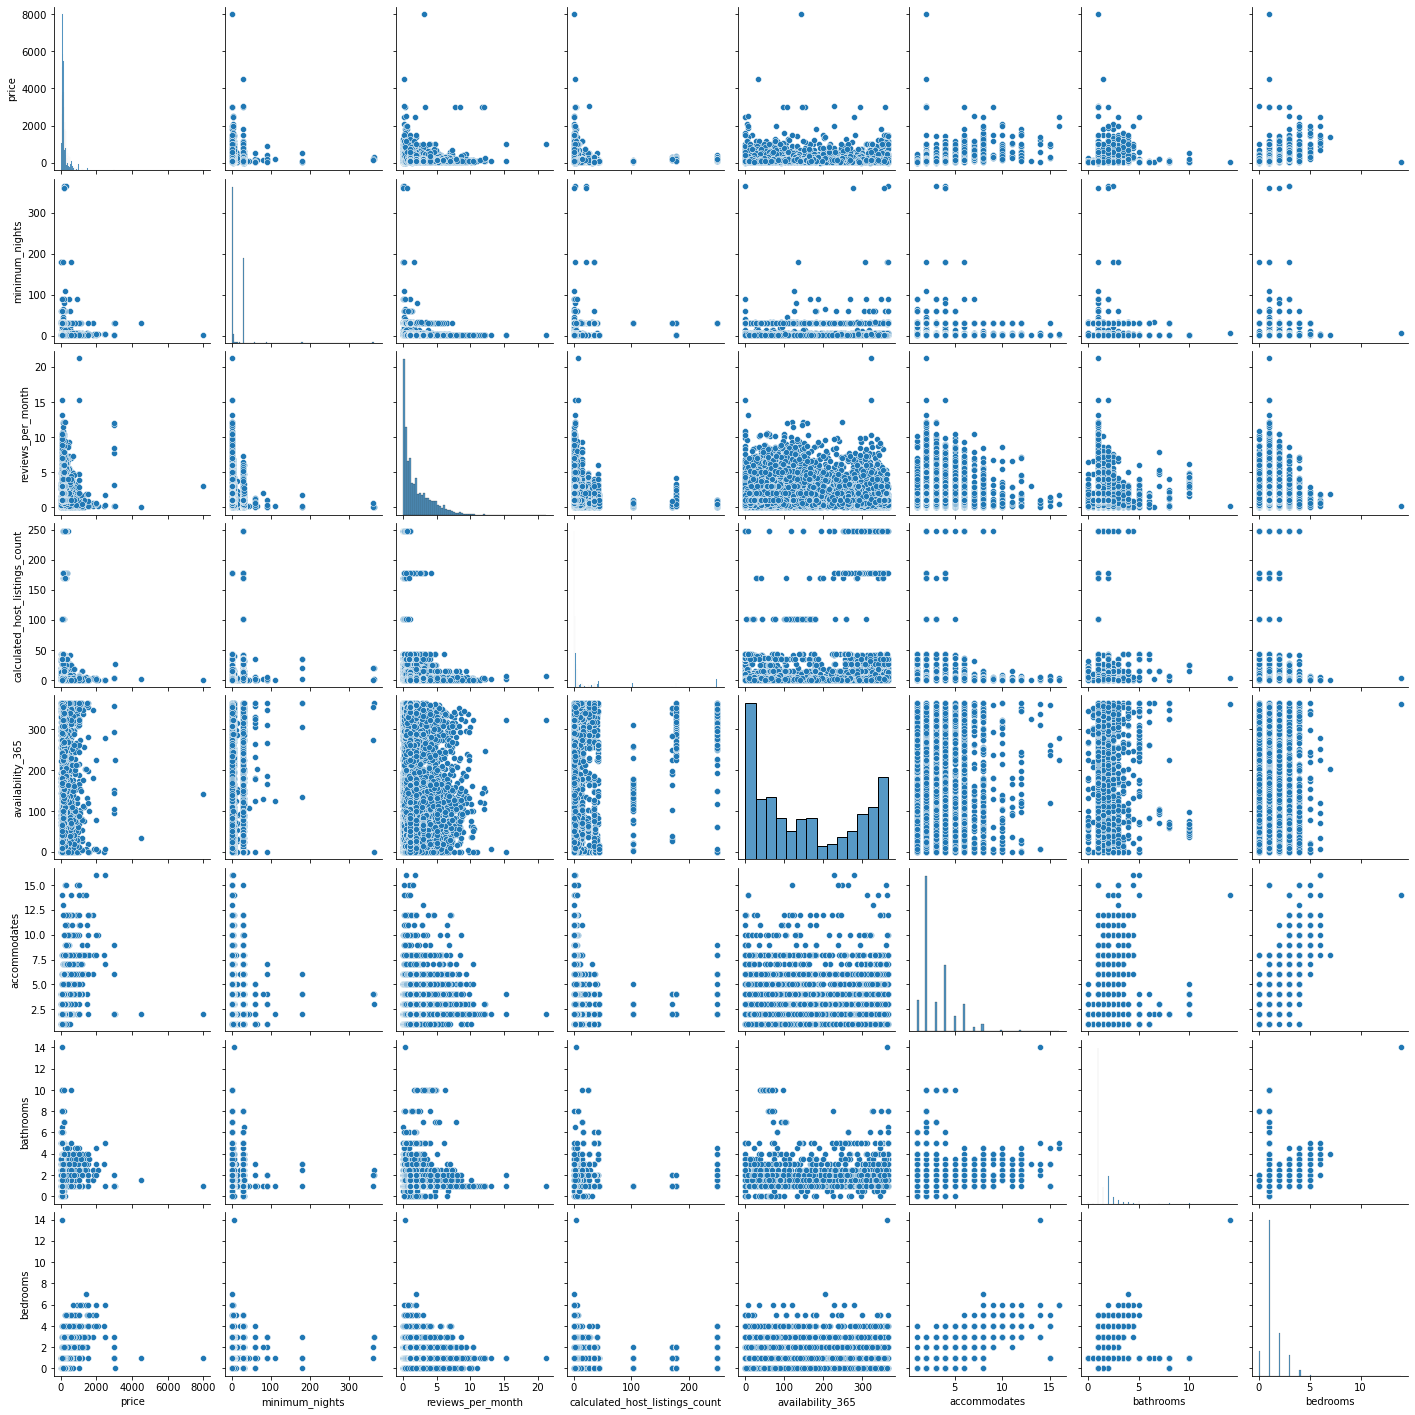

In [406]:
vc = list(nyc.columns)
for i in ['id','host_id','neighbourhood_group','latitude', 'longitude','number_of_reviews']:
    vc.remove(i)
for j in ['accommodates', 'bathrooms', 'bedrooms']:
    vc.append(j)

pp3 = sf.loc[:,vc]
sns.pairplot(pp3)

##### We can see the correltation between each variable. It does not make sense as many of them are categorical data

# 4. Predictive Data Analysis


In [407]:
sf.columns

Index(['id', 'host_id', 'host_response_rate', 'host_total_listings_count',
       'host_has_profile_pic', 'host_identity_verified', 'neighbourhood',
       'latitude', 'longitude', 'property_type', 'room_type', 'accommodates',
       'bathrooms', 'bedrooms', 'beds', 'bed_type', 'price', 'guests_included',
       'extra_people', 'minimum_nights', 'maximum_nights', 'availability_365',
       'require_guest_profile_picture', 'require_guest_phone_verification',
       'calculated_host_listings_count', 'reviews_per_month'],
      dtype='object')

In [408]:
model3 = sf.loc[:,:].copy()
model3['neighbourhood'] = model3['neighbourhood'].astype("category").cat.codes
model3['room_type'] = model3['room_type'].astype("category").cat.codes

model3['host_response_rate'] = model3['host_response_rate'].str.replace('%','').astype(int)
model3['host_response_rate'] = model3['host_response_rate']/100

tf = ['host_has_profile_pic','host_identity_verified',
      'require_guest_profile_picture','require_guest_phone_verification']
for c in tf:
    model3[c] = model3[c].replace('t',1)
    model3[c] = model3[c].replace('f',0)

model3['bed_type'] = model3['bed_type'].astype("category").cat.codes
model3['extra_people'] = model3['extra_people'].str.replace('$','').astype(float)
model3['property_type'] = model3['property_type'].astype("category").cat.codes


mean = model3['reviews_per_month'].mean()
model3['reviews_per_month'].fillna(mean, inplace=True)

model3['log_price'] = np.log(model3.price+1)

model3 = model3.drop(columns=['id','host_id','price','latitude','longitude','minimum_nights','maximum_nights']) # delete price column

model3.isnull().sum()

host_response_rate                   0
host_total_listings_count            0
host_has_profile_pic                 0
host_identity_verified               0
neighbourhood                        0
property_type                        0
room_type                            0
accommodates                         0
bathrooms                           11
bedrooms                             1
beds                                 5
bed_type                             0
guests_included                      0
extra_people                         0
availability_365                     0
require_guest_profile_picture        0
require_guest_phone_verification     0
calculated_host_listings_count       0
reviews_per_month                    0
log_price                            0
dtype: int64

In [409]:
model3.columns

Index(['host_response_rate', 'host_total_listings_count',
       'host_has_profile_pic', 'host_identity_verified', 'neighbourhood',
       'property_type', 'room_type', 'accommodates', 'bathrooms', 'bedrooms',
       'beds', 'bed_type', 'guests_included', 'extra_people',
       'availability_365', 'require_guest_profile_picture',
       'require_guest_phone_verification', 'calculated_host_listings_count',
       'reviews_per_month', 'log_price'],
      dtype='object')

#####  Value Reference

In [410]:
sfVF = {}
sfd = ['neighbourhood','room_type','host_has_profile_pic','property_type','bed_type']
for c in sfd:
    sfVF = {}
    for i in model3[c].unique():
        indx = model3[model3[c]==i].index.values[0]
        sfVF[i] = sf[c][indx]
    print(c.capitalize(),'\n',dict(sorted(sfVF.items())))

Neighbourhood 
 {0: 'Bayview', 1: 'Bernal Heights', 2: 'Castro/Upper Market', 3: 'Chinatown', 4: 'Crocker Amazon', 5: 'Diamond Heights', 6: 'Downtown/Civic Center', 7: 'Excelsior', 8: 'Financial District', 9: 'Glen Park', 10: 'Golden Gate Park', 11: 'Haight Ashbury', 12: 'Inner Richmond', 13: 'Inner Sunset', 14: 'Lakeshore', 15: 'Marina', 16: 'Mission', 17: 'Nob Hill', 18: 'Noe Valley', 19: 'North Beach', 20: 'Ocean View', 21: 'Outer Mission', 22: 'Outer Richmond', 23: 'Outer Sunset', 24: 'Pacific Heights', 25: 'Parkside', 26: 'Potrero Hill', 27: 'Presidio', 28: 'Presidio Heights', 29: 'Russian Hill', 30: 'Seacliff', 31: 'South of Market', 32: 'Twin Peaks', 33: 'Visitacion Valley', 34: 'West of Twin Peaks', 35: 'Western Addition'}
Room_type 
 {0: 'Entire home/apt', 1: 'Hotel room', 2: 'Private room', 3: 'Shared room'}
Host_has_profile_pic 
 {0: 'f', 1: 't'}
Property_type 
 {0: 'Aparthotel', 1: 'Apartment', 2: 'Bed and breakfast', 3: 'Boutique hotel', 4: 'Bungalow', 5: 'Cabin', 6: 'Cast

## 4.1 Probability distribution

/Users/kristallqiu/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/kristallqiu/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Log-Price Distribution Plot')

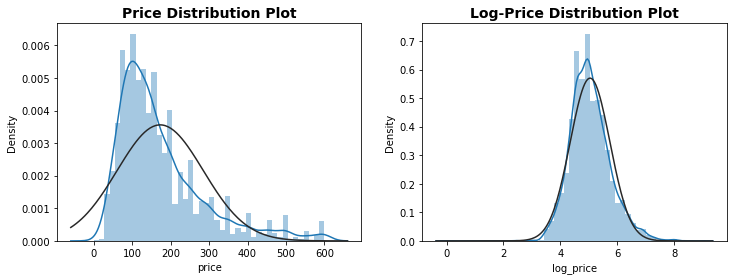

In [411]:
fig,ax = plt.subplots(1,2,figsize=(12,4))
sns.distplot(sf.loc[sf['price']<=600]['price'],fit=norm, ax=ax[0]) # drop extreme values of price which are greater than 600
ax[0].set_title("Price Distribution Plot",size=14, weight='bold')
sns.distplot(model3['log_price'],fit=norm,ax=ax[1])
ax[1].set_title("Log-Price Distribution Plot",size=14, weight='bold')

##### We learn from the log_price distribution plot that the log_price of San Francisco is also aprroximitely normally distributed with a mean around 5. But it is less deviated, since we can know that the standard deviation is smaller than that of NYC and Boston.

##  4.2 Correlation

In [412]:
keep_col3 = ['host_response_rate', 'neighbourhood',
        'property_type', 'room_type', 'accommodates',
       'bathrooms', 'bedrooms', 'beds', 'bed_type', 'extra_people','availability_365', 
        'calculated_host_listings_count', 'reviews_per_month', 'log_price']

Text(0.5, 1.0, 'Correlation Matrix')

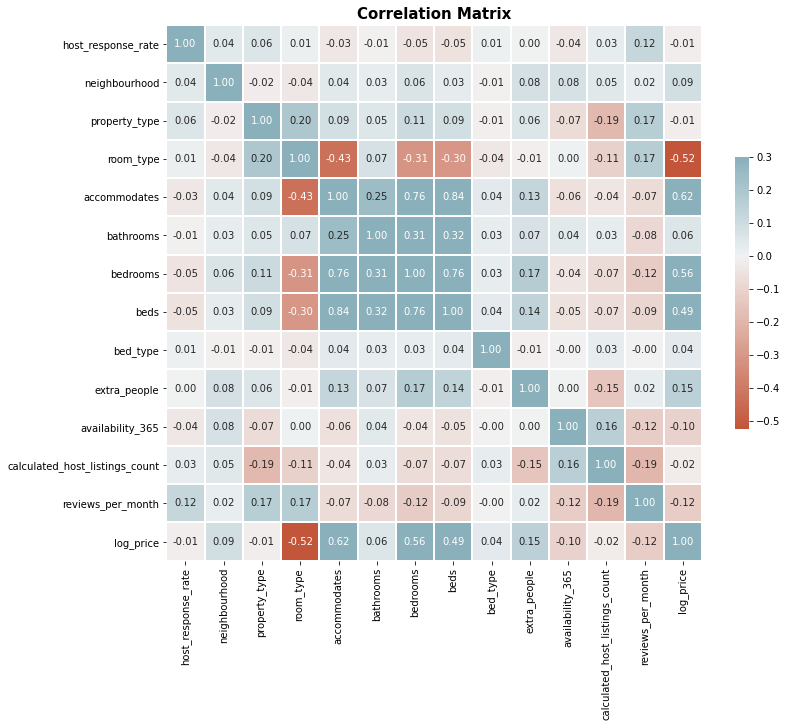

In [413]:
cordf3 = model3.loc[:,keep_col3]
plt.figure(figsize=(12,10))
palette = sns.diverging_palette(20, 220, n=256)
corr = cordf3.corr(method='pearson')
sns.heatmap(corr, annot=True, fmt=".2f", cmap=palette, vmax=.3, center=0,
            square=True, linewidths=1, cbar_kws={"shrink": .5}).set(ylim=(14, 0))
plt.title("Correlation Matrix",size=15, weight='bold')

##### In this correlation matrix we calculate and display the correlation between different variables. The hosts can easily find the relationship between variables and make the optimized investment decisions.

## 4.3 Regression

In [414]:
model3['price'] = sf['price']
model3.head(5)

host_response_rate  host_total_listings_count  host_has_profile_pic  \
0                1.00                        1.0                     1   
1                1.00                        2.0                     1   
2                0.80                        2.0                     1   
3                0.86                       10.0                     1   
4                0.86                       10.0                     1   

   host_identity_verified  neighbourhood  property_type  room_type  \
0                       1             35              1          0   
1                       1             13             15          2   
2                       1              1              1          0   
3                       1             11              1          2   
4                       1             11              1          2   

   accommodates  bathrooms  bedrooms  ...  bed_type  guests_included  \
0             3        1.0       1.0  ...         4                2   
1             2        1.0       1.0  ...         4                2   
2             5        1.0       2.0  ...         4                2   
3             2        4.0       1.0  ...         4                1   
4             2        4.0       1.0  ...         4                1   

   extra_people  availability_365  require_guest_profile_picture  \
0          25.0                85                              0   
1          20.0                62                              0   
2           0.0                 0                              0   
3          12.0               365                              0   
4          12.0               365                              0   

   require_guest_phone_verification  calculated_host_listings_count  \
0                                 0                               1   
1                                 0                               3   
2                                 0                               1   
3                                 0                               9   
4                                 0                               9   

   reviews_per_month  log_price  price  
0               1.74   5.141664  170.0  
1               1.28   4.605170   99.0  
2               0.87   5.463832  235.0  
3               0.15   4.189655   65.0  
4               0.13   4.189655   65.0  

[5 rows x 21 columns]

### 4.3.1 Linear Regression

In [415]:
import statsmodels.formula.api as smf

#### a) Price - all vairables

In [416]:
reg_price = smf.ols('price ~ host_response_rate + neighbourhood + property_type + room_type + accommodates + bathrooms + bedrooms + beds + bed_type + extra_people + availability_365 + calculated_host_listings_count + reviews_per_month'
                    ,data=model3).fit()
print(reg_price.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.265
Model:                            OLS   Adj. R-squared:                  0.264
Method:                 Least Squares   F-statistic:                     160.7
Date:                Wed, 04 Nov 2020   Prob (F-statistic):               0.00
Time:                        11:51:13   Log-Likelihood:                -39267.
No. Observations:                5794   AIC:                         7.856e+04
Df Residuals:                    5780   BIC:                         7.866e+04
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept   

##### Here we run an ordinary least square regression for price on several factors that we think may influence the price of Airbnb. We have H0: beta = 0 against H1: beta != 0  for every beta in this regression model. According to the output table, the P-value of host_response_rate, property_type and bed_type are bigger than 5%, which means that we don't reject H0 against H1. There is no evidence that the effect of host_response_rate, property_type and bed_type is significant to the price of Airbnb house and we should drop them. 


#### a) Price - drop vairables

In [417]:
reg_price = smf.ols('price ~ neighbourhood + room_type + accommodates + bathrooms + bedrooms + beds + extra_people + availability_365 + calculated_host_listings_count + reviews_per_month'
                    ,data=model3).fit()
print(reg_price.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.265
Model:                            OLS   Adj. R-squared:                  0.264
Method:                 Least Squares   F-statistic:                     208.6
Date:                Wed, 04 Nov 2020   Prob (F-statistic):               0.00
Time:                        11:51:13   Log-Likelihood:                -39269.
No. Observations:                5794   AIC:                         7.856e+04
Df Residuals:                    5783   BIC:                         7.863e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept   

##### After dropping those variables, we run the linear regression again to do the selection process for the second time. The remained variables are all significant at 5% level.

##### And, we can get price = 32.2892 + 1.1614* neighbourhood - room_type* 21.7462 + accommodates* 43.5271 - bathrooms* 6.2908 + bedrooms* 57.2326 - beds* 21.5573 + extra_people* 0.5845 - availability_365* 0.0590 - calculated_host_listings_count* 0.1959 - reviews_per_month* 5.0715
##### We find that different from price, bedrooms has the greatest relevance of the price.


#### b) Log price - all variables

In [418]:
reg_price = smf.ols('log_price ~ host_response_rate + neighbourhood + property_type + room_type + accommodates + bathrooms + bedrooms + beds + bed_type + extra_people + availability_365 + calculated_host_listings_count + reviews_per_month'
                    ,data=model3).fit()
print(reg_price.summary())

                            OLS Regression Results                            
Dep. Variable:              log_price   R-squared:                       0.512
Model:                            OLS   Adj. R-squared:                  0.511
Method:                 Least Squares   F-statistic:                     467.3
Date:                Wed, 04 Nov 2020   Prob (F-statistic):               0.00
Time:                        11:51:13   Log-Likelihood:                -4053.8
No. Observations:                5794   AIC:                             8136.
Df Residuals:                    5780   BIC:                             8229.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept   

##### Here we run an ordinary least square regression for log_price on several factors that we think may influence the price of Airbnb. We have H0: beta = 0 against H1: beta != 0  for every beta in this regression model. According to the output table, the P-value of host_response_rate, property_type, bed_type and calculated_host_listings_count are bigger than 5%, which means that we don't reject H0 against H1. There is no evidence that the effect of host_response_rate, property_type, bed_type and calculated_host_listings_count is significant to the price of Airbnb house and we should drop them. 

#### B) Log price - drop variables

In [419]:
reg_price = smf.ols('log_price ~ neighbourhood + room_type + accommodates + bathrooms + bedrooms + beds + extra_people + availability_365 + reviews_per_month'
                    ,data=model3).fit()
print(reg_price.summary())

                            OLS Regression Results                            
Dep. Variable:              log_price   R-squared:                       0.512
Model:                            OLS   Adj. R-squared:                  0.511
Method:                 Least Squares   F-statistic:                     674.2
Date:                Wed, 04 Nov 2020   Prob (F-statistic):               0.00
Time:                        11:51:13   Log-Likelihood:                -4056.7
No. Observations:                5794   AIC:                             8133.
Df Residuals:                    5784   BIC:                             8200.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             4.7019      0.02

##### After dropping those variables, we run the linear regression again to do the selection process for the second time. The remained variables are all significant at 5% level.

##### And, we can get log_price = 4.7019 + 0.0035* neighbourhood - room_type* 0.1996 + accommodates* 0.1496 - bathrooms* 0.0457 + bedrooms* 0.2020 - beds* 0.0864 + extra_people* 0.0017 - availability_365* 0.0004 - reviews_per_month* 0.0137
##### We find that different from price, bedrooms has the greatest relevance of the log_price.



### 4.3.2 ML

##### From the linear regression we found that log_price is a better dependent variable to predict.

In [420]:
from sklearn.model_selection import train_test_split

In [421]:
X_train3, X_test3, y_train3, y_test3 = train_test_split(model3[['room_type']].values, model3[['log_price']].values,
                                        test_size=0.25, random_state=0)

#### a) K-Nearest Neighbors

In [422]:
from sklearn.neighbors import KNeighborsRegressor as knn
from sklearn.model_selection import cross_val_score

In [423]:
scores = pd.Series()
for i in range(20,1000,40):
    scores[str(i)] = cross_val_score(knn(n_neighbors=i),
                    X_train3, y_train3,cv=5).mean()
indx = scores.idxmax()

<ipython-input-423-ff3c0d8f2030>:1: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  scores = pd.Series()


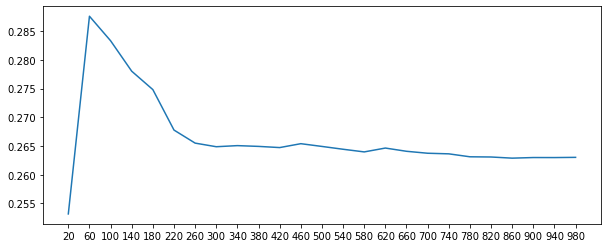

In [424]:
fig,ax = plt.subplots(figsize=(10,4))
plt.plot(scores.index,scores.values)

In [425]:
skl_knn = knn(n_neighbors=int(indx)).fit(X_train3, y_train3)
knn_score3 = skl_knn.score(X_test3, y_test3)
print(knn_score3)

0.2732330467557673


#### b) Random Forest

In [426]:
from sklearn.ensemble import RandomForestRegressor as rf

In [427]:
cross_val_score(rf(n_estimators=100,max_depth=3),X_train3, y_train3.ravel(),cv=5).mean()

0.2950210431373713

In [428]:
cv_scores = pd.DataFrame()
for i in range(1,25):
    cv_scores.loc[i,'rf'] = cross_val_score(rf(n_estimators=100,max_depth=i),X_train3, y_train3.ravel(),cv=5).mean()

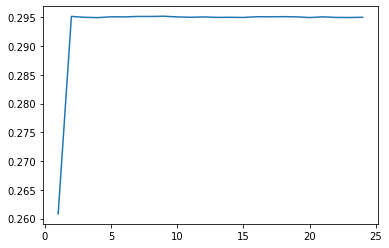

In [429]:
ax = cv_scores.plot()
ax.get_legend().remove()

In [430]:
indx = scores.idxmax()
skl_rf = rf(n_estimators=100,max_depth=int(indx)).fit(X_train3, y_train3.ravel())
skl_rf.predict(X_test3)
rf_score3 = skl_rf.score(X_test3,y_test3)
print(rf_score3)

0.28304609141619497


In [431]:
score_table = pd.DataFrame({'K Nearest Neighbors':[knn_score3],'Random Forest':[rf_score3]})
score_table = score_table.T
score_table.columns = ['Score']
score_table

Score
K Nearest Neighbors  0.273233
Random Forest        0.283046

#####  As we can see from above table, for log_price, we should choose Random Forest  as the score of this model is the highest, compared to K Nearest Neighbors.

##### Rank score for log_price : Random Forest  >  KNN
##### Possiable reason for a relative low score for both is that log_price should  be dependent on some features not containing in the dataFrame as well, such as environment, surroundings or quality of the room. 


# ➢ Seattle

# 1. Data

## 1.1 Data Description

In [432]:
sea = import_df('https://raw.githubusercontent.com/kristallqiu99/' +
                'data_bootcamp_final_project/master/seattle_data/AB_SEA_2016.csv')
sea.drop(sea.columns[0],axis = 1,inplace=True)
sea.head(5)

id                           listing_url       scrape_id last_scraped  \
0   241032   https://www.airbnb.com/rooms/241032  20160104002432   2016-01-04   
1   953595   https://www.airbnb.com/rooms/953595  20160104002432   2016-01-04   
2  3308979  https://www.airbnb.com/rooms/3308979  20160104002432   2016-01-04   
3  7421966  https://www.airbnb.com/rooms/7421966  20160104002432   2016-01-04   
4   278830   https://www.airbnb.com/rooms/278830  20160104002432   2016-01-04   

                                  name  \
0         Stylish Queen Anne Apartment   
1   Bright & Airy Queen Anne Apartment   
2  New Modern House-Amazing water view   
3                   Queen Anne Chateau   
4       Charming craftsman 3 bdm house   

                                             summary  \
0                                                NaN   
1  Chemically sensitive? We've removed the irrita...   
2  New modern house built in 2013.  Spectacular s...   
3  A charming apartment that sits atop Queen Anne...   
4  Cozy family craftman house in beautiful neighb...   

                                               space  \
0  Make your self at home in this charming one-be...   
1  Beautiful, hypoallergenic apartment in an extr...   
2  Our house is modern, light and fresh with a wa...   
3                                                NaN   
4  Cozy family craftman house in beautiful neighb...   

                                         description experiences_offered  \
0  Make your self at home in this charming one-be...                none   
1  Chemically sensitive? We've removed the irrita...                none   
2  New modern house built in 2013.  Spectacular s...                none   
3  A charming apartment that sits atop Queen Anne...                none   
4  Cozy family craftman house in beautiful neighb...                none   

                               neighborhood_overview  ... review_scores_value  \
0                                                NaN  ...                10.0   
1  Queen Anne is a wonderful, truly functional vi...  ...                10.0   
2  Upper Queen Anne is a charming neighborhood fu...  ...                10.0   
3                                                NaN  ...                 NaN   
4  We are in the beautiful neighborhood of Queen ...  ...                 9.0   

  requires_license license jurisdiction_names instant_bookable  \
0                f     NaN         WASHINGTON                f   
1                f     NaN         WASHINGTON                f   
2                f     NaN         WASHINGTON                f   
3                f     NaN         WASHINGTON                f   
4                f     NaN         WASHINGTON                f   

  cancellation_policy  require_guest_profile_picture  \
0            moderate                              f   
1              strict                              t   
2              strict                              f   
3            flexible                              f   
4              strict                              f   

  require_guest_phone_verification calculated_host_listings_count  \
0                                f                              2   
1                                t                              6   
2                                f                              2   
3                                f                              1   
4                                f                              1   

  reviews_per_month  
0              4.07  
1              1.48  
2              1.15  
3               NaN  
4              0.89  

[5 rows x 92 columns]

In [433]:
sea.isnull().sum()

id                                    0
listing_url                           0
scrape_id                             0
last_scraped                          0
name                                  0
                                   ... 
cancellation_policy                   0
require_guest_profile_picture         0
require_guest_phone_verification      0
calculated_host_listings_count        0
reviews_per_month                   627
Length: 92, dtype: int64

## 1.2 Data Cleaning

In [434]:
var_col3 = var_col.copy()

In [435]:
i = var_col3.index('neighbourhood_cleansed')
var_col3[i]='neighbourhood_group_cleansed'
sea = sea.loc[:,var_col3]
sea.rename(columns={'neighbourhood_group_cleansed':'neighbourhood'}, inplace=True)

In [436]:
sea.isnull().sum()

id                                    0
host_id                               0
host_since                            2
host_response_time                  523
host_response_rate                  523
host_acceptance_rate                773
host_is_superhost                     2
host_listings_count                   2
host_total_listings_count             2
host_has_profile_pic                  2
host_identity_verified                2
street                                0
neighbourhood                         0
latitude                              0
longitude                             0
property_type                         1
room_type                             0
accommodates                          0
bathrooms                            16
bedrooms                              6
beds                                  1
bed_type                              0
price                                 0
guests_included                       0
extra_people                          0


In [437]:
sea.dropna(subset=['reviews_per_month'],inplace=True)

# 2. Exploratory Data Analysis

## 2.1 Data Visualization 

### 2.1.1 Location

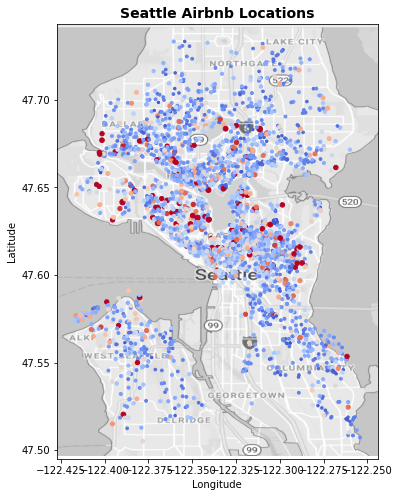

In [438]:
xl,xh,yl,yh = area(sea)
fig,ax = location('Seattle',sea,0.5,3,12,8)
img_sea = import_img('https://raw.githubusercontent.com/kristallqiu99/' +
                     'data_bootcamp_final_project/master/seattle_data/SEA_map.png')
ax.imshow(img_sea,extent=[xl-0.085,xh+0.075,yl-0.0085,yh+0.009])

##### In the plot above, the most expensive houses are plotted in red dots and the cheaper ones are plotted in light blue. We learn that in Seattle, the most expensive Airbnb houses are located mostly in Greenwood, Green Lake, University District, Walling Ford, Queen Anne and East Lake (from the north to the south).

### 2.1.2 Room Type 

#### a) Number of listings of each room type

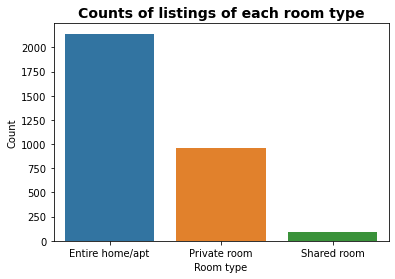

In [439]:
ax = sns.countplot(data=sea,x='room_type')
ax.set_xlabel('Room type')
ax.set_ylabel('Count')
ax.set_title('Counts of listings of each room type',size=14,fontweight='bold')
current_palette = sns.color_palette()

##### From the bar chart above, there is a significantly higher number of entire home/apt. Meanwhile, the number of shared room is low as in other cities.

#### b) Spread

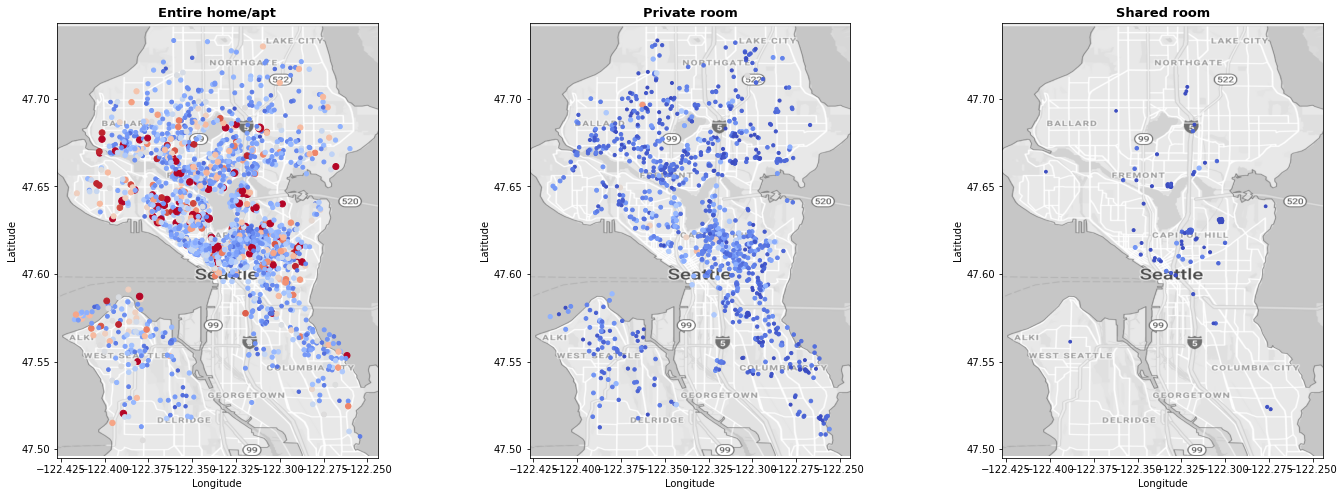

In [440]:
fig,ax = room_type_location(sea,0.6,3,8,8)
for i in range(0,len(sea['room_type'].unique())):
    ax[i].imshow(img_sea,extent=[xl-0.085,xh+0.075,yl-0.009,yh+0.009])

##### Those two major room types distribute evenly in Seattle, and their locations don't follow some certain patterns.

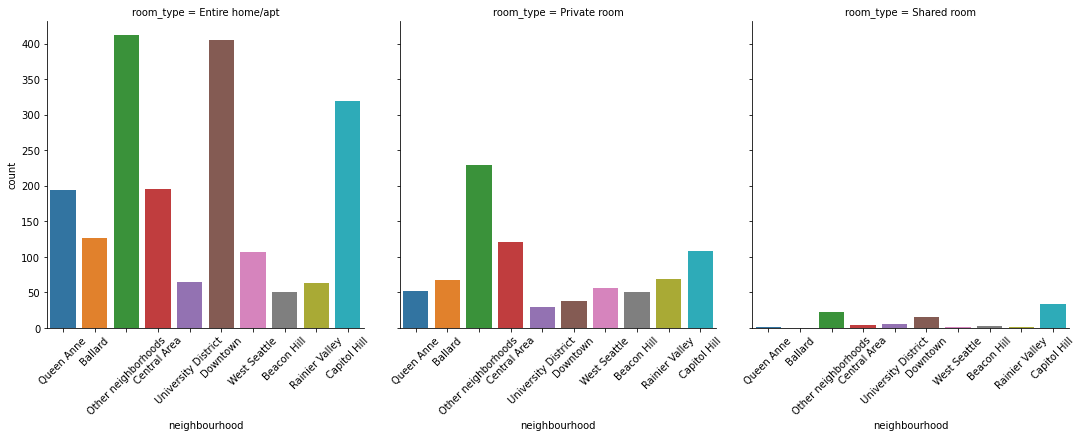

In [441]:
top_nei_room_type('Seattle',sea)

##### From the plot above, we learn that Downtown and Capital Hill have much more entire home/apt than other neighborhoods do.

### 2.1.3 Host

/Users/kristallqiu/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


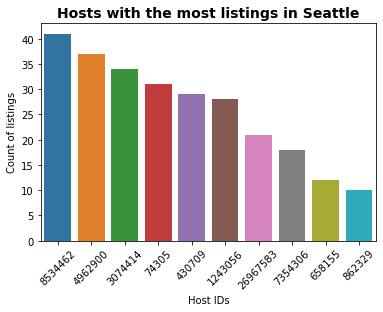

In [442]:
top_hosts('Seattle',sea)

##### We notice that the number of listing is strictly decreasing among hosts. But there isn't one specific host who has a super big competitive advantage.

### 2.1.4 Neighbourhood

(<Figure size 1296x360 with 1 Axes>,
 <AxesSubplot:title={'center':'Counts of listings in neighbourhoods'}, xlabel='Neighbourhood group', ylabel='Count'>)

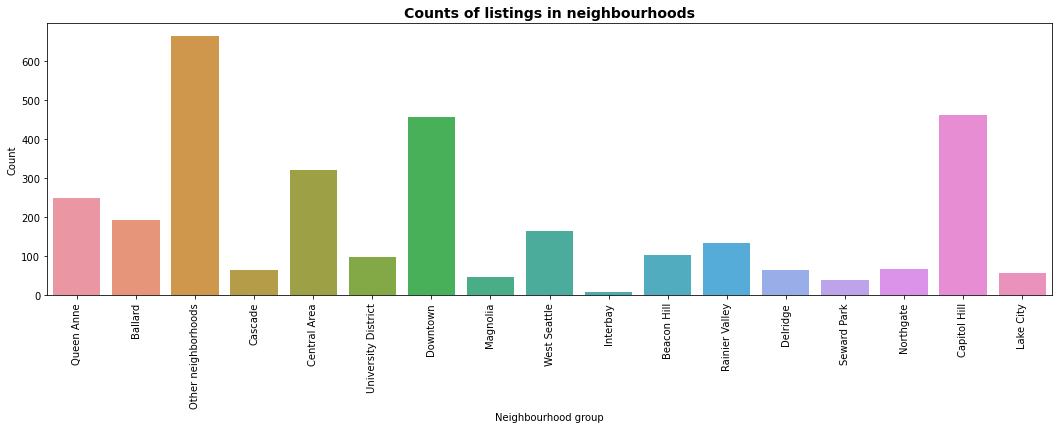

In [443]:
count_nei('Seattle',sea)

##### Since there are 87 neighborhoods in Seattle, we pick out major ones and classify all other neighborhoods as "other neighborhoods". From the bar chart above, we learn that most Airbnb houses are located in Downtown, Central Area and Capitol Hill. The Airbnb rooms are very dispersed in other districts. That is very different the scenario of NYC.

### 2.1.5 Availability

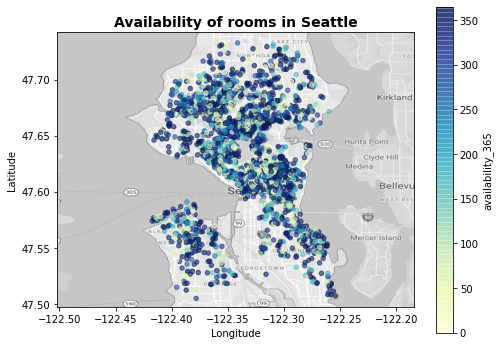

In [444]:
fig,ax = ava365('Seattle',sea,8,6)
ax.imshow(img_sea,extent=[xl-0.085,xh+0.07,yl-0.008,yh+0.009])

##### In this graph, we plot the availability of rooms in Seattle. We notice that most rooms are available for more than 200 days per year. The situation is kind of similar to Boston, we also guess there is less competition in Boston.

## 2.2 Data Analysis

### 2.2.1 Price with room types

In [445]:
rtype = sea['room_type'].unique()
price_list = []
for n in rtype:
    sub = sea.loc[sea['room_type'] == n]
    sub_price = sub[['price']]
    price_list.append(sub_price)
stats_list = []
for p in price_list:
    i = p.describe(percentiles=[.25, .50, .75])
    i = i.iloc[3:]
    i.reset_index(inplace=True)
    i.rename(columns={'index':'Stats'},inplace=True)
    stats_list.append(i)
# change names of the price column to the area name
for i in range(0,len(rtype)):
    stats_list[i].rename(columns={'price':rtype[i]},inplace=True)
# finilize dataframe for final view    
stats_df = stats_list
stats_df = [df.set_index('Stats') for df in stats_df]
stats_df = stats_df[0].join(stats_df[1:])
stats_df

Entire home/apt  Private room  Shared room
Stats                                            
min               39.0          25.0         22.0
25%               99.0          55.0         33.0
50%              126.0          68.0         40.0
75%              175.0          85.0         53.0
max             1000.0         280.0        118.0

#### a) Density distribution 

Text(0.5, 1.0, 'Density and distribution of prices for each room type')

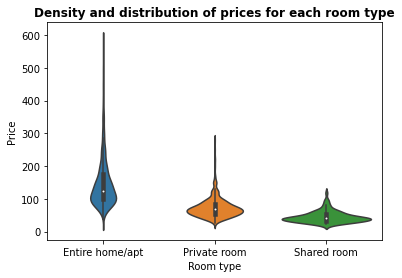

In [446]:
no_extreme = sea[sea.price < 600]    
ax = sns.violinplot(data=no_extreme,x='room_type',y='price')
ax.set_xlabel('Room type')
ax.set_ylabel('Price')
ax.set_title('Density and distribution of prices for each room type',fontweight='bold')

##### This graph is clear to show that hosts charge different prices for different room types. The cheapest room is shared room, and price of the entire home/apt can go beyond 100 dollar.

### 2.2.2 Price with neighbourhoods

In [447]:
nei_stats('Seattle',sea)

Queen Anne  Ballard  Other neighborhoods  Cascade  Central Area  \
Stats                                                                    
min         38.00     35.0                 25.0     42.0          35.0   
25%         95.00     75.0                 65.0     85.0          75.0   
50%        120.00     95.0                 96.0    115.0         100.0   
75%        189.25    145.0                140.0    140.0         150.0   
max        975.00    475.0               1000.0    775.0         500.0   

       University District  Downtown  Magnolia  West Seattle  Interbay  \
Stats                                                                    
min                   30.0     35.00      30.0          30.0      50.0   
25%                   65.0    105.25      91.5          77.5      69.0   
50%                   85.0    139.00     150.0         100.0      75.0   
75%                  109.0    175.00     228.5         165.0      95.0   
max                  350.0    999.00     950.0         495.0     150.0   

       Beacon Hill  Rainier Valley  Delridge  Seward Park  Northgate  \
Stats                                                                  
min           30.0           25.00      35.0         34.0      30.00   
25%           60.0           58.25      55.0         65.0      61.00   
50%           75.0           75.00      70.0         90.0      82.50   
75%          104.0          103.75      95.0        121.0     109.75   
max          399.0          300.00     250.0        375.0     200.00   

       Capitol Hill  Lake City  
Stats                           
min            22.0      35.00  
25%            80.0      55.75  
50%           109.5      70.00  
75%           150.0     107.00  
max           750.0     252.00

#### a) Density distribution

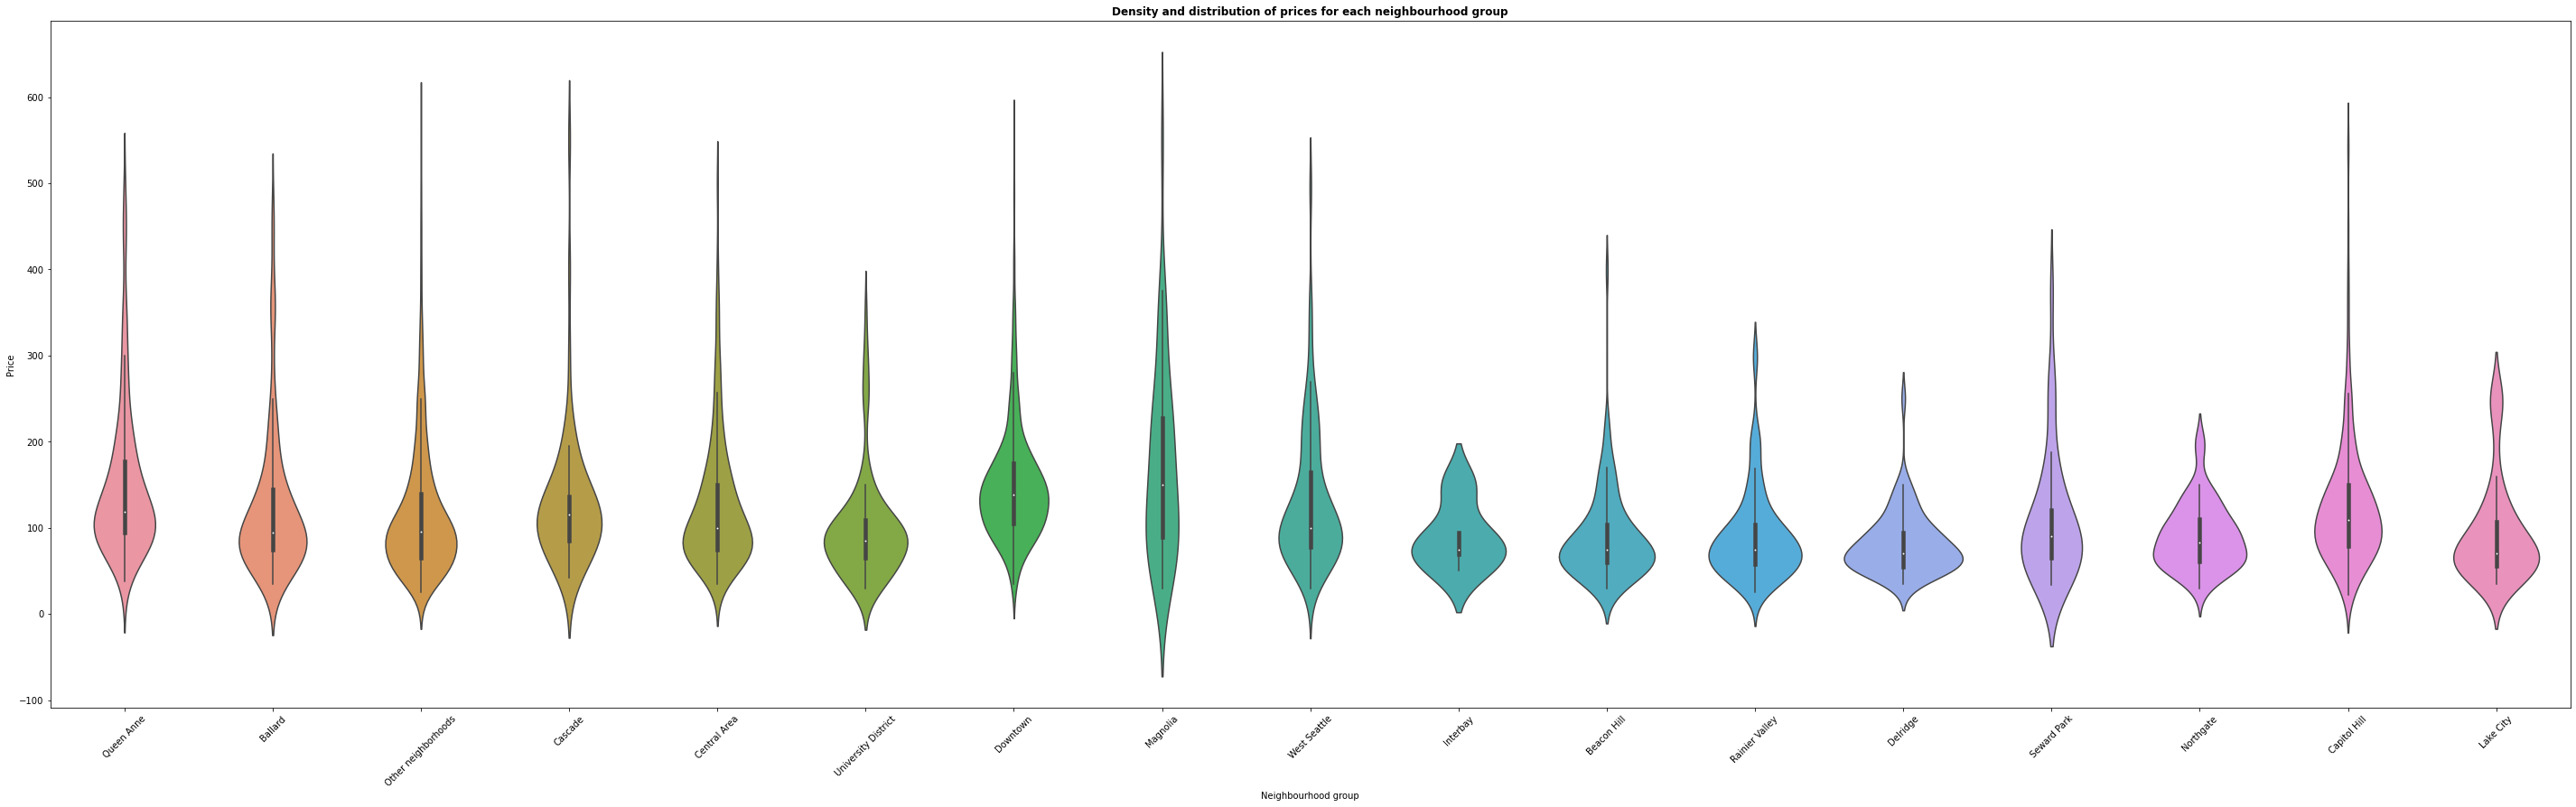

In [448]:
fig,ax = plt.subplots(figsize=(50,14))
ax = plot_distribution('Seattle',sea,600)

##### We see the prices vary a lot in some neighborhoods, especially Magnolia. Also, the gap between most expensive one and the cheapest one is much bigger in these districts. We guess there is a very diversed portfolio in these neighborhoods so that we have rooms that meet different people's need.

### 2.2.3 Neighbourhood Exploration

#### a) Popular Neighbourhood 

/Users/kristallqiu/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


(<Figure size 3600x1008 with 1 Axes>,
 <AxesSubplot:title={'center':'Most Popular Neighbourhood in Seattle'}, xlabel='Number of guest hosted in this Area', ylabel='Neighbourhood area'>)

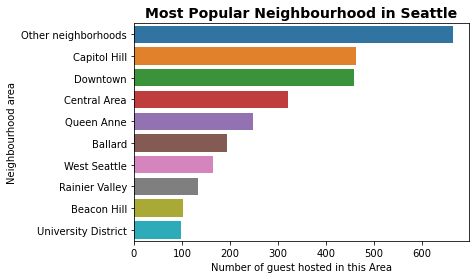

In [449]:
top_nei('Seattle',sea)

##### Since there are 87 neighborhoods in Seattle, we pick out major ones and classify all other neighborhoods as "other neighborhoods". We can see that Capitol Hill and Downtown are the most popular neighborhoods in Seattle, with Central Area in the third place.

####  b) Room type within popular neighbourhoods

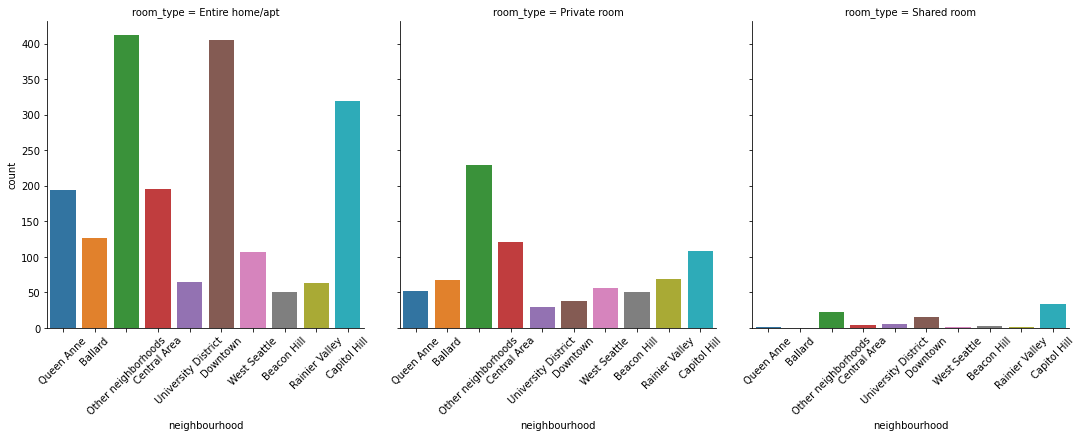

In [450]:
top_nei_room_type('Seattle',sea)

##### Based on the top ten popular neighborhood we selected before, we picture the room types information in these neighborhoods for readers' reference. Guests can know the distribution of their favourite room type in popular neighborhoods, so that they can make the decisions more easily. We notice that Downtown and Capital Hill have an extremely high number of entire home/apt. Since there are 87 neighborhoods in Seattle, we pick out major ones and classify all other neighborhoods as "other neighborhoods".

# 3. Descriptive Data Analysis

## 3.1 Pairplot of each variable

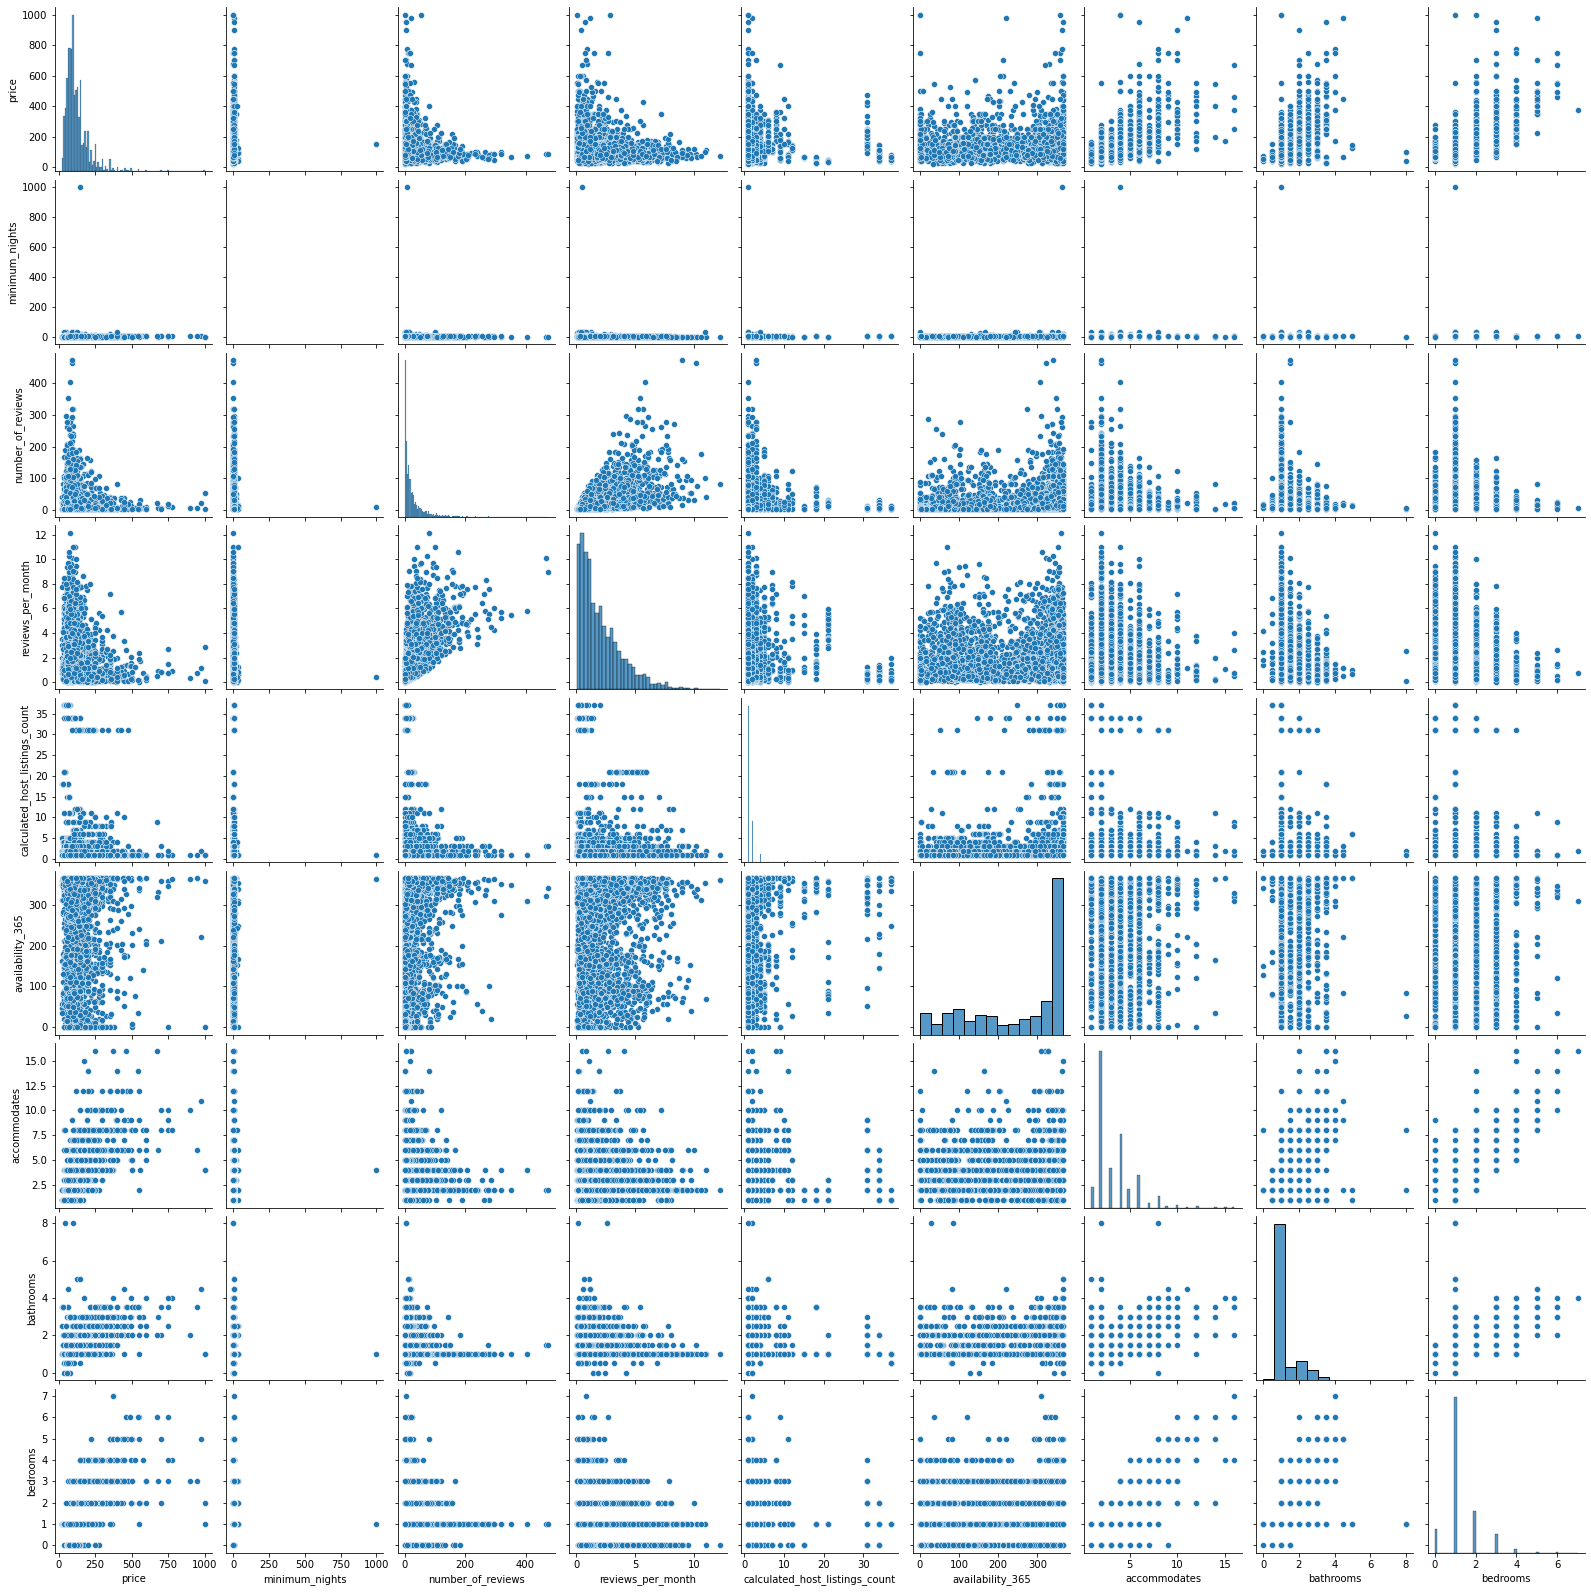

In [451]:
vc = list(nyc.columns)
for i in ['id','host_id','neighbourhood_group','latitude', 'longitude']:
    vc.remove(i)
for j in ['accommodates', 'bathrooms', 'bedrooms']:
    vc.append(j)

pp4 = sea.loc[:,vc]
sns.pairplot(pp4)

##### We can see the correltation between each variable. It does not make sense as many of them are categorical data

# 4. Predictive Data Analysis

In [452]:
model4 = sea.dropna().loc[:,:].copy()
model4['neighbourhood'] = model4['neighbourhood'].astype("category").cat.codes
model4['room_type'] = model4['room_type'].astype("category").cat.codes
model4['host_response_time'] = model4['host_response_time'].astype("category").cat.codes

model4['host_response_rate'] = model4['host_response_rate'].str.replace('%','').astype(int)
model4['host_acceptance_rate'] = model4['host_acceptance_rate'].str.replace('%','').astype(int)
model4['host_response_rate'] = model4['host_response_rate']/100
model4['host_acceptance_rate'] = model4['host_acceptance_rate']/100

tf = ['host_is_superhost','host_has_profile_pic','host_identity_verified',
      'require_guest_profile_picture','require_guest_phone_verification']
for c in tf:
    model4[c] = model4[c].replace('t',1)
    model4[c] = model4[c].replace('f',0)

cancel = ['flexible','moderate','strict', 'super_strict_30']
for i in range(0,len(cancel)):    
    model4['cancellation_policy'] = model4['cancellation_policy'].replace(cancel[i],i)

mean = model4['reviews_per_month'].mean()
model4['reviews_per_month'].fillna(mean, inplace=True)

model4['extra_people'] = model4['extra_people'].str.replace('$','').astype(float)
model4['property_type'] = model4['property_type'].astype("category").cat.codes
model4['bed_type'] = model4['bed_type'].astype("category").cat.codes

model4['log_price'] = np.log(model4.price+1)

model4 = model4.drop(columns=['id' ,'host_id','price','host_since','street']) # delete price column

model4.isnull().sum()

host_response_time                  0
host_response_rate                  0
host_acceptance_rate                0
host_is_superhost                   0
host_listings_count                 0
host_total_listings_count           0
host_has_profile_pic                0
host_identity_verified              0
neighbourhood                       0
latitude                            0
longitude                           0
property_type                       0
room_type                           0
accommodates                        0
bathrooms                           0
bedrooms                            0
beds                                0
bed_type                            0
guests_included                     0
extra_people                        0
minimum_nights                      0
maximum_nights                      0
availability_365                    0
number_of_reviews                   0
cancellation_policy                 0
require_guest_profile_picture       0
require_gues

#####  Value Reference

In [453]:
seaVF = {}
sead = ['neighbourhood','room_type','host_response_time',
       'host_is_superhost','cancellation_policy','property_type','bed_type']
for c in sead:
    seaVF = {}
    for i in model4[c].unique():
        indx = model4[model4[c]==i].index.values[0]
        seaVF[i] = sea[c][indx]
    print(c.capitalize(),'\n',dict(sorted(seaVF.items())))

Neighbourhood 
 {0: 'Ballard', 1: 'Beacon Hill', 2: 'Capitol Hill', 3: 'Cascade', 4: 'Central Area', 5: 'Delridge', 6: 'Downtown', 7: 'Interbay', 8: 'Lake City', 9: 'Magnolia', 10: 'Northgate', 11: 'Other neighborhoods', 12: 'Queen Anne', 13: 'Rainier Valley', 14: 'Seward Park', 15: 'University District', 16: 'West Seattle'}
Room_type 
 {0: 'Entire home/apt', 1: 'Private room', 2: 'Shared room'}
Host_response_time 
 {0: 'a few days or more', 1: 'within a day', 2: 'within a few hours', 3: 'within an hour'}
Host_is_superhost 
 {0: 'f', 1: 't'}
Cancellation_policy 
 {0: 'flexible', 1: 'moderate', 2: 'strict'}
Property_type 
 {0: 'Apartment', 1: 'Bed & Breakfast', 2: 'Boat', 3: 'Bungalow', 4: 'Cabin', 5: 'Camper/RV', 6: 'Chalet', 7: 'Condominium', 8: 'Dorm', 9: 'House', 10: 'Loft', 11: 'Other', 12: 'Tent', 13: 'Townhouse', 14: 'Treehouse', 15: 'Yurt'}
Bed_type 
 {0: 'Airbed', 1: 'Couch', 2: 'Futon', 3: 'Pull-out Sofa', 4: 'Real Bed'}


# 4. Predictive Data Analysis

## 4.1 Probability distribution

/Users/kristallqiu/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/kristallqiu/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Log-Price Distribution Plot')

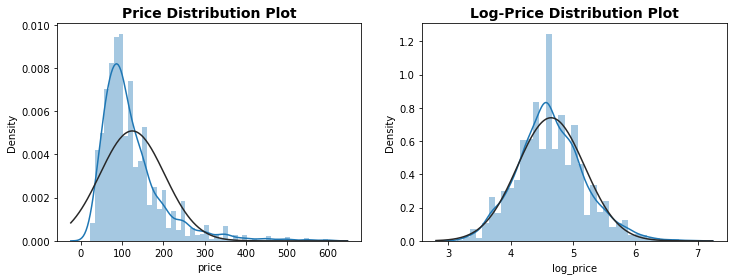

In [454]:
fig,ax = plt.subplots(1,2,figsize=(12,4))
sns.distplot(sea.loc[sea['price']<=600]['price'],fit=norm, ax=ax[0]) # drop extreme values of price which are greater than 600
ax[0].set_title("Price Distribution Plot",size=14, weight='bold')
sns.distplot(model4['log_price'],fit=norm,ax=ax[1])
ax[1].set_title("Log-Price Distribution Plot",size=14, weight='bold')

##### It is also true that the log_price is approximitely normol distributed. However, this time it is a little bit right skewed.

##  4.2 Correlation


Text(0.5, 1.0, 'Correlation Matrix')

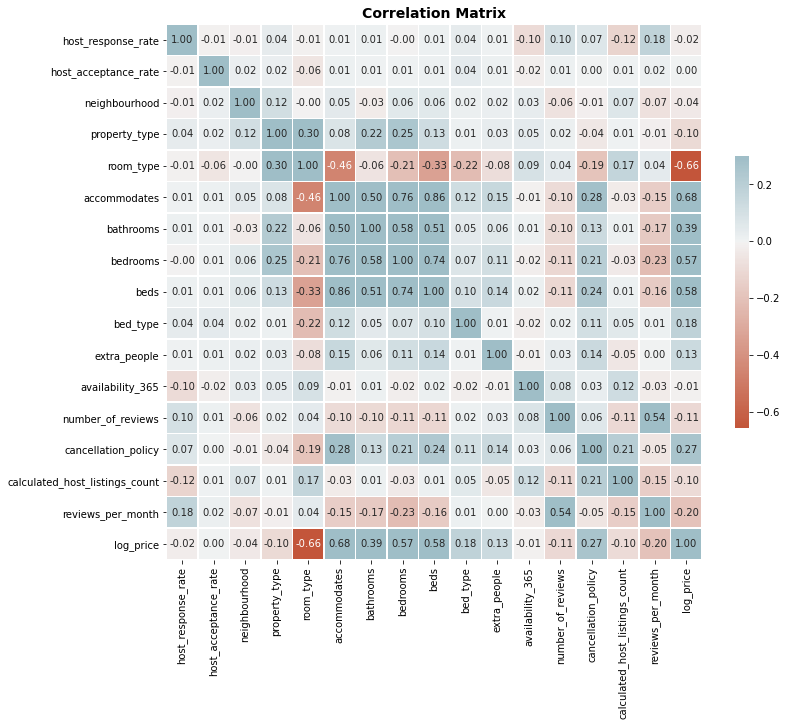

In [455]:
keep_col = ['host_response_rate', 'host_acceptance_rate','neighbourhood',
        'property_type', 'room_type', 'accommodates',
       'bathrooms', 'bedrooms', 'beds', 'bed_type', 'extra_people',
        'availability_365', 'number_of_reviews', 'cancellation_policy',
        'calculated_host_listings_count', 'reviews_per_month', 'log_price']
col_df4 = model4.loc[:,keep_col]
plt.figure(figsize=(12,10))
palette = sns.diverging_palette(20, 220, n=256)
corr=col_df4.corr(method='pearson')
sns.heatmap(corr, annot=True, fmt=".2f", cmap=palette, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}).set(ylim=(17, 0))
plt.title("Correlation Matrix",size=14, weight='bold')

##### In this correlation matrix we calculate and display the correlation between different variables. The hosts can easily find the relationship between variables and make the optimized investment decisions.

## 4.3 Regression

In [456]:
model4['price'] = sea.dropna().loc[:,['price']]

### 4.3.1 Linear Regression

In [457]:
import statsmodels.formula.api as smf

#### a) Price - all variables

In [458]:
reg_price = smf.ols('price ~ host_response_rate + host_acceptance_rate + neighbourhood + property_type + room_type + accommodates + bathrooms + bedrooms + beds + bed_type + extra_people + availability_365 + number_of_reviews + cancellation_policy + calculated_host_listings_count + reviews_per_month'
                    ,data=model4).fit()
print(reg_price.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.581
Model:                            OLS   Adj. R-squared:                  0.578
Method:                 Least Squares   F-statistic:                     229.8
Date:                Wed, 04 Nov 2020   Prob (F-statistic):               0.00
Time:                        11:54:39   Log-Likelihood:                -14384.
No. Observations:                2671   AIC:                         2.880e+04
Df Residuals:                    2654   BIC:                         2.890e+04
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept   

##### Here we run an ordinary least square regression for price on several factors that we think may influence the price of Airbnb. We have H0: beta = 0 against H1: beta != 0  for every beta in this regression model. According to the output table, the P-value of host_response_rate, host_response_rate, beds, beds_type, avaiability_365, number_of_reviews and calculated_host_listings_count are bigger than 5%, which means that we don't reject H0 against H1. There is no evidence that the effect of host_response_rate, host_response_rate, beds, beds_type, avaiability_365, number_of_reviews and calculated_host_listings_countis significant to the price of Airbnb house and we should drop them. 

#### a) Price - drop variables

In [459]:
reg_price = smf.ols('price ~ neighbourhood + property_type + room_type + accommodates + bathrooms + bedrooms + extra_people + cancellation_policy + reviews_per_month'
                    ,data=model4).fit()
print(reg_price.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.579
Model:                            OLS   Adj. R-squared:                  0.578
Method:                 Least Squares   F-statistic:                     406.8
Date:                Wed, 04 Nov 2020   Prob (F-statistic):               0.00
Time:                        11:54:39   Log-Likelihood:                -14389.
No. Observations:                2671   AIC:                         2.880e+04
Df Residuals:                    2661   BIC:                         2.886e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              44.0854    

##### After dropping those insignificant variables, we run the linear regression again. This time we find all remained variables significant at 5% level, as we expected.

#### And, we can get price = 44.0854 - neighbour* 0.8220 - property_type* 0.9107 - room_type* 38.7602 + accommodates* 8.7267 + bathrooms* 28.2083 + bedrooms* 27.5542 + extra_people* 0.20034 + cancellation_policy* 4.3426 - reviews_per_month* 2.4800

#### And from this, we can find that bedrooms make the largest contribution to a relative higher price.


#### b) Log price - all variables

In [460]:
reg_price = smf.ols('log_price ~ host_response_rate + host_acceptance_rate + neighbourhood + property_type + room_type + accommodates + bathrooms + bedrooms + beds + bed_type + extra_people + availability_365 + number_of_reviews + cancellation_policy + calculated_host_listings_count + reviews_per_month'
                    ,data=model4).fit()
print(reg_price.summary())

                            OLS Regression Results                            
Dep. Variable:              log_price   R-squared:                       0.674
Model:                            OLS   Adj. R-squared:                  0.672
Method:                 Least Squares   F-statistic:                     342.3
Date:                Wed, 04 Nov 2020   Prob (F-statistic):               0.00
Time:                        11:54:39   Log-Likelihood:                -643.73
No. Observations:                2671   AIC:                             1321.
Df Residuals:                    2654   BIC:                             1422.
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept   

##### Here we run an ordinary least square regression for log_price on several factors that we think may influence the price of Airbnb. We have H0: beta = 0 against H1: beta != 0  for every beta in this regression model. According to the output table, the P-value of host_response_rate,beds, and number_of _reviews are bigger than 5%, which means that we don't reject H0 against H1. There is no evidence that the effect of rhost_response_rate,beds, and number_of _reviews is significant to the price of Airbnb house and we should drop them.  

#### b) Log price - drop variables

In [461]:
reg_price = smf.ols('price ~ host_acceptance_rate + neighbourhood + property_type + room_type + accommodates + bathrooms + bedrooms + bed_type + extra_people + availability_365 + cancellation_policy + calculated_host_listings_count + reviews_per_month'
                    ,data=model4).fit()
print(reg_price.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.580
Model:                            OLS   Adj. R-squared:                  0.578
Method:                 Least Squares   F-statistic:                     282.1
Date:                Wed, 04 Nov 2020   Prob (F-statistic):               0.00
Time:                        11:54:39   Log-Likelihood:                -14387.
No. Observations:                2671   AIC:                         2.880e+04
Df Residuals:                    2657   BIC:                         2.888e+04
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept   

##### After dropping those insignificant variables, we run the linear regression again. This time we find all remained variables significant at 5% level, as we expected.

##### And, we can get log_price = 4.9270 - 0.7283* host_acceptance_rate - 0.0068* neighbourhood - property_type* 0.0067 - room_type* 0.4613 + accommodates* 0.0564 + bathrooms* 0.1016 + bedrooms* 0.1469 + bed_type* 0.0410 + extra_people* 0.0008 + availability_365* 0.0002 + cancellation_policy* 0.0294 - calculated_host_listings_count* 0.0022 - reviews_per_month* 0.0235
##### We find that different from price, bedrooms has the greatest relevance of the log_price.


### 4.3.2 ML

##### From the linear regression we found that log_price is a better dependent variable to predict.

In [462]:
from sklearn.model_selection import train_test_split

In [463]:
X_train4, X_test4, y_train4, y_test4 = train_test_split(model4[['room_type']].values, model4[['log_price']].values,
                                        test_size=0.25, random_state=0)

#### a) K-Nearest Neighbors

In [464]:
from sklearn.neighbors import KNeighborsRegressor as knn
from sklearn.model_selection import cross_val_score

In [465]:
scores = pd.Series()
for i in range(20,1000,40):
    scores[str(i)] = cross_val_score(knn(n_neighbors=i),
                    X_train4, y_train4,cv=5).mean()
indx = scores.idxmax()

<ipython-input-465-c488bb7d7dc7>:1: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  scores = pd.Series()


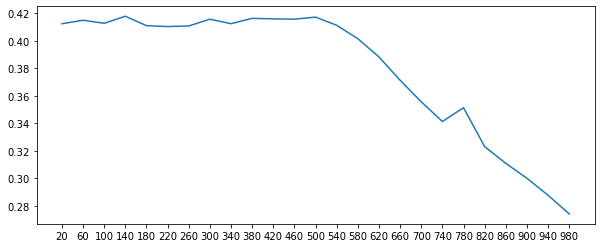

In [466]:
fig,ax = plt.subplots(figsize=(10,4))
plt.plot(scores.index,scores.values)

In [467]:
skl_knn = knn(n_neighbors=int(indx)).fit(X_train4, y_train4)
knn_score4 = skl_knn.score(X_test4, y_test4)
print(knn_score4)

0.41371362563147795


#### b) Random Forest

In [468]:
from sklearn.ensemble import RandomForestRegressor as rf

In [469]:
cross_val_score(rf(n_estimators=100,max_depth=3),X_train4, y_train4.ravel(),cv=5).mean()

0.4343007642316056

In [470]:
cv_scores = pd.DataFrame()
for i in range(1,25):
    cv_scores.loc[i,'rf'] = cross_val_score(rf(n_estimators=100,max_depth=i),X_train4, y_train4.ravel(),cv=5).mean()

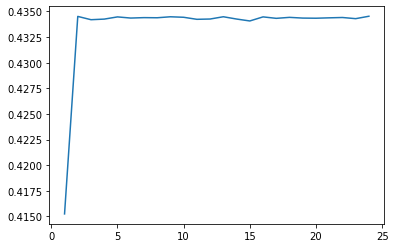

In [471]:
ax = cv_scores.plot()
ax.get_legend().remove()

In [472]:
indx = scores.idxmax()
skl_rf = rf(n_estimators=100,max_depth=int(indx)).fit(X_train4, y_train4.ravel())
skl_rf.predict(X_test4)
rf_score4 = skl_rf.score(X_test4,y_test4)
print(rf_score4)

0.41838139640368466


In [473]:
score_table = pd.DataFrame({'K Nearest Neighbors':[knn_score4],'Random Forest':[rf_score4]})
score_table = score_table.T
score_table.columns = ['Score']
score_table

Score
K Nearest Neighbors  0.413714
Random Forest        0.418381

#####  As we can see from above table, for log_price, we should choose Random Forest   as the score of this model is the highest, compared to K Nearest Neighbors.

##### Rank score for log_price : Random Forest  >  KNN
##### Possiable reason for a relative low score for both is that log_price should  be dependent on some features not containing in the dataFrame as well, such as environment, surroundings or quality of the room. 


# 5. Cross-city comparison

## 5.1 Data Cleaning & Filtering

In [474]:
nyc.columns

Index(['id', 'host_id', 'neighbourhood_group', 'neighbourhood', 'latitude',
       'longitude', 'room_type', 'price', 'minimum_nights',
       'number_of_reviews', 'reviews_per_month',
       'calculated_host_listings_count', 'availability_365'],
      dtype='object')

### NYC Data 

'neighbourhood_group'

In [475]:
nyc1 = nyc.copy()
nyc1 = nyc1.loc[:,['id', 'neighbourhood', 'room_type', 'price', 'minimum_nights',
       'reviews_per_month','calculated_host_listings_count', 'availability_365']]
nyc1['city'] = np.array(['New York']*len(nyc))

### Boston Data 

In [476]:
'neighbourhood_group' in bos.columns

False

In [477]:
bos1 = bos.copy()
bos1 = bos1.loc[:,['id', 'neighbourhood', 'room_type', 'price', 'minimum_nights',
       'reviews_per_month','calculated_host_listings_count', 'availability_365']]
bos1['city'] = np.array(['Boston']*len(bos))

### San Francisco Data 

'neighbourhood_group'

In [478]:
sf1 = sf.copy()
sf1 = sf1.loc[:,['id', 'neighbourhood', 'room_type', 'price', 'minimum_nights',
       'reviews_per_month','calculated_host_listings_count', 'availability_365']]
sf1['city'] = np.array(['San Francisco']*len(sf))

### Seattle Data 

'neighbourhood_group'

In [479]:
sea1 = sea.copy()
sea1 = sea1.loc[:,['id','neighbourhood', 'room_type', 'price', 'minimum_nights',
       'reviews_per_month','calculated_host_listings_count', 'availability_365']]
sea1['city'] = np.array(['Seattle']*len(sea))

### Merging Data 

In [480]:
merged = pd.concat([nyc1,bos1,sf1,sea1],sort=False)

In [481]:
merged

id        neighbourhood        room_type  price  minimum_nights  \
0        2539           Kensington     Private room  149.0               1   
1        2595              Midtown  Entire home/apt  225.0               1   
3        3831         Clinton Hill  Entire home/apt   89.0               1   
4        5022          East Harlem  Entire home/apt   80.0              10   
5        5099          Murray Hill  Entire home/apt  200.0               3   
...       ...                  ...              ...    ...             ...   
3810   262764  Other neighborhoods  Entire home/apt  154.0               2   
3811  8578490  Other neighborhoods  Entire home/apt   65.0               1   
3812  3383329  Other neighborhoods  Entire home/apt   95.0               3   
3813  8101950  Other neighborhoods  Entire home/apt  359.0               3   
3814  8902327         Capitol Hill  Entire home/apt   79.0               2   

      reviews_per_month  calculated_host_listings_count  availability_365  \
0                  0.21                               6               365   
1                  0.38                               2               355   
3                  4.64                               1               194   
4                  0.10                               1                 0   
5                  0.59                               1               129   
...                 ...                             ...               ...   
3810               1.56                               1               227   
3811               0.63                               1               221   
3812               4.01                               3               287   
3813               0.30                               8                32   
3814               2.00                               1               273   

          city  
0     New York  
1     New York  
3     New York  
4     New York  
5     New York  
...        ...  
3810   Seattle  
3811   Seattle  
3812   Seattle  
3813   Seattle  
3814   Seattle  

[50428 rows x 9 columns]

## 5.2 Listings comparison 

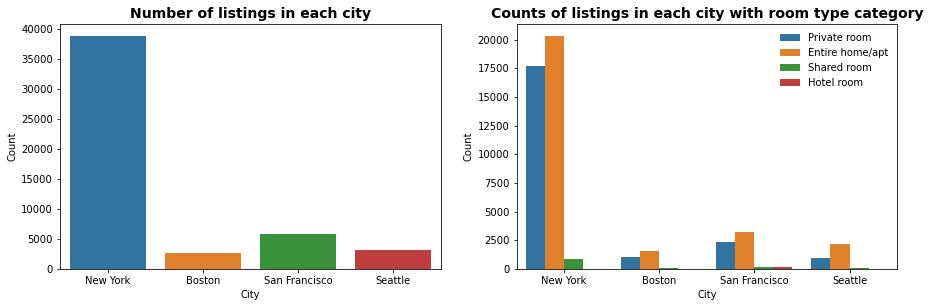

In [482]:
figure,ax = plt.subplots(1,2,figsize=(15,4.5))
sns.countplot(x='city',data=merged,ax=ax[0])
ax[0].set_xlabel('City')
ax[0].set_ylabel('Count')
ax[0].set_title('Number of listings in each city',size=14,fontweight='bold')
sns.countplot(data=merged,x='city',hue='room_type',palette=current_palette,ax=ax[1])
ax[1].set_title('Counts of listings in each city with room type category',fontsize=14,fontweight ='bold')
ax[1].set_xlabel('City')
ax[1].set_ylabel('Count')
ax[1].legend(frameon=False)

##### From the bar chart, we observe that there is almost 40000 listings in NYC, which is almost ten times as high as in other cities. 

## 5.3 Density and distribution of prices comparison 

In [483]:
city = merged['city'].unique()
price_list = []
for c in city:
    sub = merged.loc[merged['city'] == c]
    sub_price = sub[['price']]
    price_list.append(sub_price)
stats = []
for p in price_list:
    i = p.describe(percentiles=[.25, .50, .75])
    i = i.iloc[3:]
    i.reset_index(inplace=True)
    i.rename(columns={'index':'Stats'},inplace=True)
    stats.append(i)
# change names of the price column to the area name
for i in range(0,len(city)):
    stats[i].rename(columns={'price':city[i]},inplace=True)

# finilize dataframe for final view    
stats_df = stats
stats_df = [df.set_index('Stats') for df in stats_df]
stats_df = stats_df[0].join(stats_df[1:])
stats_df

New York  Boston  San Francisco  Seattle
Stats                                          
min        10.0    11.0            0.0     22.0
25%        69.0    85.0           99.0     75.0
50%       101.0   147.0          147.0    100.0
75%       170.0   219.0          230.0    150.0
max     10000.0  1300.0         8000.0   1000.0

Text(0.5, 1.0, 'Mean price for each city')

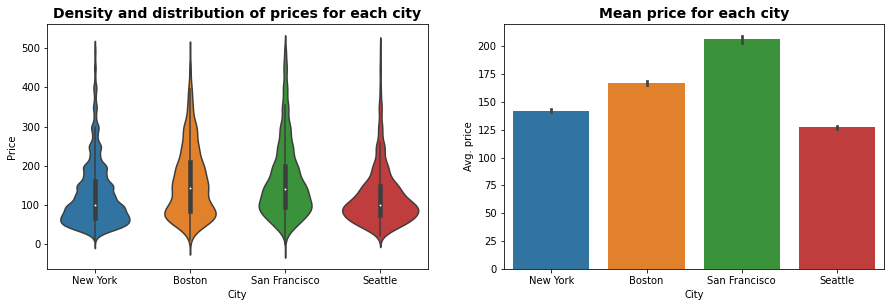

In [484]:
no_extreme = merged[merged.price < 500]    
figure,ax = plt.subplots(1,2,figsize=(15,4.5))
sns.violinplot(data=no_extreme,x='city',y='price',ax=ax[0])
ax[0].set_xlabel('City')
ax[0].set_ylabel('Price')
ax[0].set_title('Density and distribution of prices for each city',size=14, fontweight='bold')
sns.barplot(x='city', y='price', data=merged, ci=68,ax=ax[1])
ax[1].set_xlabel('City')
ax[1].set_ylabel('Avg. price')
ax[1].set_title('Mean price for each city',size=14, fontweight='bold')

In [485]:
mean = pd.DataFrame()
mean.loc['avg_price','New York'] = nyc['price'].mean()
mean.loc['avg_availability_365','New York'] = nyc['availability_365'].mean()
mean.loc['avg_price','San Francisco'] = sf['price'].mean()
mean.loc['avg_availability_365','San Francisco'] = sf['availability_365'].mean()
mean.loc['avg_price','Boston'] = bos['price'].mean()
mean.loc['avg_availability_365','Boston'] = bos['availability_365'].mean()
mean.loc['avg_price','Seattle'] = sea['price'].mean()
mean.loc['avg_availability_365','Seattle'] = sea['availability_365'].mean()
mean.loc[['avg_price'],:]

New York  San Francisco      Boston     Seattle
avg_price  142.354595     206.403717  167.139992  127.098402

##### Surprisingly, San Francisco has the highest mean price, while actually most houses in NYC are of less than 100 dollars, which is the lowest among four cities. 

## 5.4 Availability comparison

New York  San Francisco      Boston     Seattle
avg_availability_365  114.878222     154.489072  198.947551  249.193356

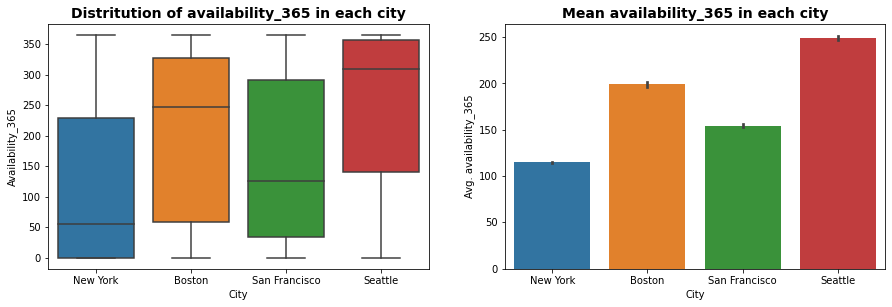

In [486]:
figure,ax = plt.subplots(1,2,figsize=(15,4.5))
sns.boxplot(x='city',y='availability_365',data=merged,ax=ax[0])
ax[0].set_xlabel('City')
ax[0].set_ylabel('Availability_365')
ax[0].set_title('Distritution of availability_365 in each city',size=14,fontweight='bold')
sns.barplot(x='city', y='availability_365', data=merged, ci=68,ax=ax[1])
ax[1].set_xlabel('City')
ax[1].set_ylabel('Avg. availability_365')
ax[1].set_title('Mean availability_365 in each city',size=14,fontweight='bold')
mean.loc[['avg_availability_365'],:]

##### NYC has the lowest availability in a year, while average availability in Seattle is almost 250 days. We guess that the NYC market is super competitive, so many hosts will take a different strategy in seasons when there are few tourists to reduce the cost.

## 5.5 Reviews comparison

Text(0.5, 1.0, 'Mean reviews per month in each city')

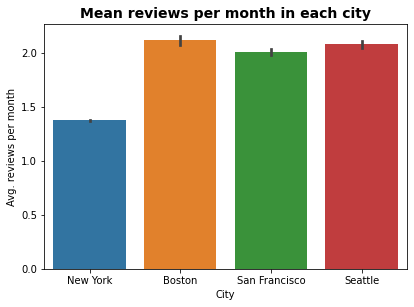

In [487]:
fig,ax=plt.subplots(figsize=(6.5,4.5))
sns.barplot(x='city', y='reviews_per_month', data=merged, ci=68,ax=ax)
ax.set_xlabel('City')
ax.set_ylabel('Avg. reviews per month')
ax.set_title('Mean reviews per month in each city',size=14,fontweight='bold')

##### From this bar chart, we know that Boston, San Francisco and Seattle almost have the same mean reviews per month. However, this statistics is much lower in NYC. We wonder if NYC hosts will have some effective tools to facilitate the communication between them and the guests.

## 5.6 Overall Conclusion for Machine Learning

In [488]:
scoreTable = {'K Nearest Neighbors': [0.413131,0.522524,0.273233,0.413714],
'Random Forest': [0.413631,0.530373,0.283049,0.418031]}
scoreTable = pd.DataFrame(scoreTable)
scoreTable["Prediction"] = list(["NYC","BOS","SF","SEA"])
scoreTable = scoreTable.set_index("Prediction")
scoreTable = scoreTable.T
scoreTable

Prediction                NYC       BOS        SF       SEA
K Nearest Neighbors  0.413131  0.522524  0.273233  0.413714
Random Forest        0.413631  0.530373  0.283049  0.418031

##### For NYC , we should use Random Forest model as the score of Linear Regression (0.413531) is higher than the score of K Nearest Neighbors (0.413131). And, we find that in NYC, neighbour has the greatest relevance of the log_price.
##### For BOS, we should use Random Forest model as the score of Linear Regression (0.530373) is higher than the score of K Nearest Neighbors (0.522524). We find that in BOS, host_reponse_rate has the greatest relevance of the log_price.
##### For SF,  we should use Random Forest model as the score of Linear Regression (0.283049) is higher than the score of K Nearest Neighbors (0.273233). We find that in SF, bedrooms has the greatest relevance of the log_price.
##### For BOS, we should use Random Forest model as the score of Linear Regression (0.418031) is higher than the score of K Nearest Neighbors (0.413714). We find that in SEA, bedrooms has the greatest relevance of the log_price

# 6. Conclusion

In the project, we display many characteristics of Airbnb rooms including location, price and availablility in four major American cities, so that both guests and hosts can have a whole picture of this industry in these cities. We see that although there are minor differences, most Airbnb rooms follow similar patterns such as in room types, in log_prices,  and so on.

By running regression, we figure out different significant variables that influence prices in different cities. We notice that many variables play different roles in different cities. Therefore, based on the result, hosts can pick the variable which contributes the most to the price increase and invest in this aspect. This help hosts to avoid wasting money and time on developing attributes that have low weight or low variance in guests' perception. 

We apply machine learning to those four datasets, making predictions based on Random Forest or KNN. According to scores attached to those methods, we pick the most suitable method for each city's dataset.

Finally, we make comparison between NYC, Boston, San Francisco and Seattle. One thing we notice is that the mean availablility in New York is very low while that in Seattle is higher than other cities. However, there are a significantly higher number of listings in NYC. This is a reflection of the market situation. We assume that the NYC market is super competitive, so many hosts will take a different strategy in seasons when there are few tourists to reduce the cost. In future projects, we can go deeper in this topic and analyze the reason behind this interesting observation.

# Reference

### Dataset & some inspiration:

NYC : https://www.kaggle.com/dgomonov/new-york-city-airbnb-open-data


BOS : https://www.kaggle.com/airbnb/boston


SF : http://insideairbnb.com/get-the-data.html


SEA : https://www.kaggle.com/airbnb/seattle